# Open-source Automatic AI-driven Ultra-broadband Passive-active Co-design Workflow: A T-Coil Peaked Wireline Driver Example

Submission to IEEE SSCS Open-Source Ecosystem "Code-a-Chip" Travel Grant Awards at ISSCC'26

SPDX-License-Identifier: Apache-2.0

| Name | Affiliation | IEEE Member | SSCS Member | Email |
|-----|-----|-----|-----|-----|
| Yizhou Xu (Leader) | ETH Zürich | Yes | Yes | yizhxu@iis.ee.ethz.ch |
| Chenhao Chu | ETH Zürich | Yes | Yes | chenhao.chu@iis.ee.ethz.ch |
| Hua Wang (Advisor) | ETH Zürich | Yes | Yes | hua.wang@iis.ee.ethz.ch |

## Introduction

Welcome to this ISSCC 2026 Code-a-Chip Challenge notebook! This notebook focuses on the automated **passive-active co-design of a T-coil used in a wireline driver circuit**. T-coil geometry is a core technique in ultra-broadband drivers to peak the high-frequency performance which requires accurate analysis via Electromagnetic (EM) simulations to capture complex parasitic effects; however, these simulations are notorious for their low computational efficiency, creating a major bottleneck in the design loop. To overcome this, we employ a **sophisticated AI-driven approach**: we train Artificial Neural Network (ANN)-based surrogate models to rapidly and accurately predict the T-coil's EM behavior, and then integrate these fast models into an inverse design algorithm to intelligently optimize the T-coil's dimensions. This methodology achieves a rapid and robust optimization flow by harnessing AI to overcome the inherent computational cost of high-fidelity analysis. This design flow utilizes openEMS for the initial EM simulation data generation and ngspice for passive-active co-simulation based on **open source IHP SG13G2 BiCMOS technology**.

## Notebook Overview

This notebook is aimed to describe a general AI-driven inverse design worklow of T-coil peaking circuits for wireline circuits in order to absorb parasitics of ESD diode, pad, and so on. The workflow is not related to any specific technology; given metal stacks, the techiniques used in this notebook could be ultilized in any RF or broadband passive-active co-design tasks. The IHP SG13G2 PDK is only used for demonstrating the related results in this notebook. The notebook is orgainzed as follows:

1. Introduction of classic T-coil peaking circuits
2. Parametric design and its generator for a T-coil passive structure
3. Batched distributed EM simulation flow for massive data generation
4. ANN-based surrogate model served as a EM data predictor
5. SPICE netlist generation combining active and passive networks
6. Algorithm-based T-coil inverse design workflow to peak the performance of wireline redriver

Here is the entire workflow used in this notebook:

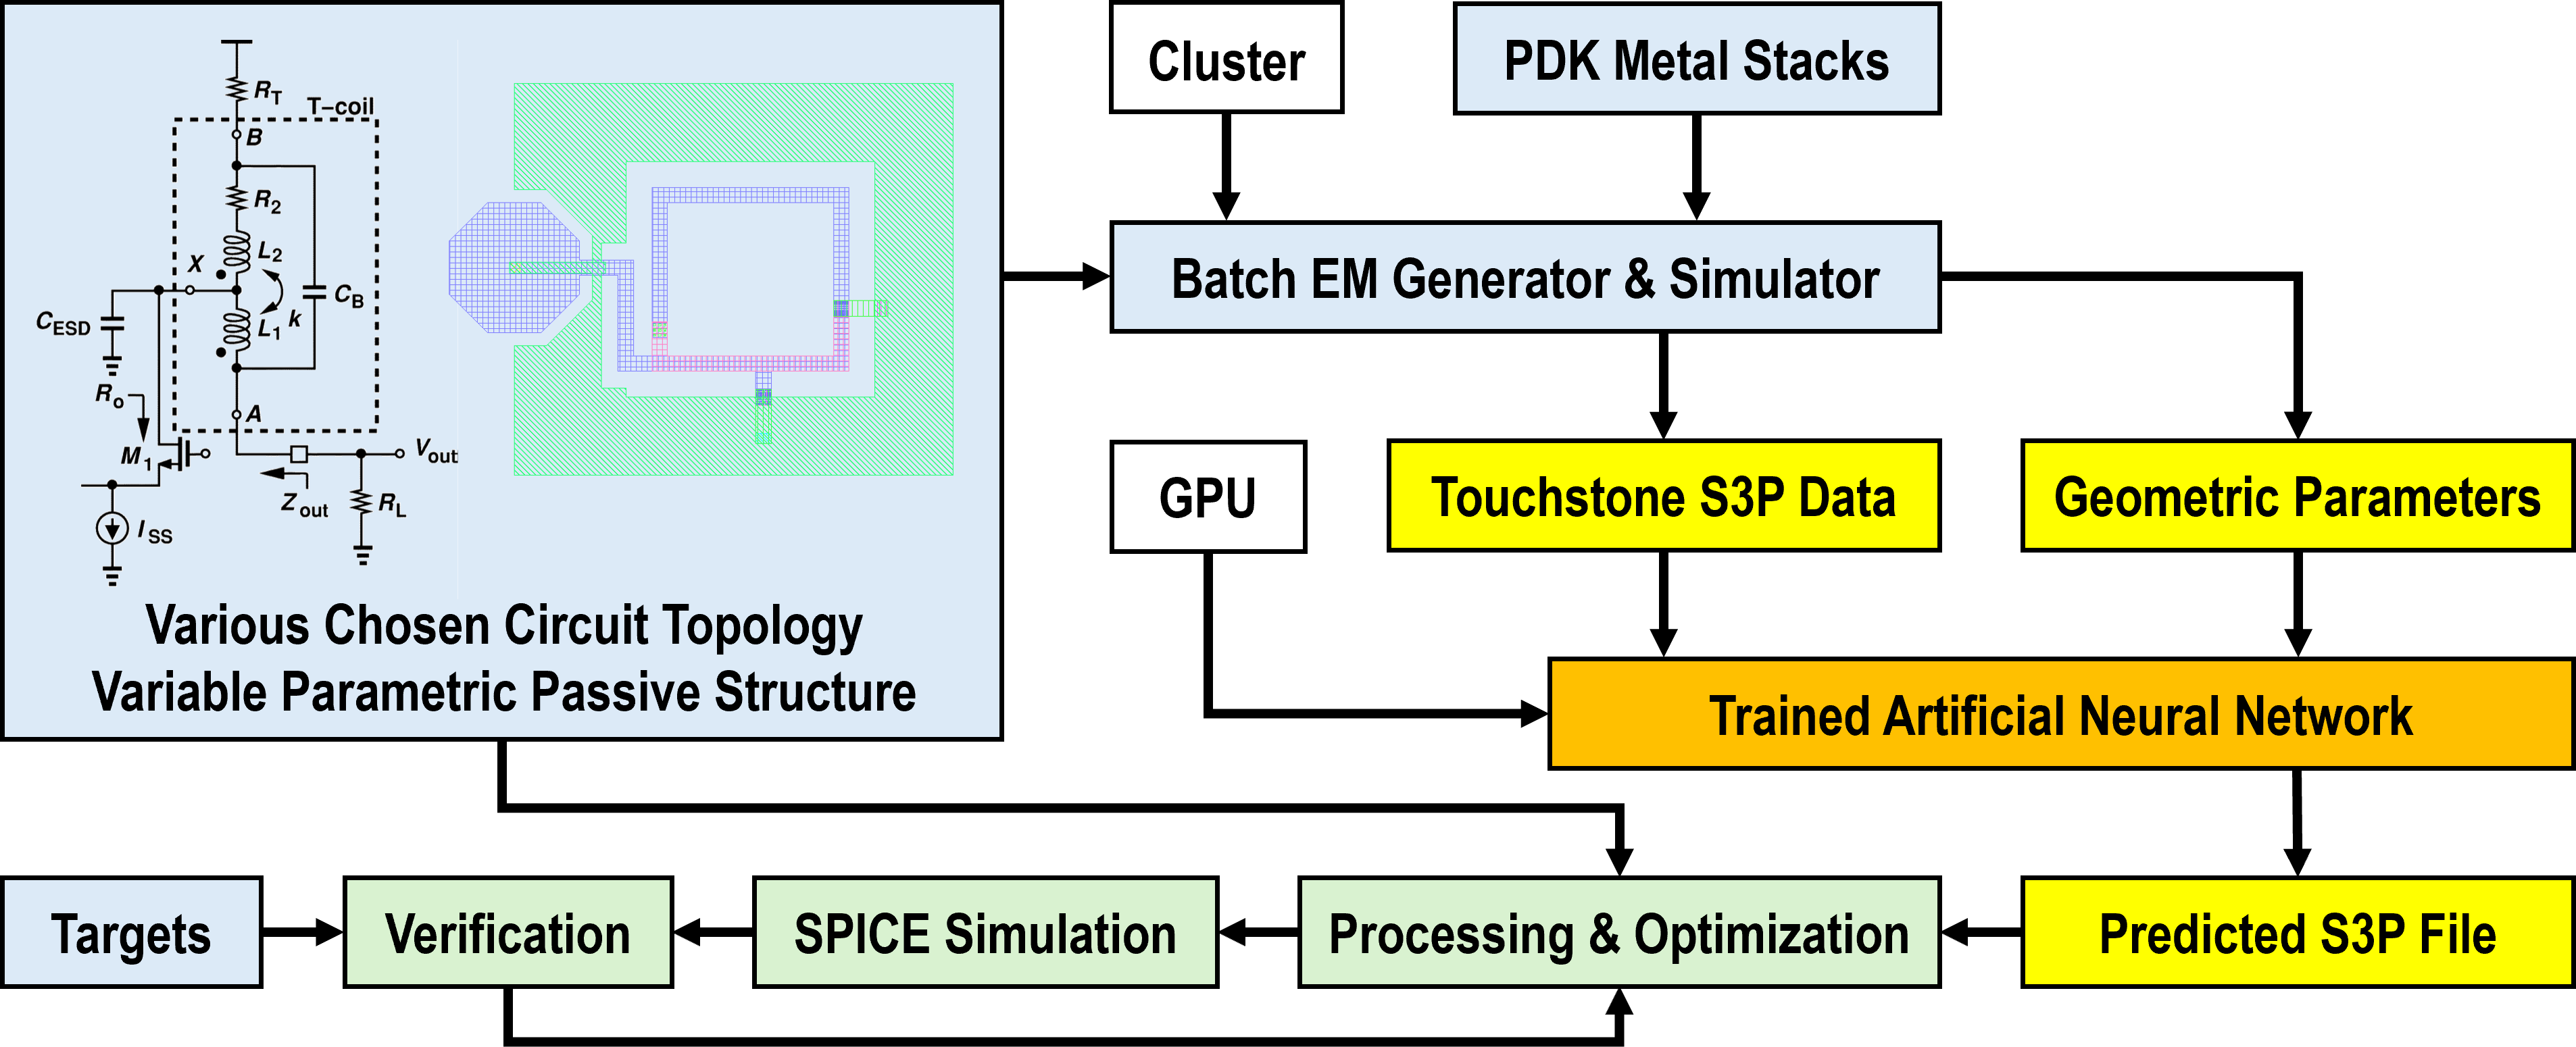


### Special Hint

Feel free to explore, modify, and adjust the specifications and code to adapt it to your specific requirements. Notice that this notebook could not run directly. Some of the code use distributed computing and external simulation, so please copy the code from certain cell to proper python file in the same folder according to instructions at the beginning of the cells.

## Requirements

This code requires large storage for EM data used in ANN training, please make sure there is at least 5GB free space for data storage.
1. **IHP SG13G2 PDK** available at https://github.com/IHP-GmbH/IHP-Open-PDK/tree/main
2. **python3**: python 3.12+ is used in this notebook, several packages are needed (will be mentioned later)
3. **ngspice** installed and should be added in PATH environment variable (https://ngspice.sourceforge.io/)
4. **openEMS** installed and should be added as a python package (https://www.openems.de/)
5. **CUDA**: CUDA 12.8 is used, with GPU memory at least 8GB (our device: RTX 4090 24GB)

## Environment Setup

### IHP SG13G2 PDK Installation Guide

"." means current directory, which stands for the running directory of current jupyter notebook.

```
git clone --recursive https://github.com/IHP-GmbH/IHP-Open-PDK.git
export PDK_ROOT=./IHP-Open-PDK
export PDK=ihp-sg13g2
cp -r $PDK_ROOT/$PDK/libs.tech/openems/openems_ihp_sg13g2/workflow/modules modules
cp $PDK_ROOT/$PDK/libs.tech/openems/openems_ihp_sg13g2/workflow/SG13G2.xml SG13G2.xml
mkdir SVG_TEMP
mkdir Temp_cir
mkdir Temp_s3p
```

In my setting, my data directory is data_path='/scratch2/Data_EMX_Ray_Distributed_Computing/TCoil_3P_IHP13_Oct2025', which could be seen later in code. Please replace with your own directory. Then create several files in the chosen directory.

```
mkdir $data_path/EMLOG
mkdir $data_path/GDS
mkdir $data_path/INFO
mkdir $data_path/PNG
mkdir $data_path/SPData
touch $data_path/Failed_List.txt
```

Then go to modules/util_simulation_setup.py: line 312

```
        if 1 in excite_portnumbers:  # only for first port excitation
```

should be replaced with

```
        if False and 1 in excite_portnumbers:  # only for first port excitation
```

This is aimed to disable the simuation setup GUI preview to accelerate massive simulation.

### Python Package Requirement

Install the following main python packages with pip.

```
pip install torch gdspy cairosvg ray spicelib optuna cmaes scikit-rf
```

Here is a pip list of all python packages in the required environment. Check this if something does not work properly.

| Package=Version | Package=Version | Package=Version | Package=Version | Package=Version |
| :--- | :--- | :--- | :--- | :--- |
| aenum=3.1.16 | alembic=1.17.0 | arrow=1.3.0 | Babel=2.10.3 | beautifulsoup4=4.14.2 |
| aiohappyeyeballs=2.6.1 | annotated-types=0.7.0 | asttokens=3.0.0 | bcrypt=3.2.2 | bleach=6.2.0 |
| aiohttp=3.13.1 | anyio=4.11.0 | async-lru=2.0.5 | blinker=1.7.0 | cachetools=6.2.1 |
| aiohttp-cors=0.8.1 | argon2-cffi=25.1.0 | attrs=25.4.0 | cairocffi=1.7.1 | CairoSVG=2.8.2 |
| aiosignal=1.4.0 | argon2-cffi-bindings=25.1.0 | certifi=2023.11.17 | cffi=1.16.0 | chardet=5.2.0 |
| click=8.2.1 | colorful=0.5.7 | colorlog=6.10.1 | comm=0.2.3 | contourpy=1.3.3 |
| cryptography=41.0.7 | cssselect2=0.8.0 | CSXCAD=0.6.2 | CSXCAD=0.6.2 | cvxopt=1.3.0 |
| cycler=0.12.1 | Cython=3.0.8 | dbus-python=1.3.2 | debtcollector=2.5.0 | debugpy=1.8.17 |
| decorator=5.2.1 | defusedxml=0.7.1 | Deprecated=1.2.14 | devscripts=2.23.7 | distlib=0.3.8 |
| distro=1.9.0 | dnspython=2.6.1 | docutils=0.20.1 | eventlet=0.35.2 | executing=2.2.1 |
| fastjsonschema=2.21.2 | filelock=3.13.1 | fonttools=4.60.1 | fqdn=1.5.1 | freetype-py=2.5.1 |
| frozenlist=1.8.0 | fsspec=2025.9.0 | gdsfactory=9.18.1 | gdsfactory_install=0.0.5 | gdspy=1.6.13 |
| google-api-core=2.27.0 | google-auth=2.41.1 | googleapis-common-protos=1.71.0 | gpg=1.18.0 | graphviz=0.21 |
| greenlet=3.0.3 | grpcio=1.76.0 | h11=0.16.0 | h5py=3.14.0 | h5py=3.14.0 |
| httpcore=1.0.9 | httplib2=0.20.4 | httpx=0.28.1 | idna=3.6 | imageio=2.37.0 |
| importlib-metadata=4.12.0 | ipyevents=2.0.4 | ipykernel=6.30.1 | ipython=9.6.0 | ipython_pygments_lexers=1.1.1 |
| ipytree=0.2.2 | ipywidgets=8.1.7 | iso8601=1.0.2 | isoduration=20.11.0 | jedi=0.19.2 |
| Jinja2=3.1.6 | json5=0.12.1 | jsonpointer=3.0.0 | jsonschema=4.25.1 | jsonschema-specifications=2025.9.1 |
| jupyter=1.1.1 | jupyter_client=8.6.3 | jupyter-console=6.6.3 | jupyter_core=5.9.1 | jupyter-events=0.12.0 |
| jupyter-lsp=2.3.0 | jupyter_server=2.17.0 | jupyter_server_terminals=0.5.3 | jupyterlab=4.4.9 | jupyterlab_pygments=0.3.0 |
| jupyterlab_server=2.27.3 | jupyterlab_widgets=3.0.15 | jwcrypto=1.5.4 | kfactory=1.14.4 | kiwisolver=1.4.9 |
| klayout=0.30.4.post1 | lark=1.3.0 | launchpadlib=1.11.0 | lazr.restfulclient=0.14.6 | lazr.uri=1.0.6 |
| lazy_loader=0.4 | loguru=0.7.3 | Mako=1.3.2.dev0 | mapbox_earcut=1.0.3 | Markdown=3.5.2 |
| markdown-it-py=4.0.0 | MarkupSafe=2.1.5 | matplotlib=3.10.6 | matplotlib-inline=0.1.7 | mdurl=0.1.2 |
| mistune=3.1.4 | monotonic=1.6 | more-itertools=10.2.0 | mpi4py=3.1.5 | mpmath=1.3.0 |
| msgpack=1.0.3 | multidict=6.7.0 | nbclient=0.10.2 | nbconvert=7.16.6 | nbformat=5.10.4 |
| nest-asyncio=1.6.0 | netaddr=0.8.0 | netifaces=0.11.0 | networkx=3.5 | notebook=7.4.7 |
| notebook_shim=0.2.4 | numpy=1.26.4 | nvidia-cublas-cu12=12.8.4.1 | nvidia-cuda-cupti-cu12=12.8.90 | nvidia-cuda-nvrtc-cu12=12.8.93 |
| nvidia-cuda-runtime-cu12=12.8.90 | nvidia-cudnn-cu12=9.10.2.21 | nvidia-cufft-cu12=11.3.3.83 | nvidia-cufile-cu12=1.13.1.3 | nvidia-curand-cu12=10.3.9.90 |
| nvidia-cusolver-cu12=11.7.3.90 | nvidia-cusparse-cu12=12.5.8.93 | nvidia-cusparselt-cu12=0.7.1 | nvidia-nccl-cu12=2.27.3 | nvidia-nvjitlink-cu12=12.8.93 |
| nvidia-nvtx-cu12=12.8.90 | oauthlib=3.2.2 | olefile=0.46 | opencensus=0.11.4 | opencensus-context=0.1.3 |
| openEMS=0.0.36 | openEMS=0.0.36 | opentelemetry-api=1.38.0 | opentelemetry-exporter-prometheus=0.59b0 | opentelemetry-proto=1.38.0 |
| opentelemetry-sdk=1.38.0 | optuna=4.5.0 | orjson=3.11.3 | oslo.config=9.4.0 | oslo.context=5.5.0 |
| oslo.i18n=6.3.0 | oslo.log=5.5.1 | oslo.serialization=5.4.0 | oslo.utils=7.1.0 | packaging=24.0 |
| pandas=2.3.3 | pandocfilters=1.5.1 | paramiko=2.12.0 | parso=0.8.5 | pbr=5.11.1 |
| pexpect=4.9.0 | pillow=10.2.0 | pip=24.0 | platformdirs=4.2.0 | prometheus_client=0.23.1 |
| prompt_toolkit=3.0.52 | propcache=0.4.1 | proto-plus=1.26.1 | protobuf=6.33.0 | psutil=7.1.0 |
| ptyprocess=0.7.0 | pure_eval=0.2.3 | py-spy=0.4.1 | pyasn1=0.6.1 | pyasn1_modules=0.4.2 |
| pyasyncore=1.0.2 | pycairo=1.25.1 | pycparser=2.23 | pydantic=2.11.10 | pydantic_core=2.33.2 |
| pydantic-extra-types=2.10.6 | pydantic-settings=2.11.0 | pygit2=1.18.2 | pyglet=2.1.9 | Pygments=2.17.2 |
| PyGObject=3.48.2 | pyinotify=0.9.6 | PyJWT=2.7.0 | PyNaCl=1.5.0 | pyparsing=3.1.1 |
| PyQt5=5.15.10 | PyQt5-sip=12.13.0 | PyQt6=6.6.1 | PyQt6-sip=13.6.0 | python-apt=2.7.7+ubuntu4 |
| python-dateutil=2.8.2 | python-debian=0.1.49+ubuntu2 | python-dotenv=1.1.1 | python-json-logger=4.0.0 | python-magic=0.4.27 |
| python-novnc=1.0.0 | pytz=2024.1 | pyxdg=0.28 | PyYAML=6.0.1 | pyzmq=27.1.0 |
| qrcode=8.2 | RapidFuzz=3.14.1 | ray=2.50.1 | rectangle-packer=2.0.4 | rectpack=0.2.2 |
| referencing=0.36.2 | requests=2.31.0 | rfc3339-validator=0.1.4 | rfc3986=2.0.0 | rfc3986-validator=0.1.1 |
| rfc3987-syntax=1.1.0 | rich=14.2.0 | roman=3.3 | rpds-py=0.27.1 | rsa=4.9.1 |
| ruamel.yaml=0.18.15 | ruamel.yaml.clib=0.2.14 | ruamel.yaml.string=0.1.1 | scikit-image=0.25.2 | scikit-rf=1.8.0 |
| scipy=1.16.2 | semver=3.0.4 | Send2Trash=1.8.3 | setuptools=68.1.2 | shapely=2.1.2 |
| shellingham=1.5.4 | six=1.16.0 | smart_open=7.4.1 | sniffio=1.3.1 | soupsieve=2.8 |
| spicelib=1.4.6 | SQLAlchemy=2.0.44 | stack-data=0.6.3 | stevedore=5.1.0 | sympy=1.14.0 |
| systemd-python=235 | terminado=0.18.1 | tifffile=2025.10.4 | tinycss2=1.4.0 | toolz=1.0.0 |
| torch=2.8.0 | torchvision=0.23.0 | tornado=6.5.2 | tqdm=4.67.1 | traitlets=5.14.3 |
| trimesh=4.8.3 | triton=3.4.0 | typer=0.17.5 | types-python-dateutil=2.9.0.20251008 | types-PyYAML=6.0.12.20250915 |
| typing_extensions=4.10.0 | typing-inspection=0.4.2 | tzdata=2025.2 | unidiff=0.7.3 | uri-template=1.3.0 |
| urllib3=2.0.7 | uv=0.9.2 | virtualenv=20.25.0+ds | wadllib=1.3.6 | watchdog=6.0.0 |
| wcwidth=0.2.14 | webcolors=24.11.1 | webencodings=0.5.1 | websocket-client=1.9.0 | websockify=0.10.0 |
| wheel=0.42.0 | widgetsnbextension=4.0.14 | wrapt=1.15.0 | xdg=5 | xdot=1.3 |
| yarl=1.22.0 | zipp=1.0.0 | | | |

## T-coil and Wireline Driver Topology

The Current Mode Logic (CML) topology is critically important in modern wireline drivers circuits because of its superior performance at multi-gigabit speeds. Unlike traditional voltage-mode logic, CML operates by steering a constant current between two output branches. It has three key advantages: it enables $50\Omega$ matching resistors as a low-resistance and wideband-matched I/O nodes, thus enabling significantly higher operating frequencies; it ensures the output transistors remain in the active (BJT) or saturation (CMOS) region, leading to more predictable and faster switching transitions; and its differential nature provides excellent noise immunity (Common-Mode Rejection Ratio) and minimizes power supply noise, which is essential for maintaining signal integrity over long wires and backplanes. Consequently, CML is the dominant and often indispensable architecture for achieving the high-speed, low-power, and robust performance required by today's demanding data communication standards.

However, for low loss at extremely high Nyquist frequency for future 200+G/Lane channel, the link bandwidth is still limited by the large capacitance at I/O nodes, including pads, ESD diodes and large transistor itself. Therefore, the T-coil peaking technique is a vital high-speed wireline circuit design method that is indispensable for extending bandwidth and increasing data throughput. Its core importance lies in its ability to counteract the bandwidth-limiting effects of parasitic capacitance by using a carefully designed shunt inductor network (the T-coil). This network creates a beneficial $LC$ resonance that "peaks" the high-frequency response, thereby maintaining a flatter gain, enabling faster signal rise/fall times, and allowing for significantly higher data rates compared to conventional techniques, all while offering a more power-efficient solution for speed enhancement.

The following two figures [1] shows the typical single-stage CMOS CML structure with T-coil peaking at input and output node respectively. Taking input node as an example, assuming total input capacitance $C_L$, desired matching resistance $R_T=50\Omega$ and $L_1=L_2$, the input impedance $Z_{in}$ seen from pad could remain resistive regardless of frequency change if $L_1=L_2=\frac{C_LR_T^2}{4}(1+\frac{1}{4\zeta^2})$, $C_B=\frac{C_L}{16\zeta^2}$ and $k=\frac{4\zeta^2-1}{4\zeta^2+1}$. Under this condition, we have

$$\frac{V_{Gate}}{I_{in}}=\frac{R_T}{\frac{1}{4}\big(\frac{1-k}{1+k}\big)R_T^2C_L^2s^2+\frac{1}{2}R_TC_Ls+1}$$

When $k=\frac{1}{2}$, the bandwidth of this transfer function is 2.72 times of original version (without T-coil), and also significantly larger than traditional inductive peaking.

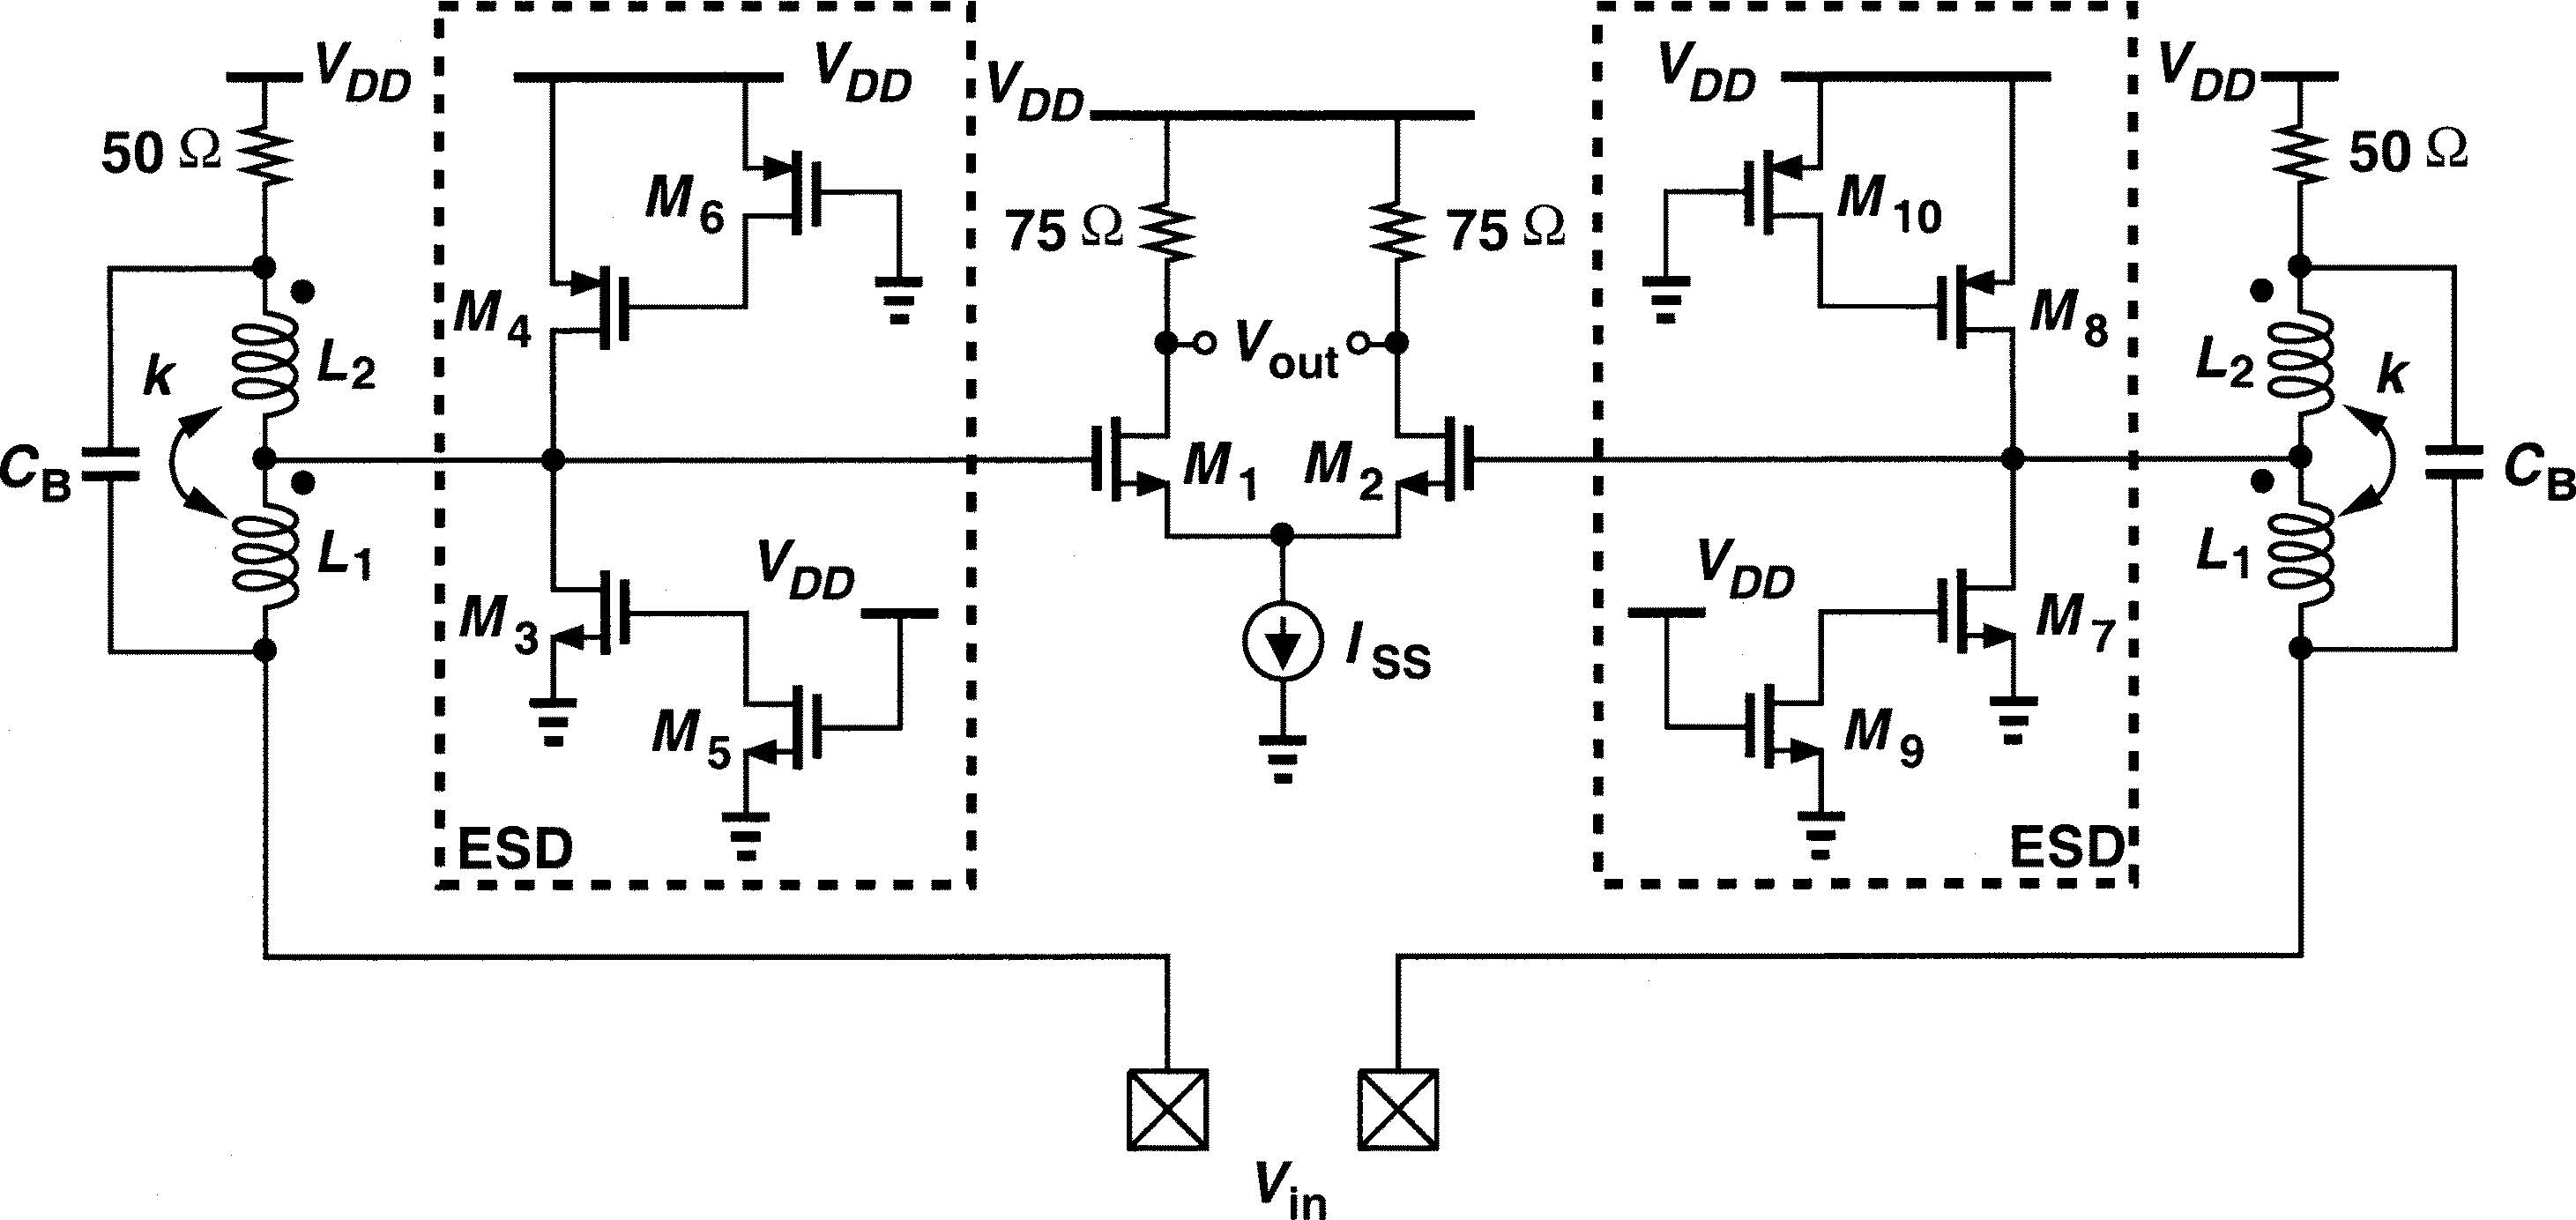
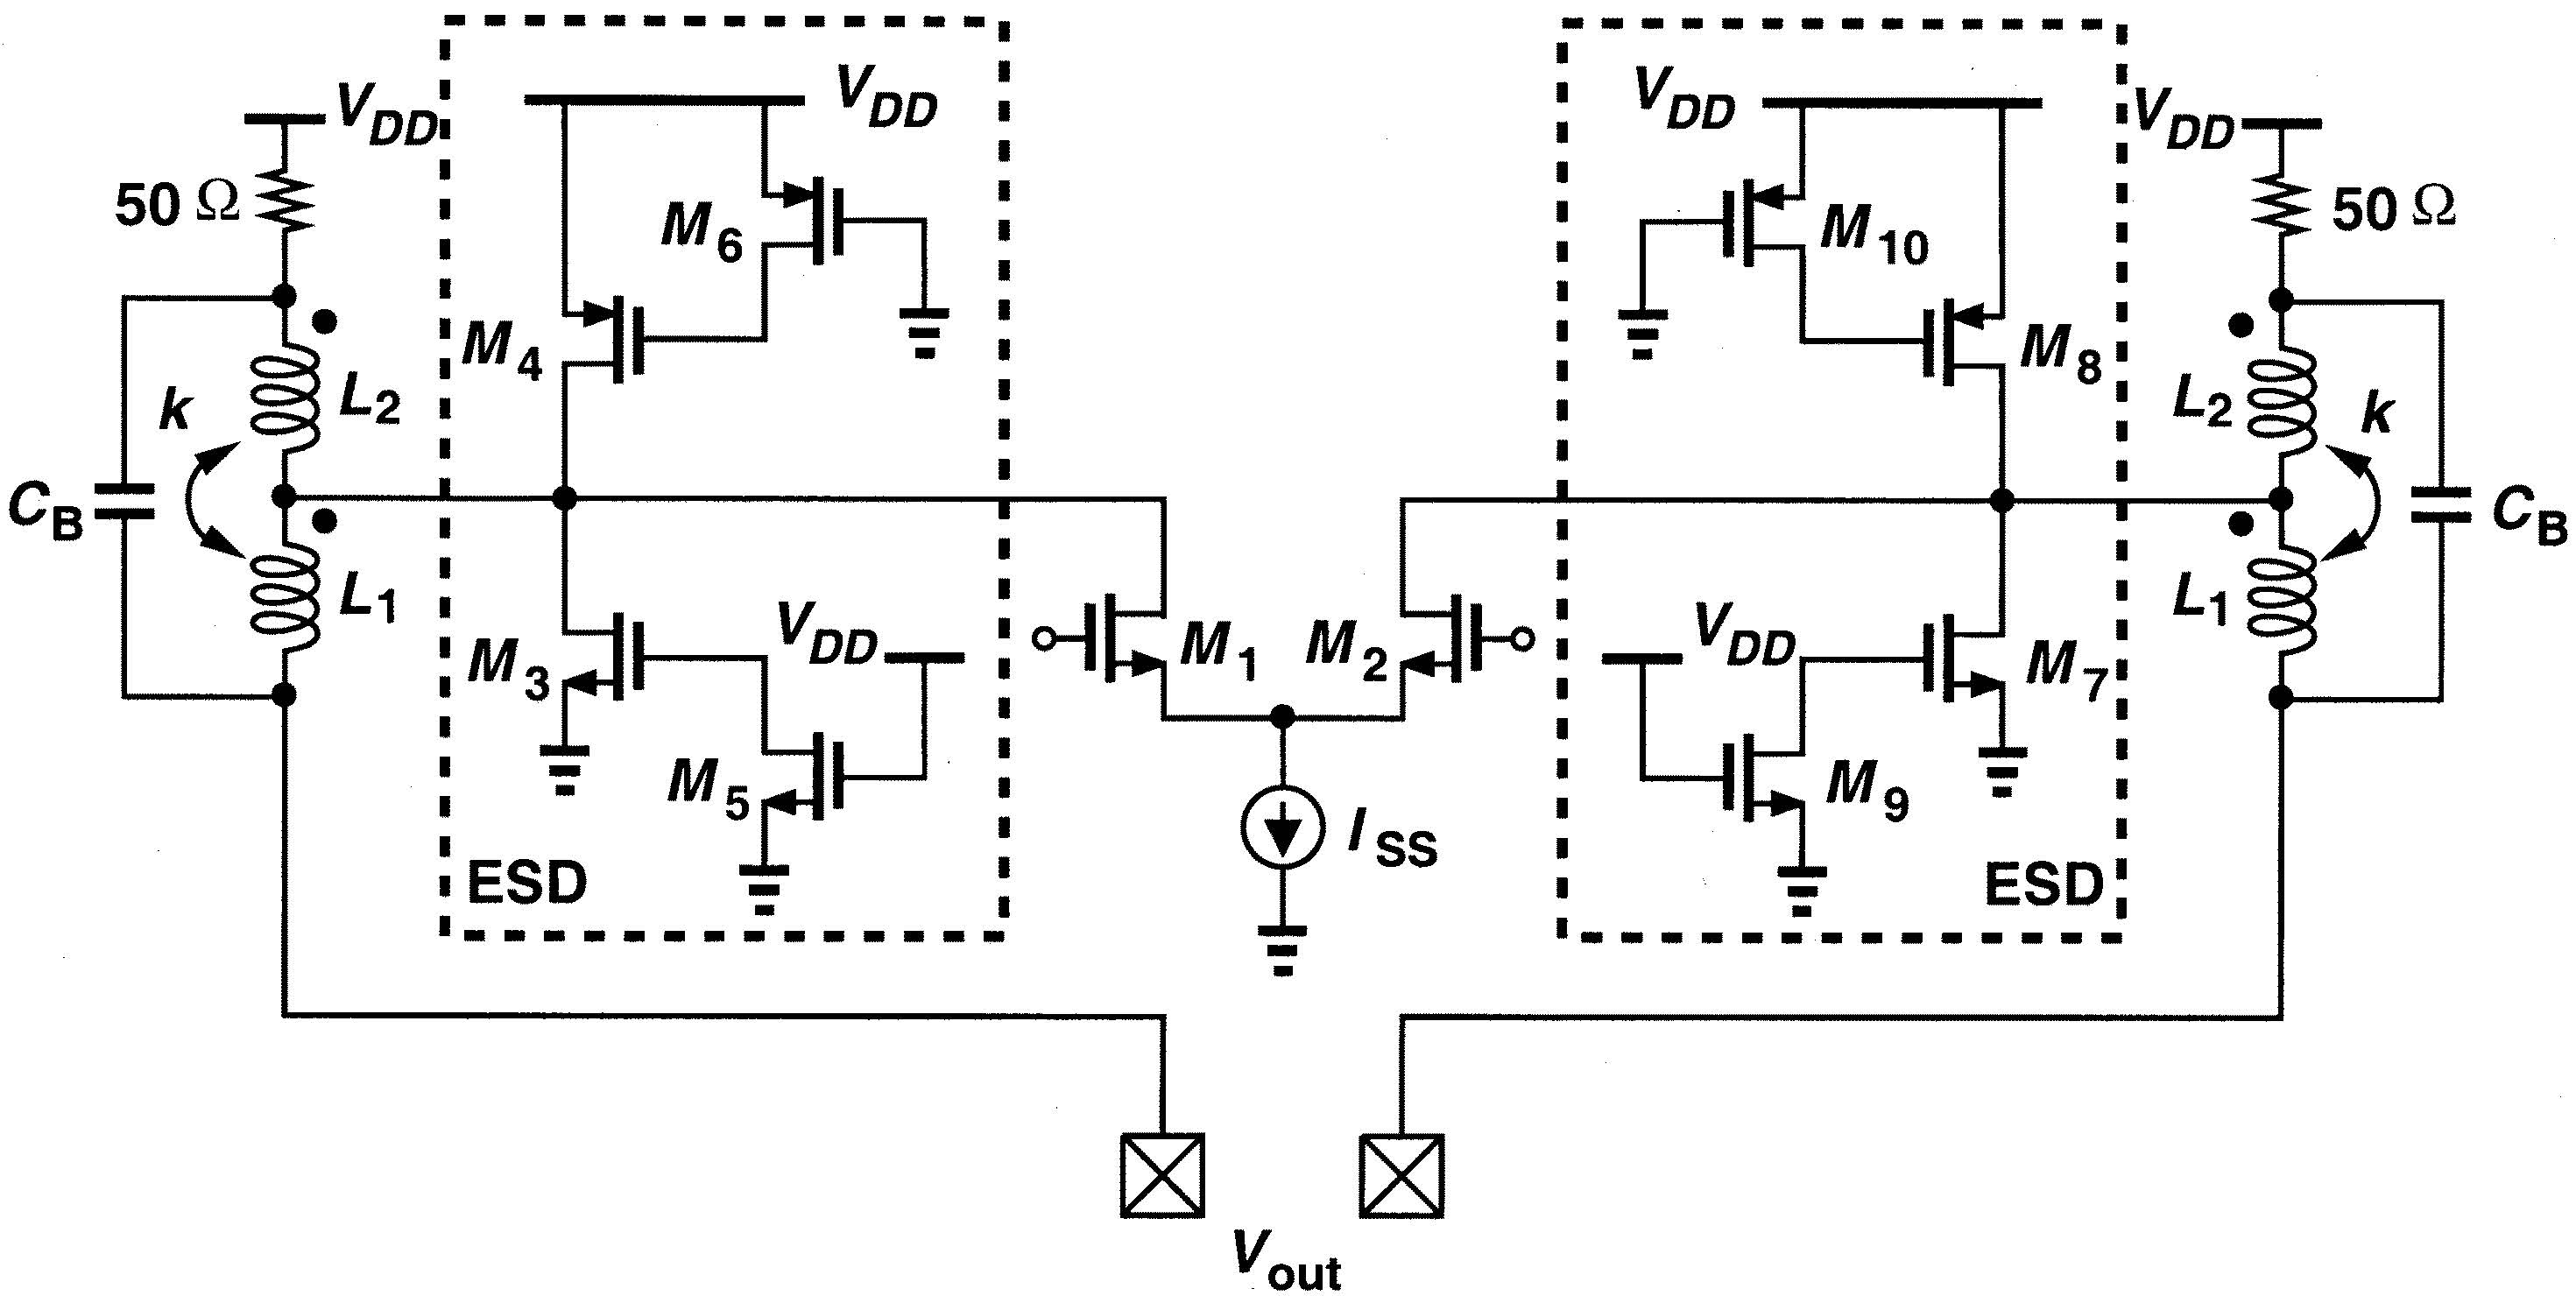

In real wireline driver design, active CML circuits structure is relatively fixed, which needs only some parameter scanning and experiential layout consideration. But it is not easy to manually tune all the T-coil to achieve ideal performance, thus inspired our AI-driven automatic passive-active co-design flow to design passive T-coil peaking structure for various given CML structures.

## T-coil Geometry Design

In real design, T-coil could be realized as a single inductor with proper center-tap somewhere. Divding single inductor into two will automatically create a positively coupled inductor pair. As a result, we first design a multi-layer multi-turn inductor and add center-tap in a particular inductor segment. IHP SG13G2 technology provides us with two think copper metals and five thin metals, so we use the top two metals for coil, Metal5 for feedline and Metal4 for ground shield. First coil turn is directly connected to the pad at TopMetal2, so coil segment 0~3 is at TopMetal2, coil segment 4~7 is at TopMetal1, and so on. Via arrays are utilized to connect adjacent two four-coil-segment groups.

For our structure, starting tap is desiged to be extended and connected to the pad, center tap is connected to main circuit plus ESD, while ending tap is connected to matching resistor to make two inductors in T-coil postively coupled. The detailed parameter constraints prohibiting structure overlapping and guaranteeing DRC compatiblility are not shown here. They could be found in following code.

| Name | Description | Unit | Range | Step |
|-----|-----|-----|-----|-----|
| pad_siz | Diameter of the regular octagon pad | µm | 50 | Fixed |
| Lext | Feedline expansion length | µm | 5 | Fixed |
| sizX | Horizontal length of first turn | µm | [20, 200] | 1 |
| sizY | Vertical length of first turn | µm | [20, 200] | 1 |
| wid | Width of all coil segments | µm | [3, 12] | 1 |
| gap | Distance between adjacent segment center line | µm | [6, 24] | 1 |
| total_seg | nummber of total segments | 1 | [2, 24] | 1 |
| tap_segid | # of segment that with T-coil center-tap | 1 | [0, total_seg) | 1 |
| tap_ratio | Percentage position of center tap | % | [30, 80] | Continuous |
| end_ratio | Percentage position of ending tap | % | [20, 80] | Continuous |
| ratio_firY | Percentage position of starting tap | % | [10, 90] | Continuous |

Here is an example layout including shield ground indicating the specific meaning of the certain parameters. Notice that some of the parameters are modified from original range for better demonstration.

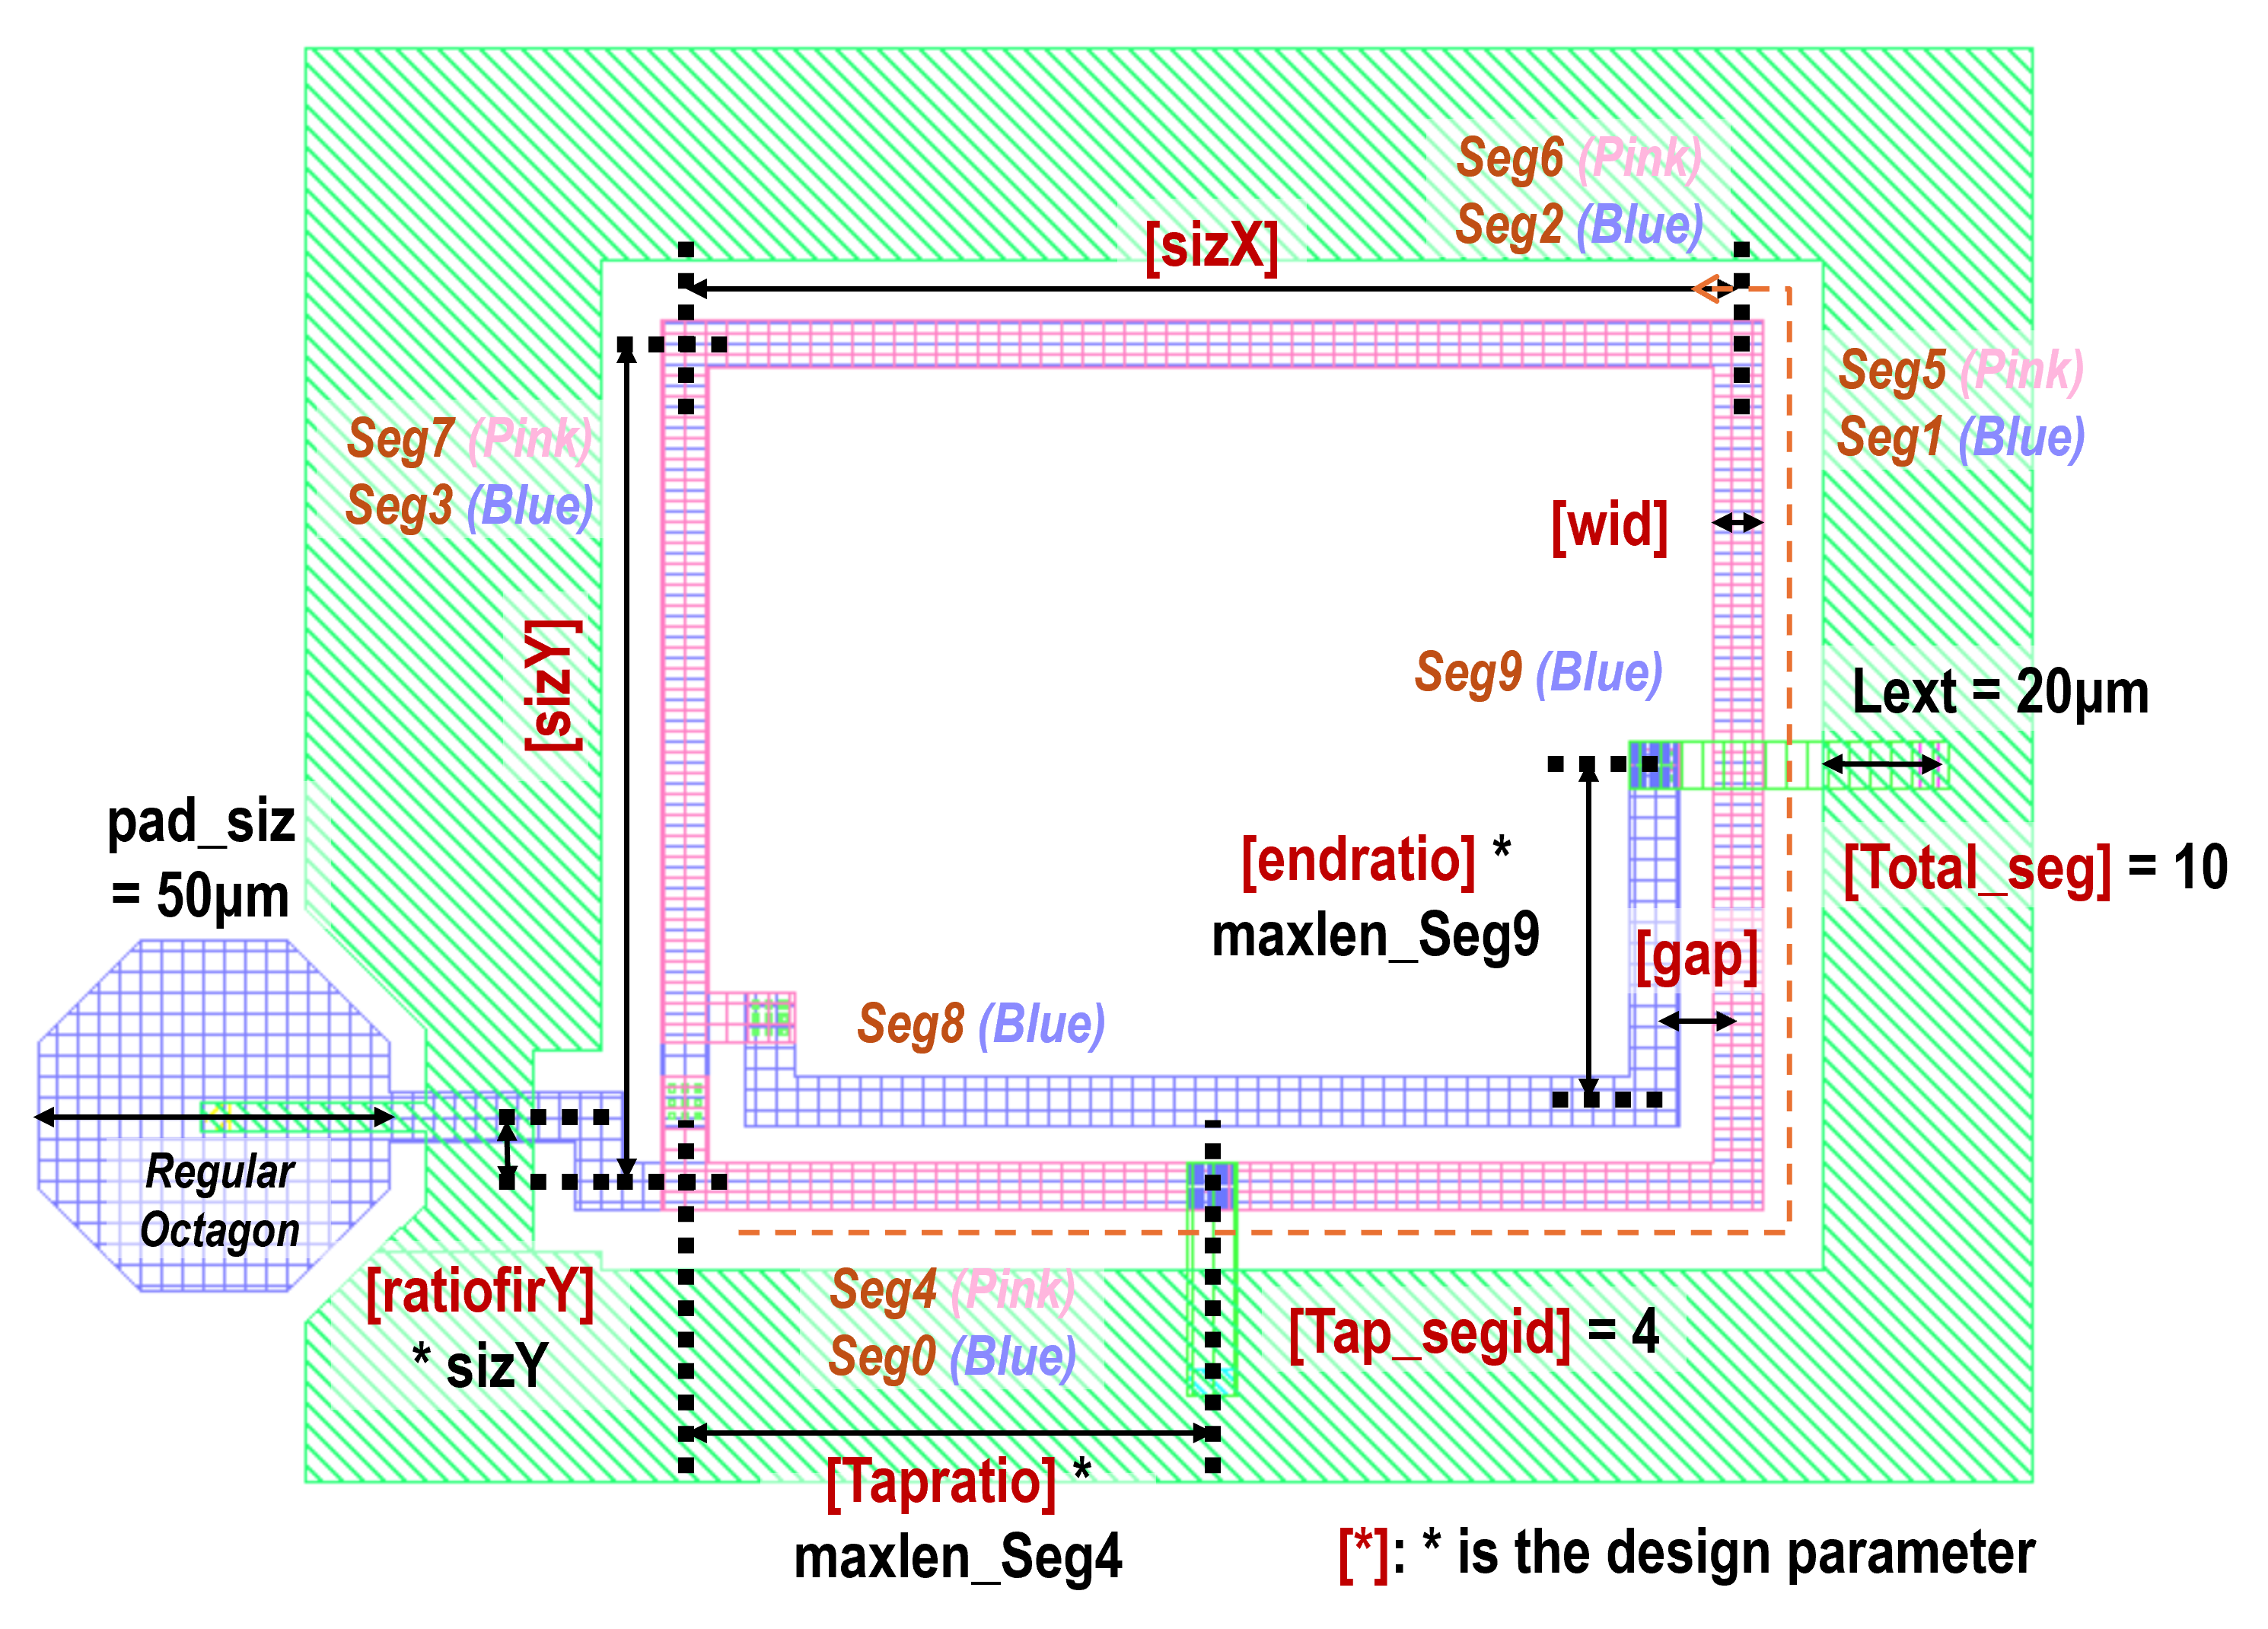

Our simulation is based on open-source FDTD EM simulator openEMS, which could be used as a python package. We first generate GDS files and then send it into our simulator. The simulator reads GDS file and XML technology file provided by foundry to start EM simulation.

In [ ]:
# Please save this part as a separate script named "tcoil_bias.py" in current running directory
# It contains functions to create T-Coil layout geometries using gdspy
# Running code within jupyter notebook is only for testing purpose
import gdspy
import math

default_pin_dt = 2 # Default: PIN DataType
thick_metal_list = [126, 134] # [Thick Metal 1, Thick Metal 2] DataType
v_thick = 133 # Via Thick Metal DataType, viasize = 0.9um, viaspace = 1.06um, enclosure = 0.5um
m5_metal = 67 # Metal 5 DataType
m4_metal = 50 # Metal 4 DataType
v_below = 125 # Via Below Metal DataType, viasize = 0.42um, viaspace = 0.42um, enclosure = 0.42um (TopMeetal1) / 0.1um (Metal5)
all_layers = thick_metal_list + [v_thick, m5_metal, v_below, m4_metal]
port_start = 200 # Starting port number
port_length = 4

# Create Via Array - Generic Function
def CreateViaArray(midX, midY, sizX, sizY, viasize = 0.9, viaspace = 1.06, enclosure = 0.5, layer = v_thick):
	""" Create Via Array within a defined rectangle area
	Args:
		midX, midY: Center coordinates of the rectangle area
		sizX, sizY: Size of the rectangle area
		viasize: Size of each via (default: 0.9um)
		viaspace: Spacing between vias (default: 1.06um)
		enclosure: Enclosure from the rectangle edge (default: 0.5um)
		layer: GDSII layer for the vias (default: v_thick)
	Returns:
		shape_list: List of via shapes (gdspy.Rectangle objects)
	"""
	shape_list = []
	num_viaX = int((sizX - 2*enclosure + viaspace) // (viasize + viaspace))
	num_viaY = int((sizY - 2*enclosure + viaspace) // (viasize + viaspace))
	startX = midX - (num_viaX * (viasize + viaspace) - viaspace) / 2 + viasize / 2
	startY = midY - (num_viaY * (viasize + viaspace) - viaspace) / 2 + viasize / 2
	for ix in range(num_viaX):
		for iy in range(num_viaY):
			via_centerX = startX + ix * (viasize + viaspace)
			via_centerY = startY + iy * (viasize + viaspace)
			shape_list.append(gdspy.Rectangle((via_centerX - viasize / 2, via_centerY - viasize / 2),
											 (via_centerX + viasize / 2, via_centerY + viasize / 2),
											 layer = layer, datatype = 0))
	return shape_list

# Combine all polygons in a specific layer into one polygon
def CombineLayer(cell, target_layer):
	""" Combine all polygons in a specific layer into one polygon
	Args:
		cell: gdspy Cell object containing the polygons
		target_layer: GDSII layer to be combined
	"""
	pr = cell.get_polygons((target_layer,0))
	if len(pr) == 0: return
	cell.remove_polygons(lambda pts, layer, datatype: layer == target_layer)
	all_poly = None
	# print("Combining layer:", target_layer, "with", len(pr), "polygons.")
	for cur in pr:
		all_poly = gdspy.boolean(all_poly,gdspy.Polygon(cur),"or",layer=target_layer,datatype=0)
	cell.add(all_poly)

# Create Ground Plane
def CreateGroundPlane(sizX, sizY, gap, gnd_expansion = 30, RealGndMetal = m4_metal):
	""" Create Ground Plane with an opening for the T-Coil
	Args:
		sizX, sizY: Size of the T-Coil area
		Lext: Extension length for ground plane beyond T-Coil area (default: 20um)
		gnd_expansion: Expansion size around the T-Coil area (default: 20um)
		RealGndMetal: GDSII layer for the ground plane (default: m4_metal)
	Returns:
		Ground plane polygon (gdspy.Polygon object)
	"""
	octagon = gdspy.Rectangle([-gap, -gap],[sizX + gap, sizY + gap])
	return gdspy.boolean(gdspy.Rectangle([-2 * gap - gnd_expansion, -gap - gnd_expansion],[sizX + gap + gnd_expansion, sizY + gap + gnd_expansion]),octagon,"not",layer=RealGndMetal,datatype=0)

# Create Octagon Points
def CreateOctagonPoints(midX, midY, siz):
	start_angle = math.pi / 8
	r = siz / 2 / math.cos(start_angle)
	points = []
	angle_increment = math.pi / 4
	for i in range(8):
		angle = start_angle + i * angle_increment
		x = midX + r * math.cos(angle)
		y = midY + r * math.sin(angle)
		points.append((x, y))
	return points

# Create Octagon Pad
def CreateOctagonPad(midX, midY, siz = 50, layer = thick_metal_list[1]):
	"""
	Creates a gdspy.Polygon object representing a regular octagon.

	The octagon is centered at (midX, midY) and has a 'diameter' (distance
	between opposite vertices) equal to 'siz'. The orientation is chosen
	so that two of the sides are horizontal.

	Args:
		midX: X-coordinate of the center.
		midY: Y-coordinate of the center.
		siz: Diameter (distance between opposite vertices) of the octagon.
		layer_num: GDSII layer number. Defaults to 0.

	Returns:
		A gdspy.Polygon object.
	"""
	points = CreateOctagonPoints(midX, midY, siz)
	octagon = gdspy.Polygon(points, layer=layer, datatype=0)
	return octagon

# Create T-Coil Trace - Vanilla Version (without no rotation and starts at (0,0))
def CreateTCoilTraceVanilla(wid, gap, sizX, sizY, firY, tapseg, nseg, tapratio, endratio, Lext = 20, ThickMetals = thick_metal_list, GndMetal = m5_metal, RealGndMetal = m4_metal, includepad = False):
	shape_list = []
	if includepad:
		pad_siz = 50
		shape_list.append(CreateOctagonPad(-gap - Lext - pad_siz / 2, firY, siz = pad_siz, layer = ThickMetals[1]))
		gnd_plane = gdspy.boolean(CreateGroundPlane(sizX, sizY, gap),CreateOctagonPad(-gap - Lext - pad_siz / 2, firY, siz = pad_siz + 10),"not",layer=RealGndMetal,datatype=0)
	else:
		gnd_plane = CreateGroundPlane(sizX, sizY, gap, RealGndMetal = RealGndMetal)
	shape_list.append(gdspy.FlexPath([(-gap-Lext, firY), (-gap, firY), (-gap, 0), (0, 0)], wid,
								  gdsii_path = True, layer = ThickMetals[1], datatype = 0).to_polygonset())
	gnd_plane = gdspy.boolean(gnd_plane,gdspy.FlexPath([(-gap - (gap + wid)/2, firY), (-gap, firY), (-gap, 0), (0, 0)], gap + wid, gdsii_path = True).to_polygonset(),"not",layer=RealGndMetal,datatype=0)
	shape_list.append(gnd_plane)
	# Create #1 port (PAD)
	if includepad:
		shape_list.append(gdspy.Rectangle((-gap - Lext - pad_siz / 2 - port_length / 2, firY - port_length / 2),(-gap - Lext - pad_siz / 2 + port_length / 2, firY + port_length / 2), layer = port_start + 1, datatype = 0))
		shape_list.append(gdspy.FlexPath([(-gap - Lext - pad_siz / 2 - port_length / 2, firY), (-gap - Lext + 10, firY)], port_length, gdsii_path = True, layer = RealGndMetal, datatype = 0).to_polygonset())
	else:
		shape_list.append(gdspy.FlexPath([(-gap-Lext, firY), (-gap-Lext+port_length, firY)], wid, gdsii_path = True, layer = port_start + 1, datatype = 0).to_polygonset())
	for tid in range(nseg):
		org_id_turn = tid // 4
		cur_metal = (org_id_turn + 1) % 2
		id_turn = org_id_turn // 2
		if tid == nseg - 1:
			match tid % 4:
				case 0: # Bottom horizontal
					if org_id_turn>0: shape_list += CreateViaArray(max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), org_id_turn*gap, wid, wid)
					startx, termix = max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), sizX-id_turn*gap
					tmp_list = [(max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), org_id_turn*gap+wid/2), (startx, id_turn*gap), (startx+(termix-startx)*endratio+wid/2, id_turn*gap)]
					lstx, lsty = tmp_list[-1]
					lstx -= wid/2
					shape_list.append(gdspy.FlexPath([(lstx,lsty+wid/2),(lstx,-Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
					port_loc = [(lstx,-Lext+port_length),(lstx,-Lext)]
				case 1: # Right vertical
					startx, termix = id_turn*gap, sizY-id_turn*gap
					tmp_list = [(sizX-id_turn*gap, -wid/2+startx), (sizX-id_turn*gap, wid/2+startx+(termix-startx)*endratio)]
					lstx, lsty = tmp_list[-1]
					lsty -= wid/2
					shape_list.append(gdspy.FlexPath([(lstx-wid/2,lsty),(sizX+Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
					port_loc = [(sizX+Lext-port_length,lsty),(sizX+Lext,lsty)]
				case 2: # Top horizontal
					startx, termix = sizX-id_turn*gap, id_turn*gap
					tmp_list = [(-wid/2+startx, sizY-id_turn*gap), (wid/2+startx+(termix-startx)*endratio, sizY-id_turn*gap)]
					lstx, lsty = tmp_list[-1]
					lstx += wid/2
					shape_list.append(gdspy.FlexPath([(lstx,lsty-wid/2),(lstx,sizY+Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
					port_loc = [(lstx,sizY+Lext-port_length),(lstx,sizY+Lext)]
				case 3: # Left vertical
					startx, termix = sizY-id_turn*gap, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap)
					tmp_list = [(id_turn*gap, wid/2+startx), (id_turn*gap, -wid/2+startx-(startx-termix)*endratio)]
					lstx, lsty = tmp_list[-1]
					lsty += wid/2
					shape_list.append(gdspy.FlexPath([(lstx+wid/2,lsty),(-Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
					port_loc = [(-Lext+port_length,lsty),(-Lext,lsty)]
			# Create #3 port (CIR)
			shape_list.append(gdspy.FlexPath(port_loc, wid, gdsii_path = True, layer = port_start + 3, datatype = 0).to_polygonset())
			shape_list += CreateViaArray(lstx, lsty, wid, wid, viasize = 0.42, viaspace = 0.42, enclosure = 0.1, layer = v_below)
			shape_list.append(gdspy.Rectangle((lstx - wid / 2, lsty - wid / 2), (lstx + wid / 2, lsty + wid / 2), layer = GndMetal, datatype = 0))
			if cur_metal == 1:
				shape_list += CreateViaArray(lstx, lsty, wid, wid)
				shape_list.append(gdspy.Rectangle((lstx - wid / 2, lsty - wid / 2), (lstx + wid / 2, lsty + wid / 2), layer = ThickMetals[0], datatype = 0))
		else:
			if tid == tapseg:
				flag_add_tap = False
				if cur_metal == 0 or cur_metal == 1 and id_turn == (nseg - 1) // 8 and nseg - 1 - tid < 4:
					flag_add_tap = True
					match tid % 4:
						case 0: # Bottom horizontal
							startx, termix = max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), sizX-id_turn*gap
							lstx, lsty = (startx+(termix-startx)*tapratio+wid/2, id_turn*gap)
							lstx -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty+wid/2),(lstx,-Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,-Lext+port_length),(lstx,-Lext)]
						case 1: # Right vertical
							startx, termix = id_turn*gap, sizY-id_turn*gap
							lstx, lsty = (sizX-id_turn*gap, wid/2+startx+(termix-startx)*tapratio)
							lsty -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx-wid/2,lsty),(sizX+Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(sizX+Lext-port_length,lsty),(sizX+Lext,lsty)]
						case 2: # Top horizontal
							startx, termix = sizX-id_turn*gap, id_turn*gap
							lstx, lsty = (wid/2+startx+(termix-startx)*tapratio, sizY-id_turn*gap)
							lstx += wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty-wid/2),(lstx,sizY+Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,sizY+Lext-port_length),(lstx,sizY+Lext)]
						case 3: # Left vertical
							startx, termix = sizY-id_turn*gap, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap)
							lstx, lsty = (id_turn*gap, -wid/2+startx-(startx-termix)*tapratio)
							lsty += wid/2
							shape_list.append(gdspy.FlexPath([(lstx+wid/2,lsty),(-Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(-Lext+port_length,lsty),(-Lext,lsty)]
				elif cur_metal == 1 and id_turn == 0:
					flag_add_tap = True
					match tid % 4:
						case 0: # Bottom horizontal
							startx, termix = max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), sizX-id_turn*gap
							lstx, lsty = (startx+(termix-startx)*tapratio+wid/2, id_turn*gap)
							lstx -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx,lsty-gap-wid/2)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lsty -= gap
							shape_list.append(gdspy.FlexPath([(lstx,lsty+wid/2),(lstx,-Lext-gap)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,-Lext-gap+port_length),(lstx,-Lext-gap)]
						case 1: # Right vertical
							startx, termix = id_turn*gap, sizY-id_turn*gap
							lstx, lsty = (sizX-id_turn*gap, wid/2+startx+(termix-startx)*tapratio)
							lsty -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx+gap+wid/2,lsty)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lstx += gap
							shape_list.append(gdspy.FlexPath([(lstx+wid/2,lsty),(sizX+Lext+gap,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(sizX+Lext+gap-port_length,lsty),(sizX+Lext+gap,lsty)]
						case 2: # Top horizontal
							startx, termix = sizX-id_turn*gap, id_turn*gap
							lstx, lsty = (wid/2+startx+(termix-startx)*tapratio, sizY-id_turn*gap)
							lstx += wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx,lsty+gap+wid/2)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lsty += gap
							shape_list.append(gdspy.FlexPath([(lstx,lsty+wid/2),(lstx,sizY+Lext+gap)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,sizY+Lext+gap-port_length),(lstx,sizY+Lext+gap)]
						case 3: # Left vertical
							startx, termix = sizY-id_turn*gap, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap)
							lstx, lsty = (id_turn*gap, -wid/2+startx-(startx-termix)*tapratio)
							lsty += wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx-gap-wid/2,lsty)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lstx -= gap
							shape_list.append(gdspy.FlexPath([(lstx-wid/2,lsty),(-Lext-gap,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(-Lext-gap+port_length,lsty),(-Lext-gap,lsty)]
				elif cur_metal == 1 and id_turn == (nseg - 1) // 8:
					flag_add_tap = True
					match tid % 4:
						case 0: # Bottom horizontal
							startx, termix = max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), sizX-id_turn*gap
							lstx, lsty = (startx+(termix-startx)*tapratio+wid/2, id_turn*gap)
							lstx -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx,lsty+gap+wid/2)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lsty += gap
							shape_list.append(gdspy.FlexPath([(lstx,lsty+wid/2),(lstx,-Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,-Lext+port_length),(lstx,-Lext)]
						case 1: # Right vertical
							startx, termix = id_turn*gap, sizY-id_turn*gap
							lstx, lsty = (sizX-id_turn*gap, wid/2+startx+(termix-startx)*tapratio)
							lsty -= wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx-gap-wid/2,lsty)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lstx -= gap
							shape_list.append(gdspy.FlexPath([(lstx-wid/2,lsty),(sizX+Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(sizX+Lext-port_length,lsty),(sizX+Lext,lsty)]
						case 2: # Top horizontal
							startx, termix = sizX-id_turn*gap, id_turn*gap
							lstx, lsty = (wid/2+startx+(termix-startx)*tapratio, sizY-id_turn*gap)
							lstx += wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx,lsty-gap-wid/2)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lsty -= gap
							shape_list.append(gdspy.FlexPath([(lstx,lsty-wid/2),(lstx,sizY+Lext)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(lstx,sizY+Lext-port_length),(lstx,sizY+Lext)]
						case 3: # Left vertical
							startx, termix = sizY-id_turn*gap, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap)
							lstx, lsty = (id_turn*gap, -wid/2+startx-(startx-termix)*tapratio)
							lsty += wid/2
							shape_list.append(gdspy.FlexPath([(lstx,lsty),(lstx+gap+wid/2,lsty)], wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
							lstx += gap
							shape_list.append(gdspy.FlexPath([(lstx+wid/2,lsty),(-Lext,lsty)], wid, gdsii_path = True, layer = GndMetal, datatype = 0).to_polygonset())
							port_loc = [(-Lext+port_length,lsty),(-Lext,lsty)]
				if flag_add_tap:
					# Create #2 port (TAP)
					shape_list.append(gdspy.FlexPath(port_loc, wid, gdsii_path = True, layer = port_start + 2, datatype = 0).to_polygonset())
					shape_list += CreateViaArray(lstx, lsty, wid, wid, viasize = 0.42, viaspace = 0.42, enclosure = 0.1, layer = v_below)
					shape_list.append(gdspy.Rectangle((lstx - wid / 2, lsty - wid / 2), (lstx + wid / 2, lsty + wid / 2), layer = GndMetal, datatype = 0))
					if cur_metal == 1:
						shape_list += CreateViaArray(lstx, lsty, wid, wid)
						shape_list.append(gdspy.Rectangle((lstx - wid / 2, lsty - wid / 2), (lstx + wid / 2, lsty + wid / 2), layer = ThickMetals[0], datatype = 0))
			match tid % 4:
				case 0: # Bottom horizontal
					if org_id_turn>0: shape_list += CreateViaArray(max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), org_id_turn*gap, wid, wid)
					tmp_list = [(max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), org_id_turn*gap+wid/2), (max(0,id_turn*2-1)*gap+(gap if id_turn>0 and cur_metal==0 else 0), id_turn*gap), (sizX+wid/2-id_turn*gap, id_turn*gap)]
				case 1: # Right vertical
					tmp_list = [(sizX-id_turn*gap, -wid/2+id_turn*gap), (sizX-id_turn*gap, sizY+wid/2-id_turn*gap)]
				case 2: # Top horizontal
					tmp_list = [(-wid/2+id_turn*gap, sizY-id_turn*gap), (sizX+wid/2-id_turn*gap, sizY-id_turn*gap)]
				case 3: # Left vertical
					tmp_list = [(id_turn*gap, sizY+wid/2-id_turn*gap), (id_turn*gap, -wid/2+id_turn*2*gap+(gap if cur_metal == 1 else 2*gap))]
					if org_id_turn > 0:
						tmp_list.pop()
						tmp_list += [(id_turn*gap, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap)), (org_id_turn*gap+wid/2, id_turn*2*gap+(gap if cur_metal == 1 else 2*gap))]
		shape_list.append(gdspy.FlexPath(tmp_list, wid, gdsii_path = True, layer = ThickMetals[cur_metal], datatype = 0).to_polygonset())
	return shape_list

In [ ]:
# If you have run the above part within a jupyter notebook, you can test the functions with the code below
# It can be removed when using the above functions in other scripts
# ----------------------------------------------------

# This commmand is used to fix a bug (otherwise restart is mandatory, causing low efficiency)
# Refer to: https://github.com/heitzmann/gdspy/issues/222
gdspy.library.use_current_library = False

# The GDSII file is called a library, which contains multiple cells.
lib = gdspy.GdsLibrary(name = 'tcoil_bias')
lib.precision = 5e-9 # DRC alignment requirements: usually 5nm

# Geometry must be placed in cells.
cell = lib.new_cell('test')
cell.add(CreateTCoilTraceVanilla(7, 12, 150, 120, 10, 4, 10, 0.5, 0.5, 30, includepad=True))
for layer in all_layers:
	CombineLayer(cell, layer)

# Display all cells using the internal viewer.
gdspy.LayoutViewer(lib, background = "#FFFFFF")

lib.write_gds('tcoil_bias_test.gds')
lib.remove(cell)

In [ ]:
# Please save this part as a separate script named "simulator_openems.py" in data_path and the code should not be run in the jupyter notebook
# The code serves as a simulator using openEMS python extension
# It includes command line argument parsing for data input and output paths, along with simulation folder management
import os
import sys
import argparse

# Parse control digits
parser = argparse.ArgumentParser("parser")
parser.add_argument('-g','--gds')
parser.add_argument('-s','--snp')
parser.add_argument('-x','--xml')
parser.add_argument('-m','--model')
parser.add_argument('-r','--script')
args = parser.parse_args()

sys.path.insert(0, os.path.abspath(os.path.join(args.script, 'modules')))

import modules.util_stackup_reader as stackup_reader
import modules.util_gds_reader as gds_reader
import modules.util_utilities as utilities
import modules.util_simulation_setup as simulation_setup
import modules.util_meshlines as util_meshlines

from openEMS import openEMS
import numpy as np
import matplotlib.pyplot as plt

# ======================== workflow settings ================================

# preview model/mesh only?
# postprocess existing data without re-running simulation?
preview_only = False    
postprocess_only = False

# ===================== input files and path settings =======================

gds_filename = args.gds           # geometries
XML_filename = args.xml               # stackup

# preprocess GDSII for safe handling of cutouts/holes?
preprocess_gds = True

# merge via polygons with distance less than .. um, set 0 to disable via merging
merge_polygon_size = 1.5

# get path for this simulation file
script_path = args.script

# use script filename as model basename
model_basename = args.model

# set and create directory for simulation output
# sim_path = os.path.join(script_path, 'sim_temp', model_basename + '_sim')
sim_path = os.path.join('/tmp/ray_cache', model_basename + '_sim')
print('Simulation data directory: ', sim_path)

# change current path to model script path
os.chdir(script_path)

# ======================== simulation settings ================================

unit   = 1e-6   # geometry is in microns
margin = 200    # distance in microns from GDSII geometry boundary to simulation boundary 

fstart = 0
fstop  = 100e9
numfreq = 1001

refined_cellsize = 1.0  # mesh cell size in conductor region

# choices for boundary: 
# 'PEC' : perfect electric conductor (default)
# 'PMC' : perfect magnetic conductor, useful for symmetries
# 'MUR' : simple MUR absorbing boundary conditions
# 'PML_8' : PML absorbing boundary conditions
Boundaries = ['PEC', 'PEC', 'PEC', 'PEC', 'PEC', 'PEC']

cells_per_wavelength = 20   # how many mesh cells per wavelength, must be 10 or more
energy_limit = -50          # end criteria for residual energy (dB)

# ports from GDSII Data, polygon geometry from specified special layer
# note that for multiport simulation, excitations are switched on/off in simulation_setup.createSimulation below
simulation_ports = simulation_setup.all_simulation_ports()
# instead of in-plane port specified with target_layername, we here use via port specified with from_layername and to_layername
simulation_ports.add_port(simulation_setup.simulation_port(portnumber=1, voltage=1, port_Z0=50, source_layernum=201, from_layername='Metal4', to_layername='TopMetal2', direction='z'))
# simulation_ports.add_port(simulation_setup.simulation_port(portnumber=1, voltage=1, port_Z0=50, source_layernum=201, from_layername='SUBGND', to_layername='TopMetal2', direction='z'))
simulation_ports.add_port(simulation_setup.simulation_port(portnumber=2, voltage=1, port_Z0=50, source_layernum=202, from_layername='Metal4', to_layername='Metal5', direction='z'))
simulation_ports.add_port(simulation_setup.simulation_port(portnumber=3, voltage=1, port_Z0=50, source_layernum=203, from_layername='Metal4', to_layername='Metal5', direction='z'))

# ======================== simulation ================================

# get technology stackup data
materials_list, dielectrics_list, metals_list = stackup_reader.read_substrate (XML_filename)
# get list of layers from technology
layernumbers = metals_list.getlayernumbers()
layernumbers.extend(simulation_ports.portlayers)

# read geometries from GDSII, only purpose 0
allpolygons = gds_reader.read_gds(gds_filename, layernumbers, purposelist=[0], metals_list=metals_list, preprocess=preprocess_gds, merge_polygon_size=merge_polygon_size)


# calculate maximum cellsize from wavelength in dielectric
wavelength_air = 3e8/fstop / unit
max_cellsize = (wavelength_air)/(np.sqrt(materials_list.eps_max)*cells_per_wavelength)

########### create model, run and post-process ###########

FDTD = openEMS(EndCriteria=np.exp(energy_limit/10 * np.log(10)))
FDTD.SetGaussExcite( (fstart+fstop)/2, (fstop-fstart)/2 )
FDTD.SetBoundaryCond( Boundaries )


# Create simulation for port 1 and 2 excitation, return value is list of data paths, one for each excitation
data_paths = []
for excite_ports in [[1],[2],[3]]:  # list of ports that are excited one after another
	FDTD = simulation_setup.setupSimulation (excite_ports, 
											 simulation_ports, 
											 FDTD, 
											 materials_list, 
											 dielectrics_list, 
											 metals_list, 
											 allpolygons, 
											 max_cellsize, 
											 refined_cellsize, 
											 margin, 
											 unit, 
											 xy_mesh_function=util_meshlines.create_xy_mesh_from_polygons)

	data_paths.append(simulation_setup.runSimulation (excite_ports, FDTD, sim_path, model_basename, preview_only, postprocess_only))

if preview_only==False:

	print('Begin data evaluation')

	# define dB function for S-parameters
	def dB(value):
		return 20.0*np.log10(np.abs(value))        

	# define phase function for S-parameters
	def phase(value):
		return np.angle(value, deg=True) 

	f = np.linspace(fstart,fstop,numfreq)

	# get results, CSX port definition is read from simulation ports object
	# Snm is available because we have simulated both porti excitation
	snm = np.zeros((3,3,numfreq), dtype=complex)
	for i in range(3):
		for j in range(3):
			snm[i,j] = utilities.calculate_Sij (i+1, j+1, f, sim_path, simulation_ports)

	utilities.write_snp (snm,f, args.snp)


## Massive Data Generation

EM simulation is time-consuming, so we want to build a AI-driven surrogate model to replace it. Prior to such surrogate model, we must have lots of data preparing for the model training. To generate large amount of EM data, one machine is far from enough due to long simulation time. Therefore, a framework for distributed simulation is needed. In this case, we choose ray to distribute thousands of simulation tasks to tens of servers in order to accelerate the paralle data generation.

### Distributed Simulation Instruction

Make sure start head ray server and add several worker machines behind to build a simulation cluster.

Run this on head machine.

```
ray start --head --port=6379
```

Run this on worker machines (replace head-node-address:port with yours).

```
ray start --address=<head-node-address:port>
```

In [ ]:
# Generate parametric batch samples
import gdspy
import tcoil_bias as tcoil
import cairosvg
import os
import random
import threading
end_num = 5000

data_path = '/scratch2/Data_EMX_Ray_Distributed_Computing/TCoil_3P_IHP13_Oct2025/'
# This commmand is used to fix a bug (otherwise restart is mandatory, causing low efficiency)
# Refer to: https://github.com/heitzmann/gdspy/issues/222
gdspy.library.use_current_library = False

# The GDSII file is called a library, which contains multiple cells.
lib = gdspy.GdsLibrary(name = 'BatchGen_XFMR11')
lib.precision = 5e-9 # DRC alignment

def one_sample(index, tid):
	# Geometry must be placed in cells.
	cell = lib.new_cell(str(index))
	while True:
		wid = random.randint(3,12)
		gap = wid + random.randint(3,12)
		nseg = random.randint(0,5) * 4 + 2
		tapseg = random.randint(0, nseg // 4) * 4 + 0
		nturn = (nseg - 1) // 8 + 1
		# For Tapseg Check
		cur_metal = ((tapseg // 4) + 1) % 2
		id_turn = tapseg // 8
		if not (cur_metal == 0 or cur_metal == 1 and (id_turn == (nseg - 1) // 8 and nseg - 1 - tapseg < 4 or id_turn == 0 or id_turn == (nseg - 1) // 8)):
			continue
		# Tapseg Check End
		sizX = 3 * (nturn * gap) + wid + random.randint(0, 100)
		sizY = 3 * (nturn * gap) + wid + random.randint(0, 100)
		tapratio = random.uniform(0.3,0.8)
		endratio = random.uniform(0.2,0.8)
		firYratio = random.uniform(0.1,0.9)
		firY = int(sizY * firYratio)
		Lext = gap + 5
		break
	if gds_lock.acquire():
		cell.add(tcoil.CreateTCoilTraceVanilla(wid, gap, sizX, sizY, firY, tapseg, nseg, tapratio, endratio, Lext=Lext, includepad=True))
		for layer in tcoil.all_layers:
			tcoil.CombineLayer(cell, layer)
		gds_lock.release()

	# For figure generation (used in CNN training)
	cell.write_svg('SVG_TEMP/XFMR11'+str(tid)+'.svg')
	svg_data = open('SVG_TEMP/XFMR11'+str(tid)+'.svg','r').read()
	png_name = data_path + 'PNG/'+str(index)+'.png'
	cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to=png_name, scale = 0.1)

	# Save the library in a file.
	gds_name = data_path + 'GDS/'+str(index)+'.gds'
	lib.write_gds(gds_name,[cell])

	if log_lock.acquire():
		log_file = open(data_path + f'INFO/{index}.log', 'w')
		log_file.write(str([wid, gap, sizX, sizY, firY, tapseg, nseg, tapratio, endratio]))
		log_file.close()
		lib.remove(cell)
		log_lock.release()


gds_lock = threading.Lock()
cur_lock = threading.Lock()
log_lock = threading.Lock()

for index in range(end_num):
	if index % 100 == 0:
		print("Generating sample:", index)
	one_sample(index, 0)

In [ ]:
# Please save this part as a separate script named "emx_sim.py" in data_path and run "python emx_sim.py" there to execute the distributed simulations
# It will invoke the simulator_openems.py script for each sample in parallel using Ray
# It takes up to approx. 3~4 days to finish 5,000 simulation samples on a 1024-core cluster
import ray
import os

ray.init("auto")

@ray.remote(num_cpus=8)
def emx_task(index):
    data_path = '/scratch2/Data_EMX_Ray_Distributed_Computing/TCoil_3P_IHP13_Oct2025'
    os.system(f"python {data_path}/simulator_openems.py -g {data_path}/GDS/{index}.gds -s {data_path}/SPData/{index}.s3p -x {data_path}/SG13G2.xml -m {index} -r {data_path} > {data_path}/EMLOG/{index}.log")
    # os.system(f"rm -rf {data_path}/sim_temp/{index}_sim")
    os.system(f"rm -rf /tmp/ray_cache/{index}_sim")
    return os.path.exists(f"{data_path}/SPData/{index}.s3p")

start_id = 0
end_num = 5000
emx_results = [emx_task.remote(i) for i in range(start_id, end_num)]

emx_values = ray.get(emx_results)

fi = open('Failed_List.txt', 'a')
for i, v in enumerate(emx_values, start_id):
    if not v: fi.write(str(i) + '\n')
fi.close()

print("Done")

Our workflow could generate roughly 5000 randomized different T-coil structure based on our geometric parameter mentioned before. Here are some examples of our generated GDS layout.

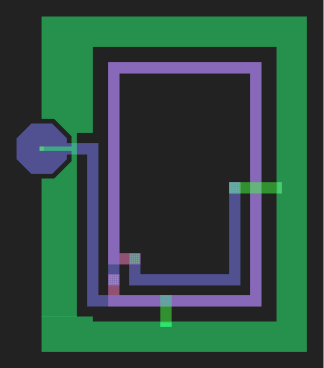

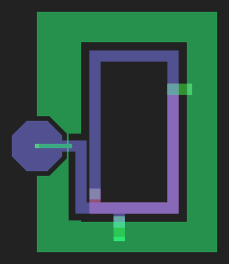

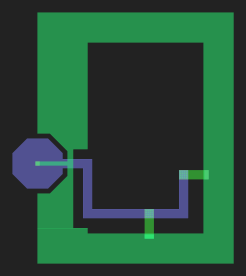

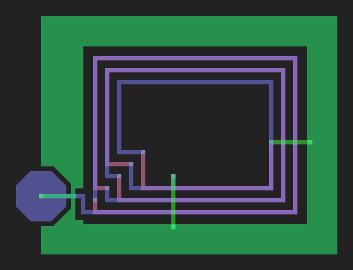

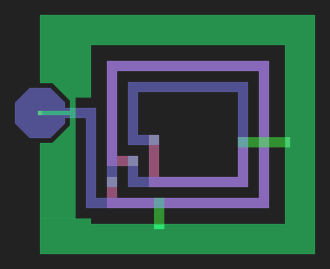

In [ ]:
# Get some generated images for visualization
from IPython.display import Image, display
import os
path = '/scratch2/Data_EMX_Ray_Distributed_Computing/TCoil_3P_IHP13_Oct2025/'
for i in range(10, 15):
	img_path = os.path.join(path, "PNG", f"{i}.png")
	display(Image(filename=img_path))

## ANN Design and Training for EM Prediction

To build a efficient model to replace costly EM simulation for faster inverse design, we designed a simplest 5-layer multilayer perception machine (MLP) as a balance between efficiency and accuracy. The structure of our MLP network is shown below. We first normalize 9 geometric parameters to [-1, 1], then use MLP as a EM predictor to output 1818-demensional vector. This vector contains all messages used in a S3P, which contains 101 frequency points (0~100GHz, with 1GHz step), and should be recovered to a complex S3P file later. Our 5-layer MLP operates with float32, and total number of model parameters is less than 10M, which is a very tiny model with high quite inference efficiency.

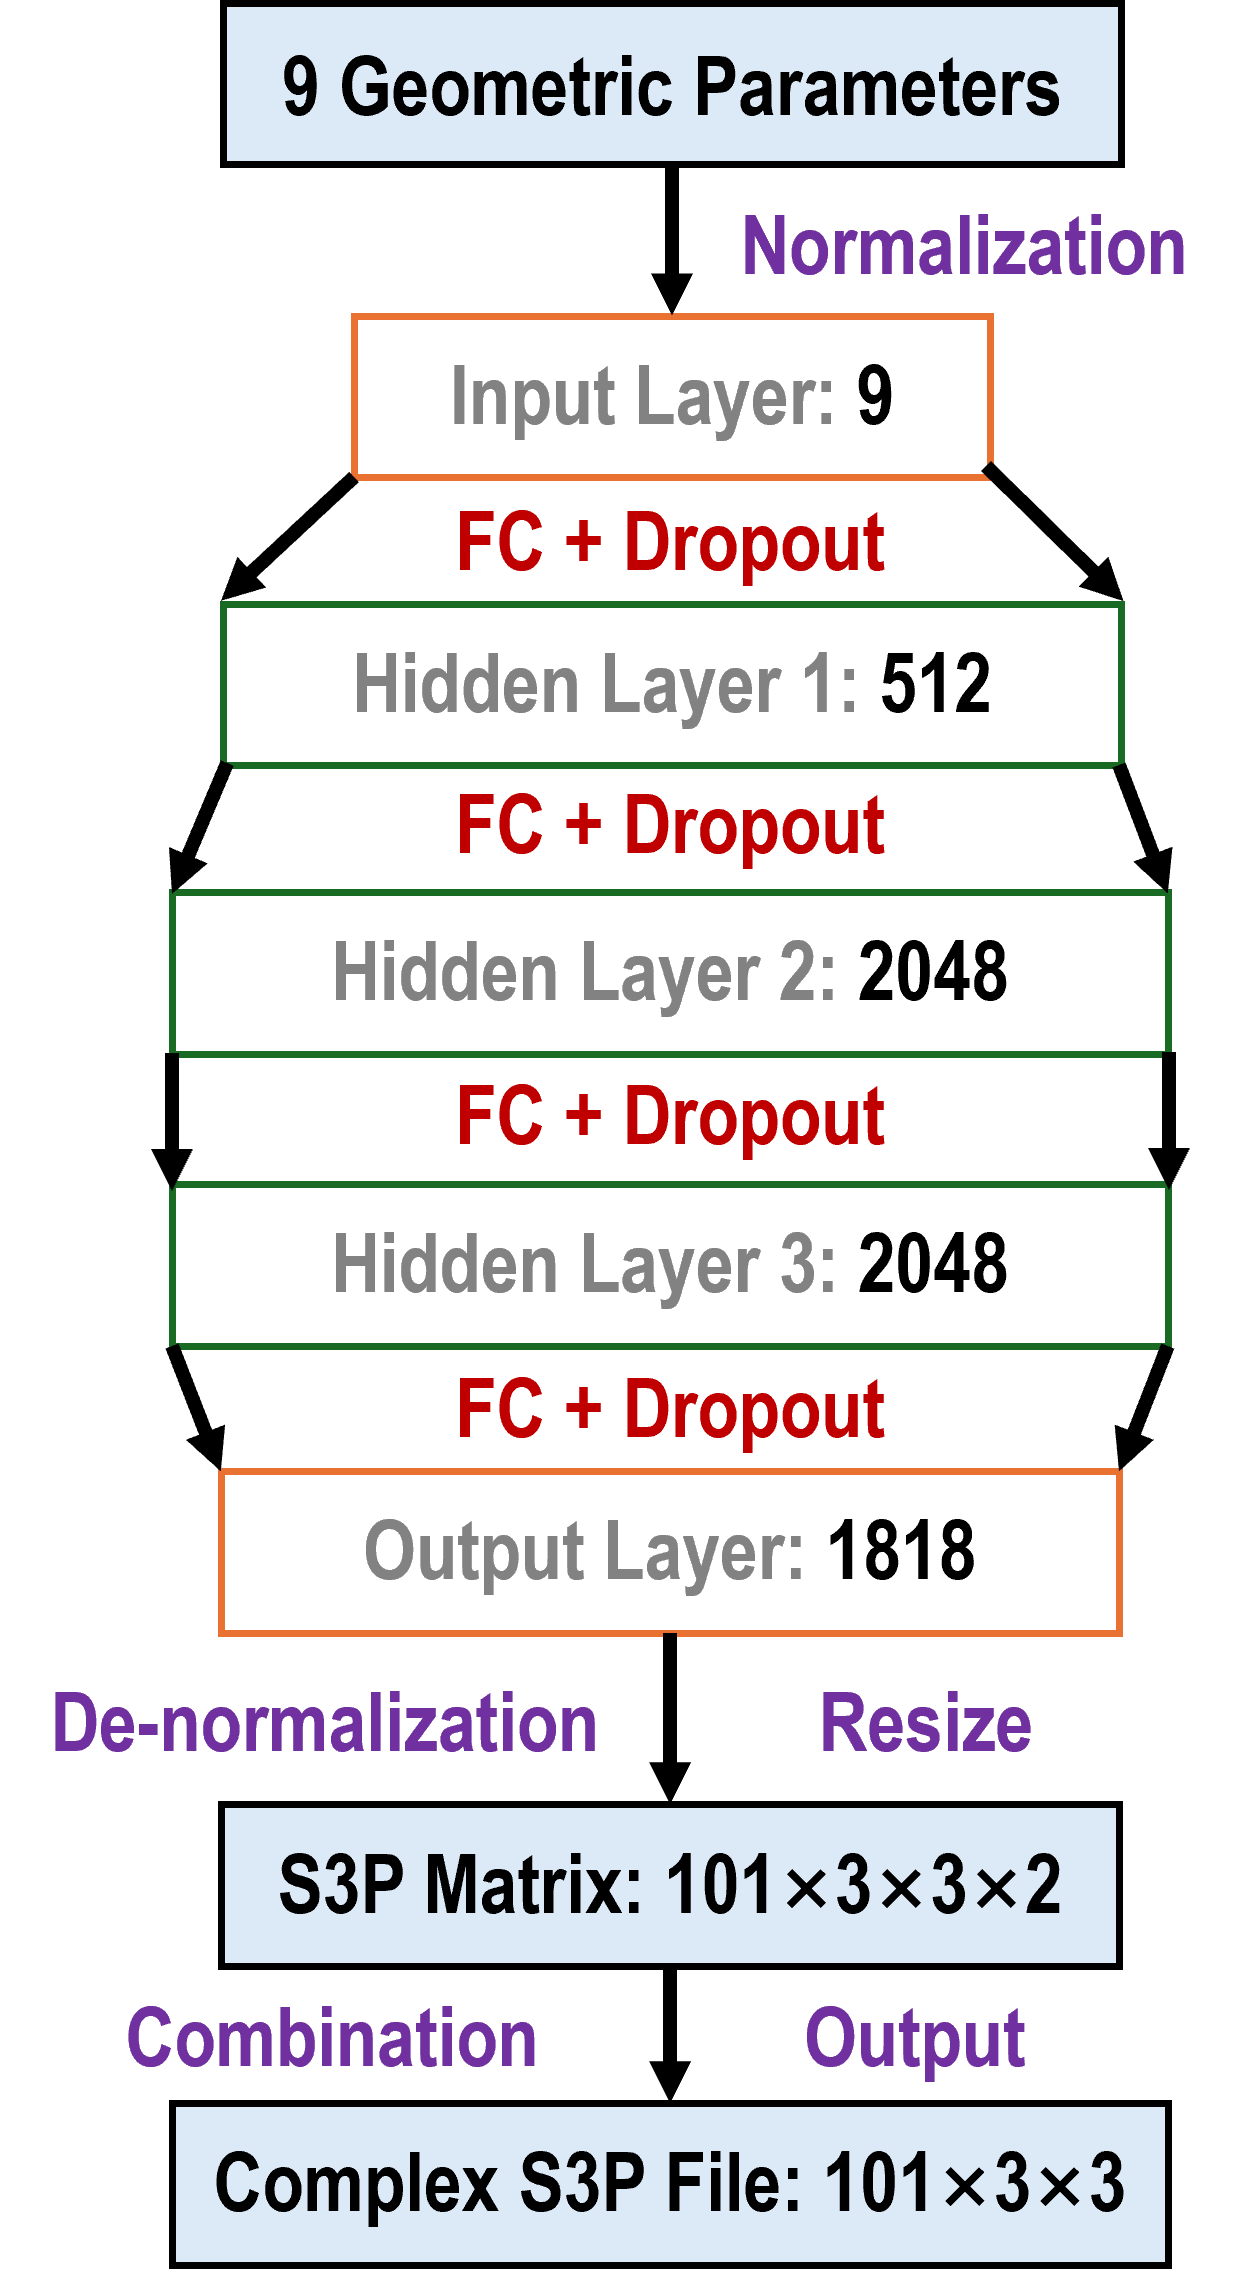

We randomly divide our original data into 3 parts: training, validation and testing; and use single CUDA GPU to train our model under torch framework. A classical AdamW optimizer is used with proper settings. The model realize a final MAE to ~0.045, indicating a great accuracy in S-parameter prediction.

In [ ]:
# Ensure all necessary imports are included
import skrf as rf
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import os
import ast

In [ ]:
# choose device: prefer GPU (CUDA) if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
n_freq = 101
original_freq = 1001
step_freq = 10
n_ports = 3
geo_size = 9
final_layer_size = n_freq * n_ports * n_ports * 2  # 2 for real and imaginary parts
data_path = '/scratch2/Data_EMX_Ray_Distributed_Computing/TCoil_3P_IHP13_Oct2025/'
n_data = 5000  # total number of data samples
frequency_upbound = 100e9  # upper frequency limit for S-parameters
torch.manual_seed(42)

In [ ]:
def load_geometry(file_path):
	"""Load geometry parameters from a .log file."""
	if not os.path.exists(file_path):
		return None
	fi = open(file_path, 'r')
	lines = fi.readlines()
	fi.close()
	return np.array(ast.literal_eval(lines[0]))

def load_sparameters(file_path):
	"""Load S-parameters from a Touchstone file and convert it into real array."""
	if not os.path.exists(file_path):
		return None
	ntwk = rf.Network(file_path)
	for k in range(0, original_freq, step_freq):
		s_flatten = ntwk.s[k].flatten()
		s_real_imag = np.concatenate((s_flatten.real, s_flatten.imag))
		if k == 0:
			s_params = s_real_imag
		else:
			s_params = np.concatenate((s_params, s_real_imag))
	return s_params

def normalize_array_columnwise(arr):
	"""
	Normalizes a NumPy array (n x d) column-wise to the range [0, 1].
	Each of the 'd' features is normalized independently.

	Formula (applied per column/feature): (v - min_col) / (max_col - min_col)

	Args:
		arr: A NumPy array of shape (n, d), where n is the number of samples
			 and d is the number of features/dimensions.

	Returns:
		A tuple containing:
		1. The array of maximum values (size d), one for each column.
		2. The array of minimum values (size d), one for each column.
		3. The normalized NumPy array (n x d) with values between 0 and 1.
	"""
	# Calculate the minimum and maximum for EACH column (axis=0)
	arr_min = np.min(arr, axis=0) # Shape (d,)
	arr_max = np.max(arr, axis=0) # Shape (d,)
	
	# Calculate the range for each column
	data_range = arr_max - arr_min # Shape (d,)
	
	# Handle the edge case where a column has zero range (all values are the same)
	# This prevents ZeroDivisionError. Where data_range is 0, we use a small value (1) 
	# for division, which ensures (arr - arr_min) / 1 results in 0.
	# The result for that column will be an array of zeros.
	# np.where() is used here for a safe division.
	safe_data_range = np.where(data_range == 0, 1.0, data_range)
	
	# Apply the Min-Max normalization formula.
	# NumPy's broadcasting handles the array subtraction and division efficiently.
	normalized_arr = (arr - arr_min) / safe_data_range * 2 - 1  # Scale to [-1, 1]

	return arr_max, arr_min, normalized_arr

In [ ]:
geo_data_raw = []
sparam_data_raw = []

for i in range(n_data):
	geo_file = data_path + f'INFO/{i}.log'
	sparam_file = data_path + f'SPData/{i}.s3p'
	
	geo_params = load_geometry(geo_file)
	s_params = load_sparameters(sparam_file)
	
	if geo_params is not None and s_params is not None:
		geo_data_raw.append(geo_params)
		sparam_data_raw.append(s_params)

geo_data_raw = np.array(geo_data_raw)
sparam_data_raw = np.array(sparam_data_raw)
print("Geometry data shape:", geo_data_raw.shape)
print("S-parameter data shape:", sparam_data_raw.shape)

gen_max, gen_min, geo_data_normalized = normalize_array_columnwise(geo_data_raw)
sparam_max, sparam_min, sparam_data_normalized = normalize_array_columnwise(sparam_data_raw)

Geometry data shape: (4993, 9)
S-parameter data shape: (4993, 1818)


In [ ]:
print("Geometry data normalized. Max:", gen_max, "Min:", gen_min)
print("S-parameter data normalized. Max:", sparam_max, "Min:", sparam_min)

Geometry data normalized. Max: [ 12.          24.         326.         317.         264.
  20.          22.           0.79986058   0.79980308] Min: [ 3.          6.         29.         25.          2.          0.
  2.          0.3000558   0.20002252]
S-parameter data normalized. Max: [0.1579359 0.9752869 0.6549429 ... 0.395388  0.2873991 0.7446869] Min: [-3.115865e-01  4.936607e-01 -4.181076e-04 ... -7.254242e-01 -8.667540e-01
 -9.373864e-01]


In [ ]:
class NumpyMultiTargetDataset(Dataset):
	"""
	Custom Dataset to accept and process NumPy arrays for features and targets.
	"""
	def __init__(self, features_np: np.ndarray, targets_np: np.ndarray):
		# Convert NumPy arrays to PyTorch Float Tensors immediately
		# float32 is the standard type for model inputs/targets
		self.features = torch.from_numpy(features_np).float()
		self.targets = torch.from_numpy(targets_np).float()
		
	def __len__(self):
		# The number of samples (10000)
		return len(self.targets)
		
	def __getitem__(self, idx):
		# Returns the features and targets for a single sample index
		return self.features[idx], self.targets[idx]

def get_dataloaders(dataset, train_ratio, val_ratio, batch_size):
	total_size = len(dataset)
	train_size = int(train_ratio * total_size)
	val_size = int(val_ratio * total_size)
	test_size = total_size - train_size - val_size
	
	# Split data into three subsets
	train_subset, val_subset, test_subset = random_split(
		dataset, [train_size, val_size, test_size]
	)
	
	# Create DataLoaders
	train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
	test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False) # <--- Test Loader added
	
	return train_loader, val_loader, test_loader

In [ ]:
class DeeperMLP(nn.Module):
	"""
	A deeper Multi-Layer Perceptron with two hidden layers of size 2048.
	Input: 9, Output: 1818.
	"""
	def __init__(self, input_size: int = geo_size, output_size: int = final_layer_size):
		super(DeeperMLP, self).__init__()
		
		# Define the sizes of the hidden layers
		hidden_size_1 = 512
		hidden_size_2 = 2048
		hidden_size_3 = 2048
		
		# Layer 1: Input (9) -> Hidden (512)
		self.fc1 = nn.Linear(input_size, hidden_size_1)
		
		# Layer 2: Hidden (512) -> Hidden (2048)
		self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
		
		# Layer 3: Hidden (2048) -> Hidden (2048)
		self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
		
		# Layer 4: Hidden (2048) -> Output (1818)
		self.fc4 = nn.Linear(hidden_size_3, output_size)
		
		# Optional: Add Dropout for regularization
		self.dropout = nn.Dropout(p=0.5)

	def forward(self, x):
		"""
		Defines the forward pass of the network.
		"""
		# 1. FC1 -> ReLU -> Dropout
		x = F.relu(self.fc1(x))
		x = self.dropout(x)
		
		# 2. FC2 -> ReLU -> Dropout
		x = F.relu(self.fc2(x))
		x = self.dropout(x)
		
		# 3. FC3 (NEW LAYER) -> ReLU -> Dropout
		x = F.relu(self.fc3(x))
		x = self.dropout(x)
		
		# 4. FC4 (Output Layer)
		x = self.fc4(x)
		
		return x

In [ ]:
NUM_EPOCHS = 2000
BATCH_SIZE = 64
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4 # Standard value for L2 regularization in AdamW
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

In [ ]:
model = DeeperMLP(geo_size, final_layer_size).to(device)
full_dataset = NumpyMultiTargetDataset(
	features_np=geo_data_normalized,
	targets_np=sparam_data_normalized
)
train_loader, val_loader, test_loader = get_dataloaders(
	full_dataset, TRAIN_RATIO, VAL_RATIO, BATCH_SIZE
)

# Loss function: Mean Absolute Error (L1 Loss) for regression
criterion = nn.L1Loss()
# Optimizer: AdamW (Adam with Weight Decay fixed)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
print(f"Starting training for {final_layer_size}-target regression on {device}...")
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
	# --- Training Phase ---
	model.train() 
	running_loss = 0.0
	
	for inputs, targets in train_loader:
		inputs, targets = inputs.to(device), targets.to(device)
		
		optimizer.zero_grad()
		predictions = model(inputs)
		loss = criterion(predictions, targets) # Calculates MAE
		
		loss.backward()
		optimizer.step()
		
		running_loss += loss.item()
		
	avg_train_loss = running_loss / len(train_loader)

	# --- Validation Phase ---
	model.eval() 
	val_loss = 0.0
	
	with torch.no_grad():
		for inputs, targets in val_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			predictions = model(inputs)
			loss = criterion(predictions, targets)
			val_loss += loss.item()

	avg_val_mae = val_loss / len(val_loader)
	
	train_losses.append(avg_train_loss)
	val_losses.append(avg_val_mae)
	print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | Train MAE Loss: {avg_train_loss:.6f} | '
		  f'Validation MAE Loss: {avg_val_mae:.6f}')

print("\nTraining and Validation finished.")

Starting training for 1818-target regression on cuda...
Epoch [1/2000] | Train MAE Loss: 0.270524 | Validation MAE Loss: 0.196651
Epoch [2/2000] | Train MAE Loss: 0.210545 | Validation MAE Loss: 0.177773
Epoch [3/2000] | Train MAE Loss: 0.191234 | Validation MAE Loss: 0.156964
Epoch [4/2000] | Train MAE Loss: 0.178870 | Validation MAE Loss: 0.134551
Epoch [5/2000] | Train MAE Loss: 0.168647 | Validation MAE Loss: 0.141114
Epoch [6/2000] | Train MAE Loss: 0.162709 | Validation MAE Loss: 0.125001
Epoch [7/2000] | Train MAE Loss: 0.156019 | Validation MAE Loss: 0.131536
Epoch [8/2000] | Train MAE Loss: 0.151046 | Validation MAE Loss: 0.116030
Epoch [9/2000] | Train MAE Loss: 0.145819 | Validation MAE Loss: 0.111977
Epoch [10/2000] | Train MAE Loss: 0.142127 | Validation MAE Loss: 0.115929
Epoch [11/2000] | Train MAE Loss: 0.138523 | Validation MAE Loss: 0.099329
Epoch [12/2000] | Train MAE Loss: 0.135187 | Validation MAE Loss: 0.100767
Epoch [13/2000] | Train MAE Loss: 0.133315 | Validati

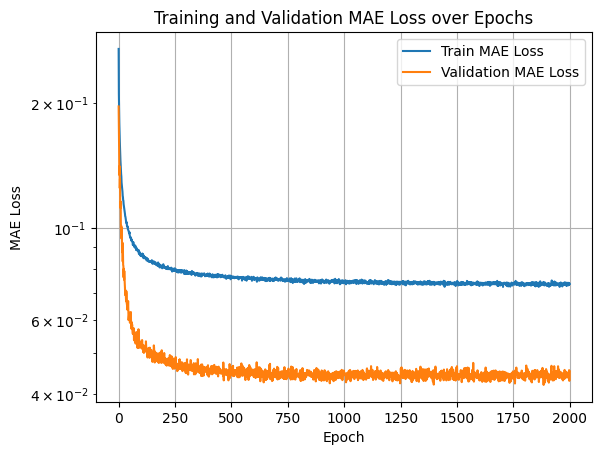

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train MAE Loss")
plt.plot(val_losses, label="Validation MAE Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training and Validation MAE Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate on Test Set
model.eval()
test_loss = 0.0
total_elements = 0

with torch.no_grad():
	for inputs, targets in test_loader:
		inputs, targets = inputs.to(device), targets.to(device)
		predictions = model(inputs)
		loss = criterion(predictions, targets)
		test_loss += loss.item()
		total_elements += inputs.size(0)

# 2. Report the final Test MAE
avg_test_mae = test_loss / len(test_loader)
print("-" * 40)
print(f"? Final Test MAE: {avg_test_mae:.6f} on {total_elements} samples.")
print("-" * 40)

----------------------------------------
? Final Test MAE: 0.045022 on 500 samples.
----------------------------------------


In [ ]:
def run_inference(model, data, device):
	"""
	Performs inference on the entire dataset provided by the DataLoader.

	Args:
		model: The trained PyTorch model instance.
		data_loader: The DataLoader (e.g., test_loader) containing the inference data.
		device: The device (CPU or GPU) to run the inference on.

	Returns:
		A NumPy array containing all predictions made by the model.
	"""
	# 1. Set the model to evaluation mode (CRUCIAL STEP)
	# This disables dropout and ensures batch norm layers (if present) use 
	# the running mean/variance statistics learned during training.
	model.eval()
	data_torch = torch.from_numpy(data).float().to(device)
	
	# 2. Disable gradient calculations (CRUCIAL STEP)
	# This saves memory and speeds up computation.
	with torch.no_grad():
		# 3. Forward pass (Inference)
		outputs = model(data_torch).cpu().numpy()
	
	return outputs

def GenerateBatchedPredictedRawS3P(model, geo_params, device):
	"""
	Generates predicted S-parameters for a batch of geometry inputs.

	Args:
		model: The trained PyTorch model instance.
		geo_params: A NumPy array of shape (n_samples, geo_size) representing the geometry parameters.
		device: The device (CPU or GPU) to run the inference on.	
	Returns:
		A NumPy array containing the predicted S-parameters for all input geometries.
	"""
	# Normalize the input geometry parameters
	geo_params_normalized = (geo_params - gen_min) / (gen_max - gen_min) * 2 - 1
	
	# Run inference
	predicted_sparams_normalized = run_inference(model, geo_params_normalized, device)
	
	# Denormalize the predicted S-parameters
	predicted_sparams = (predicted_sparams_normalized + 1) / 2 * (sparam_max - sparam_min) + sparam_min

	return predicted_sparams

def GenerateSinglePredictedRawS3P(model, geo_params, device):
	"""
	Generates predicted S-parameters for a single geometry input.

	Args:
		model: The trained PyTorch model instance.
		geo_params: A NumPy array of shape (geo_size,) representing the geometry parameters.
		device: The device (CPU or GPU) to run the inference on.
	Returns:
		A NumPy array containing the predicted S-parameters.
	"""
	return GenerateBatchedPredictedRawS3P(model, geo_params.reshape(1, -1), device).flatten()

def ProcessRawS3P(s_org):
	for i in range(n_freq):
		start_idx = i * n_ports * n_ports * 2
		end_idx = (i + 1) * n_ports * n_ports * 2
		s_complex = s_org[start_idx:end_idx]
		# Convert back to complex numbers
		s_complex = s_complex[:n_ports * n_ports] + 1j * s_complex[n_ports * n_ports:]
		if i == 0:
			s_params_all = s_complex.reshape(1, n_ports, n_ports)
		else:
			s_params_all = np.vstack((s_params_all, s_complex.reshape(1, n_ports, n_ports)))
	return s_params_all

def GetPredictedNetwork(predicted_sparams, save = False, file_path = "predicted_output.s3p"):
	"""
	Saves the predicted S-parameters to a Touchstone (.s3p) file.

	Args:
		predicted_sparams: A NumPy array of shape (n_freq * n_ports * n_ports * 2,)
							containing the predicted S-parameters (real and imaginary parts).
		file_path: The path to save the Touchstone file.
	"""
	s_params_processed = ProcessRawS3P(predicted_sparams)
	
	# Create a Network object
	ntwk = rf.Network(frequency=rf.Frequency(start=0, stop=frequency_upbound, npoints=n_freq), s=s_params_processed)
	
	# Save to Touchstone file
	if save: ntwk.write_touchstone(file_path)

	return ntwk

In [ ]:
print(GenerateSinglePredictedRawS3P(model, geo_data_raw[1], device))
print(sparam_data_raw[1])

[-0.24669678  0.62576545  0.62286605 ... -0.1984817  -0.51820745
  0.033854  ]
[-0.2475306   0.6249095   0.6226588  ... -0.1178263  -0.4723483
 -0.08320194]


/tmp/ipykernel_2011270/1764343489.py:87: DeprecationWarning: 
                          Frequency unit not passed: uses 'Hz' per default.
                          
  ntwk = rf.Network(frequency=rf.Frequency(start=0, stop=frequency_upbound, npoints=n_freq), s=s_params_processed)


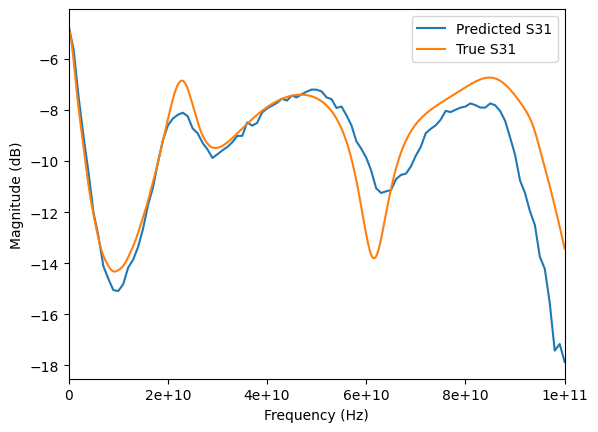

In [ ]:
# Test visualization for a single sample
test_id = 60
ntwk_predicted = GetPredictedNetwork(GenerateSinglePredictedRawS3P(model, geo_data_raw[test_id], device))
ntwk_true = rf.Network(data_path + f'SPData/{test_id}.s3p')
ntwk_predicted.plot_s_db(2,0,label='Predicted S31')
ntwk_true.plot_s_db(2,0,label='True S31')

In [ ]:
# Save the normalization parameters and the trained model
os.makedirs('model_n_normalize', exist_ok=True)
np.save('model_n_normalize/sparam_min.npy', sparam_min)
np.save('model_n_normalize/sparam_max.npy', sparam_max)
np.save('model_n_normalize/geo_min.npy', gen_min)
np.save('model_n_normalize/geo_max.npy', gen_max)
torch.save(model, 'model_n_normalize/deeper_mlp_model.pt')

## Structure of the Tested Structure

The proposed structure in this paper is a modified version of a CML stage. We first introduce cascode transistors to achieve higher reverse isolation, lower output capacitance and a bit higher output swing. Then, a smaller emitter follower stage is also added to the structure to decrease the input capacitance.

For the main CML differential pair, we use pseudo-differential tail current source to decrease the DC power consumption at degeneration resistors. The current and supply voltage are chosen to satisfy the maximize output swing, while the transistors peaked its $f_T$ by changing its length. Resistor is chosen to be Rppd for balance between current tolerance and parasitics.

Although for bipolar transistors, the necessity to add ESD protection is low, we still add it to verify our workflow to peak the driver performance with ESD parasitics. However, there is no official support on open-source tools about ESD diodes. So we just use data from documents to estimate the parasitic capacitance of ESD pair at each node.

Here is an example of a EF + CML driver stage demonstrated in open-source Qucs schematic editor.

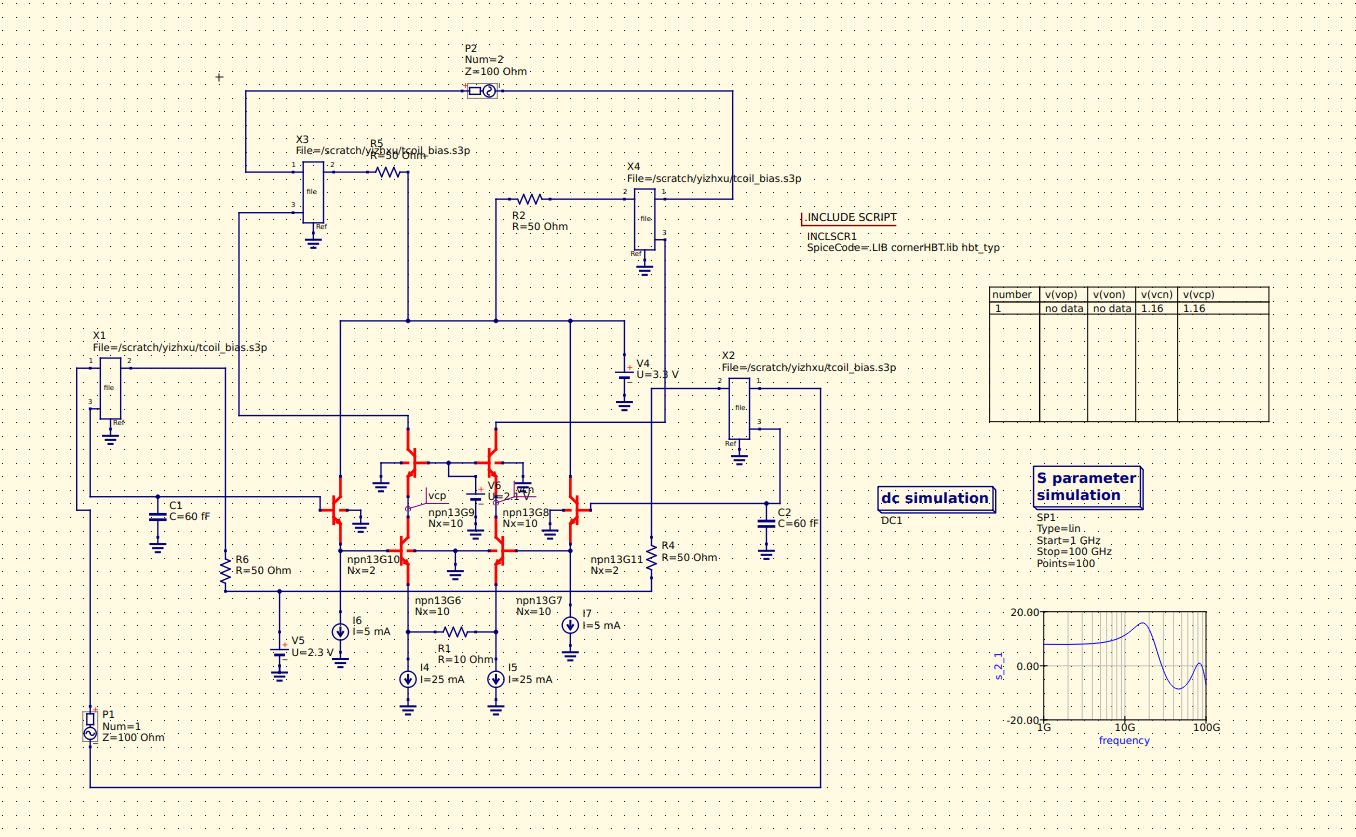

## SPICE Netlist Generation

The open-source ngspice does not officially support any type of s-parameter files, so we write a code to transcribe S3P into SPICE's xfer component, and add it into real netlist. Nevertheless, it could still not support transient simulation, we thus using S-parameter analysis only to demonstrate our workflow.

As mentioned before, ESD device is not available in SG13G2's open source libararies, so we simulate it in Cadence and set a estimated number of 60fF (2kV for both VCC and VEE). Pad is also estimated to 30fF (this value come from seperate simulations) for simulations without accurate modeling of pad structure.

### Running Instructions

Please save this to "run_ngspice.sh" at running folder, and change the dir name if in need.

```
export PDK_ROOT=./IHP-Open-PDK
export PDK=ihp-sg13g2
ngspice $1
```

In [ ]:
def Write_Libs(fi):
	fi.write(".LIB cornerRES.lib res_typ\n")
	fi.write(".LIB cornerHBT.lib hbt_typ\n")
	fi.write(".LIB cornerCAP.lib cap_typ\n")
	fi.write(".LIB cornerMOSlv.lib mos_tt\n")
	fi.write(".LIB cornerMOShv.lib mos_tt\n")
	fi.write("\n")

In [ ]:
def Write_SPfile_Subckt(fi, s3p_filename, subckt_name):
	ntw = rf.Network(s3p_filename)
	n_ports = ntw.number_of_ports
	fi.write(f".SUBCKT {subckt_name} ")
	for i in range(n_ports):
		fi.write('{} '.format(i+1))
	fi.write(f"{n_ports+1}\n")
	
	for i in range(n_ports):
		fi.write(f"R{i+1}N {i+1} {i+1}0 -50\n")
		fi.write(f"R{i+1}P {i+1}0 {i+1}1 100\n")
	fi.write('\n')

	for i in range(n_ports):
		for j in range(n_ports):
			fi.write(f"A{i+1}{j+1} %vd({j+1}0 {n_ports+1}) %vd({i+1}{j+1} {'' if j==n_ports-1 else str(i+1)}{j+2}) xfer{i*n_ports+j+1}\n")
			fi.write(f".model xfer{i*n_ports+j+1} xfer R_I=true table=[\n")
			for (k, f) in enumerate(ntw.f):
				s_ij = ntw.s[k,i,j]
				real_s = np.real(s_ij)
				imag_s = np.imag(s_ij)
				fi.write(f"+ {f}Hz {real_s} {imag_s}\n")
			fi.write("+ ]\n")
			fi.write('\n')
	
	fi.write('.ENDS\n\n')

In [ ]:
def Write_Port_Definitions(fi, pnum, c1, c0 = 0, dcv = 0, acv = 1, z0 = 50):
	fi.write(f"VP{pnum} {c1} {c0} dc {dcv} ac {acv} portnum {pnum} z0 {z0}\n")

def Write_Connections(fi, name, conn_list, pcell, param: dict = {}):
	fi.write(f"{name}")
	for conn in conn_list:
		fi.write(f" {conn}")
	fi.write(f" {pcell}")
	for (key, value) in param.items():
		fi.write(f" {key}={value}")
	fi.write("\n")

def WriteLine(fi, line = ""):
	fi.write(line + '\n')

def Write_ExportSimSP(fi, name, n_ports):
	fi.write(f"write {name} ")
	for i in range(n_ports):
		for j in range(n_ports):
			fi.write(f"S_{i+1}_{j+1} Z_{i+1}_{j+1} Y_{i+1}_{j+1} ")
	fi.write("\n")

def Write_DCVoltage(fi, name, n1, n2 = 0, dc = 0):
	fi.write(f"{name} {n1} {n2} dc {dc}\n")

def Write_mDCCurrent(fi, name, n1, n2 = 0, dc = 0):
	fi.write(f"{name} {n1} {n2} dc {dc}M\n")

In [ ]:
def Create_Test_Circuit_Original(cir_name = 'test_org.cir'):
	fi = open(cir_name,'w')
	WriteLine(fi,'* Circuits CML DRV')
	Write_Libs(fi)

	Write_Port_Definitions(fi,1,"_VIP","_VIN",z0=100)
	Write_Port_Definitions(fi,2,"_VOP","_VON",z0=100)

	Write_Connections(fi,'XRImatchP',['_VIP','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XRImatchN',['_VIN','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XROmatchP',['_VOP','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'XROmatchN',['_VON','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'CESD1',['_VIP','0'],'60F')
	Write_Connections(fi,'CESD2',['_VIN','0'],'60F')
	Write_Connections(fi,'CPAD1',['_VIP','0'],'30F')
	Write_Connections(fi,'CPAD2',['_VIN','0'],'30F')
	Write_Connections(fi,'CESD3',['_VOP','0'],'60F')
	Write_Connections(fi,'CESD4',['_VON','0'],'60F')
	Write_Connections(fi,'CPAD3',['_VOP','0'],'30F')
	Write_Connections(fi,'CPAD4',['_VON','0'],'30F')

	# Power Section
	Write_DCVoltage(fi,'VCC','_VCC',dc=3.3)
	Write_DCVoltage(fi,'VCCH','_VCCH',dc=6.0)
	Write_DCVoltage(fi,'VBIAS','_VBIAS',dc=2.0)
	Write_DCVoltage(fi,'VICM','_VICM',dc=2.2)
	# End of Power Section

	# Main Circuits
	Write_Connections(fi,'XQEFL1',['_VCC','_VIP','_ISL','0'],'npn13G2',{'Nx':4})
	Write_Connections(fi,'XQEFR1',['_VCC','_VIN','_ISR','0'],'npn13G2',{'Nx':4})
	Write_Connections(fi,'XQML1',['_VpkL','_ISL','_IResL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMR1',['_VpkR','_ISR','_IResR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQML1P',['_VpkL','_ISL','_IResL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMR1P',['_VpkR','_ISR','_IResR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMLCas1',['_VON','_VBIAS','_VpkL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMRCas1',['_VOP','_VBIAS','_VpkR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMLCas1P',['_VON','_VBIAS','_VpkL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMRCas1P',['_VOP','_VBIAS','_VpkR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XRDege1',['_IResL','_IResR','0'],'rppd',{'W':6e-6,'L':0.5e-6,'m':10})
	# End of Main Circuits

	# Current Sources
	Write_mDCCurrent(fi,'ISourceL','_ISL',dc=10)
	Write_mDCCurrent(fi,'ISourceR','_ISR',dc=10)
	Write_mDCCurrent(fi,'ISourceResL','_IResL',dc=50)
	Write_mDCCurrent(fi,'ISourceResR','_IResR',dc=50)
	# End of Current Sources

	# Control Section
	WriteLine(fi)
	WriteLine(fi,'.control')
	WriteLine(fi,'SP LIN 100 1G 100G')
	Write_ExportSimSP(fi,'output_sp.raw',2)
	WriteLine(fi)
	WriteLine(fi,'op')
	WriteLine(fi,'destroy all')
	WriteLine(fi,'reset')
	WriteLine(fi,'exit')
	WriteLine(fi,'.endc')
	WriteLine(fi)
	WriteLine(fi,'.END')
	# End of Control Section

	fi.close()

In [ ]:
def Create_Test_Circuit(indi,indo,raw_file = 'output_sp.raw',cir_name = 'test.cir'):
	fi = open(cir_name,'w')
	WriteLine(fi,'* Circuits CML DRV')
	Write_Libs(fi)
	input_s3p = f"{indi}.s3p"
	output_s3p = f"{indo}.s3p"
	Write_SPfile_Subckt(fi,input_s3p,'input_tcoil')
	Write_SPfile_Subckt(fi,output_s3p,'output_tcoil')

	Write_Port_Definitions(fi,1,"_VIP","_VIN",z0=100)
	Write_Port_Definitions(fi,2,"_VOP","_VON",z0=100)

	Write_Connections(fi,'XTCOIL_INP',['_VIP','_VIPX','_VImatchP','0'],'input_tcoil')
	Write_Connections(fi,'XTCOIL_INN',['_VIN','_VINX','_VImatchN','0'],'input_tcoil')
	Write_Connections(fi,'XTCOIL_OUTP',['_VOP','_VOPX','_VOmatchP','0'],'output_tcoil')
	Write_Connections(fi,'XTCOIL_OUTN',['_VON','_VONX','_VOmatchN','0'],'output_tcoil')
	Write_Connections(fi,'CESD1',['_VIPX','0'],'60F')
	Write_Connections(fi,'CESD2',['_VINX','0'],'60F')
	Write_Connections(fi,'CESD3',['_VOPX','0'],'60F')
	Write_Connections(fi,'CESD4',['_VONX','0'],'60F')

	Write_Connections(fi,'XRImatchP',['_VImatchP','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XRImatchN',['_VImatchN','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XROmatchP',['_VOmatchP','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'XROmatchN',['_VOmatchN','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	# Write_Connections(fi,'RImatchP',['_VImatchP','_VICM'],50)
	# Write_Connections(fi,'RImatchN',['_VImatchN','_VICM'],50)
	# Write_Connections(fi,'ROmatchP',['_VOmatchP','_VCC'],50)
	# Write_Connections(fi,'ROmatchN',['_VOmatchN','_VCC'],50)

	# Power Section
	Write_DCVoltage(fi,'VCC','_VCC',dc=3.3)
	Write_DCVoltage(fi,'VCCH','_VCCH',dc=6.0)
	Write_DCVoltage(fi,'VBIAS','_VBIAS',dc=2.0)
	Write_DCVoltage(fi,'VICM','_VICM',dc=2.3)
	# End of Power Section

	# Main Circuits
	Write_Connections(fi,'XQEFL1',['_VCC','_VIPX','_ISL','0'],'npn13G2',{'Nx':4})
	Write_Connections(fi,'XQEFR1',['_VCC','_VINX','_ISR','0'],'npn13G2',{'Nx':4})
	Write_Connections(fi,'XQML1',['_VpkL','_ISL','_IResL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMR1',['_VpkR','_ISR','_IResR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQML1P',['_VpkL','_ISL','_IResL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMR1P',['_VpkR','_ISR','_IResR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMLCas1',['_VONX','_VBIAS','_VpkL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMRCas1',['_VOPX','_VBIAS','_VpkR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMLCas1P',['_VONX','_VBIAS','_VpkL','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XQMRCas1P',['_VOPX','_VBIAS','_VpkR','0'],'npn13G2',{'Nx':10})
	Write_Connections(fi,'XRDege1',['_IResL','_IResR','0'],'rppd',{'W':6e-6,'L':0.5e-6,'m':10})
	# Write_Connections(fi,'RDege1',['_IResL','_IResR'],10)
	# End of Main Circuits

	# Current Sources
	Write_mDCCurrent(fi,'ISourceL','_ISL',dc=10)
	Write_mDCCurrent(fi,'ISourceR','_ISR',dc=10)
	Write_mDCCurrent(fi,'ISourceResL','_IResL',dc=50)
	Write_mDCCurrent(fi,'ISourceResR','_IResR',dc=50)
	# End of Current Sources

	# Control Section
	WriteLine(fi)
	WriteLine(fi,'.control')
	WriteLine(fi,'SP LIN 100 1G 100G')
	Write_ExportSimSP(fi,raw_file,2)
	WriteLine(fi)
	WriteLine(fi,'op')
	WriteLine(fi,'destroy all')
	WriteLine(fi,'reset')
	WriteLine(fi,'exit')
	WriteLine(fi,'.endc')
	WriteLine(fi)
	WriteLine(fi,'.END')
	# End of Control Section

	fi.close()

## Inverse Design

After training the MLP surrogate model and establishing the SPICE simulation scripts, we use CMA-ES [2] algorithm to optimize our final frequency response of the entire driver. In each optimization iteration, the algorithm first gives several EM structure suggestions towards the target. Our ANN surrogate model will give the EM prediction to replace costly EM simulations and our circuit simulation will combine the information from passive and active part to give the final performance. Then covariance matrix adaptation evolution strategy (CMA-ES) later analyze previous data and give next prediction suggestion. Our global optimization target is to minimize the defined cost $ -GBW/\text{GHz} + 10*Peaking_{max}/\text{dB}$.

In the following section, we demonstrate two different driver structures to verify the versatility of our automatic passive-active co-design workflow when working with different active circuits.

### Inverse Design Example 1

In the first example, the complete EF + cascode CML structure is used to peak the performance. ESD diodes are included in the simulation. A pair of 50mA ideal current sources is used to bias main 20x sized transistors and peak the $f_T$. A 10mA current source pair is also used to bias the emitter follower to peak its $f_T$ performance and a $4\Omega$ differential resistor is used for linearity enhancement (degeneration). Output common-mode voltage is determined by $V_{CCH}-I_{tail}\times R_T=3.5\text{V}$. Theoretically, a maximum of approximately $9V_{ppd}$ differential voltage swing is achived with this structure. With this structure fixed, we could utilize out T-coil inverse design workflow to peak the performance of the total driver circuits.

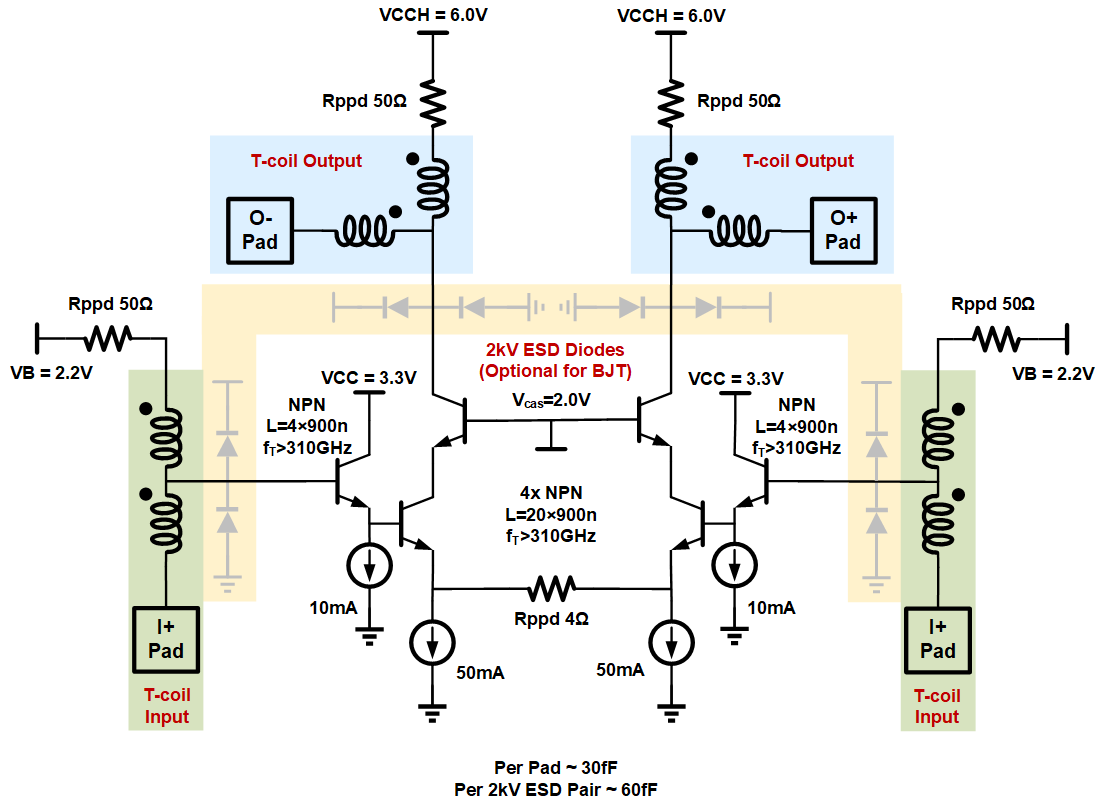

In [ ]:
# Ensure all necessary imports are included
import skrf as rf
import numpy as np
import os
from spicelib import RawRead
from matplotlib import pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import ast
import optuna
from multiprocessing import Pool
import random

In [ ]:
n_freq = 101
n_ports = 3
geo_size = 9
final_layer_size = n_freq * n_ports * n_ports * 2  # 2 for real and imaginary parts
frequency_upbound = 100e9  # upper frequency limit for S-parameters
torch.manual_seed(42)
ngspice_prefix = "sh run_ngspice.sh "  # command prefix to run ngspice simulations

In [ ]:
# choose device: prefer GPU (CUDA) if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = torch.load('model_n_normalize/deeper_mlp_model.pt', map_location=device, weights_only=False)
sparam_min = np.load('model_n_normalize/sparam_min.npy')
sparam_max = np.load('model_n_normalize/sparam_max.npy')
gen_min = np.load('model_n_normalize/geo_min.npy')
gen_max = np.load('model_n_normalize/geo_max.npy')

Using device: cuda


In [ ]:
def PerfCalcS21(frq, s21):
	gain = 20*np.log10(np.abs(s21))
	f3db_idx = np.where(gain <= (gain[0] - 3))[0]
	if len(f3db_idx) == 0:
		f3db = None
	else:
		f3db = frq[f3db_idx[0]]
	return gain[0], f3db, max(gain) - gain[0]

def PerfCalcRef(frq, s11, tof):
	ref = 20*np.log10(np.abs(s11))
	mx = -500
	for i in range(len(frq)):
		if frq[i] > tof: break
		if ref[i] > mx: mx = ref[i]
	return mx


#DZ INFO: oseda -2025.07


Note: No compatibility mode selected!


Circuit: * circuits cml drv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver
 Reference value :  2.00000e+09
No. of Data Rows : 100
binary raw file "output_sp.raw"
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver

No. of Data Rows : 1
Reset re-loads circuit * circuits cml drv

Circuit: * circuits cml drv

ngspice-44.2 done
(np.float64(15.975751112837987), np.complex128(30000000000+0j), np.float64(0.0))


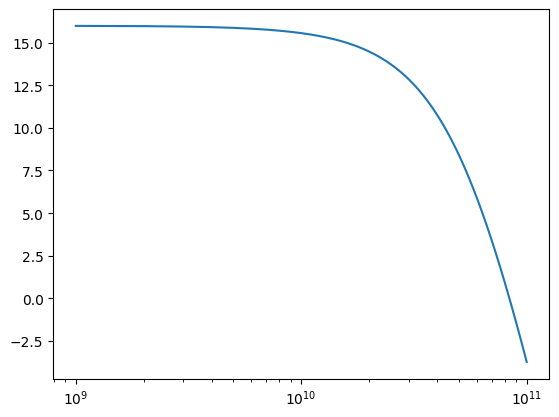

In [ ]:
Create_Test_Circuit_Original()
os.system(ngspice_prefix+'test_org.cir')
rawfile = RawRead('output_sp.raw')
s21_org = rawfile.get_trace("s_2_1").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21_org)))
plt.xscale('log')
print(PerfCalcS21(frq, s21_org))

In [ ]:
def run_inference(model, data, device):
	"""
	Performs inference on the entire dataset provided by the DataLoader.

	Args:
		model: The trained PyTorch model instance.
		data_loader: The DataLoader (e.g., test_loader) containing the inference data.
		device: The device (CPU or GPU) to run the inference on.

	Returns:
		A NumPy array containing all predictions made by the model.
	"""
	# 1. Set the model to evaluation mode (CRUCIAL STEP)
	# This disables dropout and ensures batch norm layers (if present) use 
	# the running mean/variance statistics learned during training.
	model.eval()
	data_torch = torch.from_numpy(data).float().to(device)
	
	# 2. Disable gradient calculations (CRUCIAL STEP)
	# This saves memory and speeds up computation.
	with torch.no_grad():
		# 3. Forward pass (Inference)
		outputs = model(data_torch).cpu().numpy()
	
	return outputs

def GenerateBatchedPredictedRawS3P(model, geo_params, device):
	"""
	Generates predicted S-parameters for a batch of geometry inputs.

	Args:
		model: The trained PyTorch model instance.
		geo_params: A NumPy array of shape (n_samples, geo_size) representing the geometry parameters.
		device: The device (CPU or GPU) to run the inference on.	
	Returns:
		A NumPy array containing the predicted S-parameters for all input geometries.
	"""
	# Normalize the input geometry parameters
	geo_params_normalized = (geo_params - gen_min) / (gen_max - gen_min) * 2 - 1
	
	# Run inference
	predicted_sparams_normalized = run_inference(model, geo_params_normalized, device)
	
	# Denormalize the predicted S-parameters
	predicted_sparams = (predicted_sparams_normalized + 1) / 2 * (sparam_max - sparam_min) + sparam_min

	return predicted_sparams

def GenerateSinglePredictedRawS3P(model, geo_params, device):
	"""
	Generates predicted S-parameters for a single geometry input.

	Args:
		model: The trained PyTorch model instance.
		geo_params: A NumPy array of shape (geo_size,) representing the geometry parameters.
		device: The device (CPU or GPU) to run the inference on.
	Returns:
		A NumPy array containing the predicted S-parameters.
	"""
	return GenerateBatchedPredictedRawS3P(model, geo_params.reshape(1, -1), device).flatten()

def ProcessRawS3P(s_org):
	for i in range(n_freq):
		start_idx = i * n_ports * n_ports * 2
		end_idx = (i + 1) * n_ports * n_ports * 2
		s_complex = s_org[start_idx:end_idx]
		# Convert back to complex numbers
		s_complex = s_complex[:n_ports * n_ports] + 1j * s_complex[n_ports * n_ports:]
		if i == 0:
			s_params_all = s_complex.reshape(1, n_ports, n_ports)
		else:
			s_params_all = np.vstack((s_params_all, s_complex.reshape(1, n_ports, n_ports)))
	return s_params_all

def GetPredictedNetwork(predicted_sparams, save = False, file_path = "predicted_output.s3p"):
	"""
	Saves the predicted S-parameters to a Touchstone (.s3p) file.

	Args:
		predicted_sparams: A NumPy array of shape (n_freq * n_ports * n_ports * 2,)
							containing the predicted S-parameters (real and imaginary parts).
		file_path: The path to save the Touchstone file.
	"""
	s_params_processed = ProcessRawS3P(predicted_sparams)
	
	# Create a Network object
	ntwk = rf.Network(frequency=rf.Frequency(start=0, stop=frequency_upbound, npoints=n_freq), s=s_params_processed)
	
	# Save to Touchstone file
	if save: ntwk.write_touchstone(file_path)

	return ntwk

def CheckValidity(geo_param):
	# firYratio is used to calculate firY
	wid, gap, sizX, sizY, tapseg, nseg, tapratio, endratio, firYratio = list(geo_param)
	gap = wid + gap
	nseg = nseg * 4 + 2
	if tapseg > nseg // 4: return None
	tapseg = tapseg * 4 + 0
	nturn = (nseg - 1) // 8 + 1
	# For Tapseg Check
	cur_metal = ((tapseg // 4) + 1) % 2
	id_turn = tapseg // 8
	if not (cur_metal == 0 or cur_metal == 1 and (id_turn == (nseg - 1) // 8 and nseg - 1 - tapseg < 4 or id_turn == 0 or id_turn == (nseg - 1) // 8)):
		return None
	# Tapseg Check End
	sizX = 3 * (nturn * gap) + wid + sizX
	sizY = 3 * (nturn * gap) + wid + sizY
	tapratio = tapratio
	endratio = endratio
	firYratio = firYratio
	firY = int(sizY * firYratio)
	return np.array([wid, gap, sizX, sizY, firY, tapseg, nseg, tapratio, endratio])

def GenerateBatchCir(geo_params, path_name_s3p = 'Temp_s3p', path_name_cir = 'Temp_cir'):
	geo_params_processed = []
	valid_list = []
	for geo_param in geo_params:
		g_in = CheckValidity(geo_param[:9])
		g_out = CheckValidity(geo_param[9:])
		if g_in is not None and g_out is not None:
			geo_params_processed.append(np.concatenate((g_in, g_out)))
			valid_list.append(True)
		else:
			geo_params_processed.append(np.zeros(18))  # Placeholder for invalid geometry
			valid_list.append(False)
	geo_params = np.array(geo_params_processed)
	resI = GenerateBatchedPredictedRawS3P(model, geo_params[:,:9], device)
	resO = GenerateBatchedPredictedRawS3P(model, geo_params[:,9:], device)
	for i in range(geo_params.shape[0]):
		if not valid_list[i]: continue
		# Here you can save or use the raw_s as needed
		GetPredictedNetwork(resI[i], save=True, file_path=f"{path_name_s3p}/input_{i}.s3p")
		GetPredictedNetwork(resO[i], save=True, file_path=f"{path_name_s3p}/output_{i}.s3p")
		Create_Test_Circuit(f"{path_name_s3p}/input_{i}", f"{path_name_s3p}/output_{i}", raw_file=f"{path_name_cir}/test_{i}.raw", cir_name=f"{path_name_cir}/test_{i}.cir")
	return valid_list

def GetOneCir(geo_params, path_name_s3p = 'Temp_s3p', path_name_cir = 'Temp_cir'):
	geo_params_processed = []
	valid_list = []
	for geo_param in geo_params:
		g_in = CheckValidity(geo_param[:9])
		g_out = CheckValidity(geo_param[9:])
		if g_in is not None and g_out is not None:
			geo_params_processed.append(np.concatenate((g_in, g_out)))
			valid_list.append(True)
		else:
			geo_params_processed.append(np.zeros(18))  # Placeholder for invalid geometry
			valid_list.append(False)
	geo_params = np.array(geo_params_processed)
	resI = GenerateBatchedPredictedRawS3P(model, geo_params[:,:9], device)
	resO = GenerateBatchedPredictedRawS3P(model, geo_params[:,9:], device)
	i = 0
	GetPredictedNetwork(resI[i], save=True, file_path=f"{path_name_s3p}/input_{i}.s3p")
	GetPredictedNetwork(resO[i], save=True, file_path=f"{path_name_s3p}/output_{i}.s3p")
	Create_Test_Circuit(f"{path_name_s3p}/input_{i}", f"{path_name_s3p}/output_{i}", raw_file=f"{path_name_cir}/test_{i}.raw", cir_name=f"{path_name_cir}/test_{i}.cir")
	os.system(ngspice_prefix+f'{path_name_cir}/test_{i}.cir > {path_name_cir}/test_{i}.log')
	rawfile = RawRead(f'{path_name_cir}/test_{i}.raw')
	return rawfile, g_in, g_out

In [ ]:
def one_sample(index, valid, path_name_cir = 'Temp_cir'):
	if not valid: return 1000.0  # Return a large penalty for invalid samples
	os.system(ngspice_prefix+f'{path_name_cir}/test_{index}.cir > {path_name_cir}/test_{index}.log')
	rawfile = RawRead(f'{path_name_cir}/test_{index}.raw')
	s21 = rawfile.get_trace("s_2_1").get_wave()
	frq = rawfile.get_trace("frequency").get_wave()
	gain0, f3db, expansion = PerfCalcS21(frq, s21)
	return - 10**(gain0/20) * (f3db if f3db is not None else 0) / 1e9 + expansion * 30

def wrap_one_sample(args):
	return one_sample(*args)

def batched_objective(params):
	params = np.array(params)
	valid_list = GenerateBatchCir(params)
	pool_param = [(i, valid_list[i]) for i in range(params.shape[0])]
	with Pool(8) as p:
		results = p.map(wrap_one_sample, pool_param)
	return results

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler())

for i in range(50):
	while True:
		wid1 = random.randint(3,12)
		gap1 = random.randint(3,12)
		nseg1 = random.randint(0,5)
		tapseg1 = random.randint(0,5)
		sizX1 = random.randint(0,100)
		sizY1 = random.randint(0,100)
		tapratio1 = random.uniform(0.3,0.8)
		endratio1 = random.uniform(0.2,0.8)
		firYratio1 = random.uniform(0.1,0.9)
		wid2 = random.randint(3,12)
		gap2 = random.randint(3,12)
		nseg2 = random.randint(0,5)
		tapseg2 = random.randint(0,5)
		sizX2 = random.randint(0,100)
		sizY2 = random.randint(0,100)
		tapratio2 = random.uniform(0.3,0.8)
		endratio2 = random.uniform(0.2,0.8)
		firYratio2 = random.uniform(0.1,0.9)
		if CheckValidity([wid1, gap1, sizX1, sizY1, tapseg1, nseg1, tapratio1, endratio1, firYratio1]) is not None and CheckValidity([wid2, gap2, sizX2, sizY2, tapseg2, nseg2, tapratio2, endratio2, firYratio2]) is not None:
			break
	study.enqueue_trial({'wid1': wid1, 'gap1': gap1, 'sizX1': sizX1, 'sizY1': sizY1, 'tapseg1': tapseg1, 'nseg1': nseg1, 'tapratio1': tapratio1, 'endratio1': endratio1, 'firYratio1': firYratio1,
						  'wid2': wid2, 'gap2': gap2, 'sizX2': sizX2, 'sizY2': sizY2, 'tapseg2': tapseg2, 'nseg2': nseg2, 'tapratio2': tapratio2, 'endratio2': endratio2, 'firYratio2': firYratio2})

[I 2025-10-27 22:59:41,752] A new study created in memory with name: no-name-c1a52a35-e0b2-47d8-8fed-0bff27e3be51


In [ ]:
opt_batch_size = 16
for iter in range(50):
	trials_params = []
	trials_numbers = []
	for _ in range(opt_batch_size):
		trial = study.ask()
		trials_numbers.append(trial.number)
		params = [trial.suggest_int('wid1', 3, 12),
				  trial.suggest_int('gap1', 3, 12),
				  trial.suggest_int('sizX1', 0, 100),
				  trial.suggest_int('sizY1', 0, 100),
				  trial.suggest_int('tapseg1', 0, 5),
				  trial.suggest_int('nseg1', 0, 5),
				  trial.suggest_float('tapratio1', 0.3, 0.8),
				  trial.suggest_float('endratio1', 0.2, 0.8),
				  trial.suggest_float('firYratio1', 0.1, 0.9),
				  trial.suggest_int('wid2', 3, 12),
				  trial.suggest_int('gap2', 3, 12),
				  trial.suggest_int('sizX2', 0, 100),
				  trial.suggest_int('sizY2', 0, 100),
				  trial.suggest_int('tapseg2', 0, 5),
				  trial.suggest_int('nseg2', 0, 5),
				  trial.suggest_float('tapratio2', 0.3, 0.8),
				  trial.suggest_float('endratio2', 0.2, 0.8),
				  trial.suggest_float('firYratio2', 0.1, 0.9)]
		trials_params.append(params)
	results = batched_objective(trials_params)
	for i in range(opt_batch_size):
		study.tell(trials_numbers[i], results[i])
	print(f"Iteration {iter+1}/{50} completed, Batch Values: {study.best_value}, Best Parameters: {study.best_params}")

Iteration 1/50 completed, Batch Values: -141.79758707234166, Best Parameters: {'wid1': 7, 'gap1': 7, 'sizX1': 30, 'sizY1': 91, 'tapseg1': 0, 'nseg1': 2, 'tapratio1': 0.5462392191392029, 'endratio1': 0.47015980665374474, 'firYratio1': 0.17256036240085104, 'wid2': 3, 'gap2': 7, 'sizX2': 69, 'sizY2': 97, 'tapseg2': 1, 'nseg2': 1, 'tapratio2': 0.535391713308534, 'endratio2': 0.7567575325807454, 'firYratio2': 0.10764569610149338}


Iteration 2/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 3/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 4/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 5/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 6/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 7/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 8/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 9/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 10/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 11/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 12/50 completed, Batch Values: -315.7624102312329, Best Parameters: {'wid1': 11, 'gap1': 12, 'sizX1': 85, 'sizY1': 31, 'tapseg1': 0, 'nseg1': 0, 'tapratio1': 0.37513080331620546, 'endratio1': 0.4663370008954328, 'firYratio1': 0.5972726749597584, 'wid2': 9, 'gap2': 5, 'sizX2': 23, 'sizY2': 2, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.5888888077018153, 'endratio2': 0.6799980211248675, 'firYratio2': 0.5556183301785392}


Iteration 13/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 14/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 15/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 16/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 17/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 18/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 19/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 20/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 21/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 22/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 23/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 24/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 25/50 completed, Batch Values: -319.80128656850417, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 65, 'sizY1': 25, 'tapseg1': 1, 'nseg1': 2, 'tapratio1': 0.5773531981924578, 'endratio1': 0.4467064701646911, 'firYratio1': 0.41159563397858256, 'wid2': 5, 'gap2': 7, 'sizX2': 55, 'sizY2': 37, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6113326407368591, 'endratio2': 0.49785763509019304, 'firYratio2': 0.48520531590106686}


Iteration 26/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 27/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 28/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 29/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 30/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 31/50 completed, Batch Values: -323.2411074761278, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 73, 'sizY1': 16, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.7166085658285322, 'endratio1': 0.34734829983739124, 'firYratio1': 0.7315284144378186, 'wid2': 5, 'gap2': 7, 'sizX2': 66, 'sizY2': 43, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.4949936511358701, 'endratio2': 0.32189574575435975, 'firYratio2': 0.2403453980904029}


Iteration 32/50 completed, Batch Values: -339.5834305104702, Best Parameters: {'wid1': 7, 'gap1': 5, 'sizX1': 51, 'sizY1': 35, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.6416214050520483, 'endratio1': 0.39686229283889196, 'firYratio1': 0.6643978174658918, 'wid2': 5, 'gap2': 7, 'sizX2': 62, 'sizY2': 31, 'tapseg2': 0, 'nseg2': 0, 'tapratio2': 0.5769329070456817, 'endratio2': 0.41650844782097457, 'firYratio2': 0.38100923152095467}


Iteration 33/50 completed, Batch Values: -352.5725493168559, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 47, 'sizY1': 18, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.6131961341300896, 'endratio1': 0.40015440532678415, 'firYratio1': 0.8026608440777804, 'wid2': 6, 'gap2': 5, 'sizX2': 51, 'sizY2': 21, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.556732195684316, 'endratio2': 0.43767074661477046, 'firYratio2': 0.27472085805696456}


Iteration 34/50 completed, Batch Values: -352.5725493168559, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 47, 'sizY1': 18, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.6131961341300896, 'endratio1': 0.40015440532678415, 'firYratio1': 0.8026608440777804, 'wid2': 6, 'gap2': 5, 'sizX2': 51, 'sizY2': 21, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.556732195684316, 'endratio2': 0.43767074661477046, 'firYratio2': 0.27472085805696456}


Iteration 35/50 completed, Batch Values: -353.24185328128783, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 50, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5887212131297299, 'endratio1': 0.3342381472995183, 'firYratio1': 0.6651822795879463, 'wid2': 6, 'gap2': 4, 'sizX2': 53, 'sizY2': 30, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.47979080456210865, 'endratio2': 0.39209505682085033, 'firYratio2': 0.2780394867738126}


Iteration 36/50 completed, Batch Values: -353.24185328128783, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 50, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5887212131297299, 'endratio1': 0.3342381472995183, 'firYratio1': 0.6651822795879463, 'wid2': 6, 'gap2': 4, 'sizX2': 53, 'sizY2': 30, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.47979080456210865, 'endratio2': 0.39209505682085033, 'firYratio2': 0.2780394867738126}


Iteration 37/50 completed, Batch Values: -353.24185328128783, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 50, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5887212131297299, 'endratio1': 0.3342381472995183, 'firYratio1': 0.6651822795879463, 'wid2': 6, 'gap2': 4, 'sizX2': 53, 'sizY2': 30, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.47979080456210865, 'endratio2': 0.39209505682085033, 'firYratio2': 0.2780394867738126}


Iteration 38/50 completed, Batch Values: -363.0471234873637, Best Parameters: {'wid1': 7, 'gap1': 7, 'sizX1': 26, 'sizY1': 17, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5951818336520582, 'endratio1': 0.4090668570689445, 'firYratio1': 0.5376811091362946, 'wid2': 5, 'gap2': 5, 'sizX2': 36, 'sizY2': 19, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5956023087292709, 'endratio2': 0.4473834385614557, 'firYratio2': 0.266342620289531}


Iteration 39/50 completed, Batch Values: -365.64057434638164, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 43, 'sizY1': 8, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.578927067923759, 'endratio1': 0.3903943968666338, 'firYratio1': 0.6722981436803981, 'wid2': 5, 'gap2': 5, 'sizX2': 42, 'sizY2': 10, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5291099966928893, 'endratio2': 0.472206849928889, 'firYratio2': 0.3283040689583872}


Iteration 40/50 completed, Batch Values: -365.64057434638164, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 43, 'sizY1': 8, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.578927067923759, 'endratio1': 0.3903943968666338, 'firYratio1': 0.6722981436803981, 'wid2': 5, 'gap2': 5, 'sizX2': 42, 'sizY2': 10, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5291099966928893, 'endratio2': 0.472206849928889, 'firYratio2': 0.3283040689583872}


Iteration 41/50 completed, Batch Values: -365.64057434638164, Best Parameters: {'wid1': 6, 'gap1': 6, 'sizX1': 43, 'sizY1': 8, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.578927067923759, 'endratio1': 0.3903943968666338, 'firYratio1': 0.6722981436803981, 'wid2': 5, 'gap2': 5, 'sizX2': 42, 'sizY2': 10, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5291099966928893, 'endratio2': 0.472206849928889, 'firYratio2': 0.3283040689583872}


Iteration 42/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 43/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 44/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 45/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 46/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 47/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 48/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 49/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


Iteration 50/50 completed, Batch Values: -368.2908901296102, Best Parameters: {'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


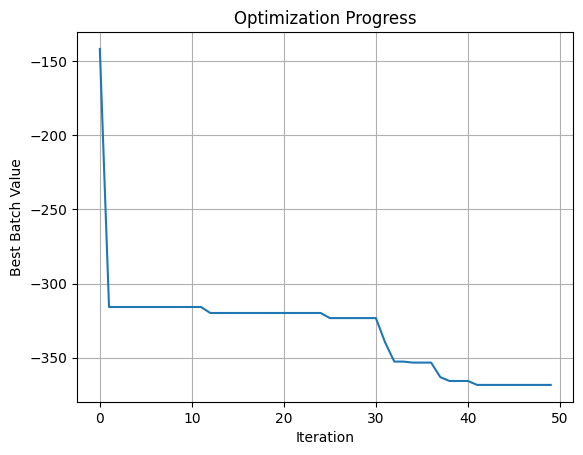

In [ ]:
import re
from matplotlib import pyplot as plt
fi = open('optimization_data.txt', 'r')
lines = fi.readlines()
fi.close()
current_value = []
for line in lines:
	if line.startswith('Iteration'):
		parts = line.split(',')
		for part in parts:
			if 'Batch Values' in part:
				value_str = part.split(':')[1].strip()
				current_value.append(float(value_str))
plt.plot(current_value)
plt.xlabel('Iteration')
plt.ylabel('Best Batch Value')
plt.title('Optimization Progress')
plt.grid(True)
plt.show()

{'wid1': 6, 'gap1': 7, 'sizX1': 25, 'sizY1': 20, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5713060430672738, 'endratio1': 0.3270680880766642, 'firYratio1': 0.5819889750512551, 'wid2': 6, 'gap2': 6, 'sizX2': 24, 'sizY2': 7, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.5189825060200189, 'endratio2': 0.4439473274885892, 'firYratio2': 0.2704888761071211}


/tmp/ipykernel_2118049/1482794471.py:87: DeprecationWarning: 
                          Frequency unit not passed: uses 'Hz' per default.
                          
  ntwk = rf.Network(frequency=rf.Frequency(start=0, stop=frequency_upbound, npoints=n_freq), s=s_params_processed)


The temperature limiting function received NaN.
Please check your power dissipation and improve your heat sink Rth!
    This message will be shown only once.

Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed


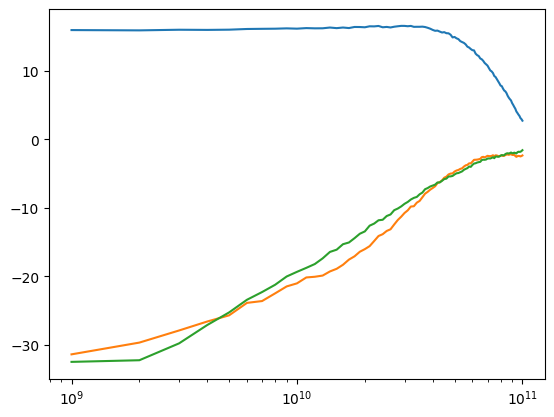

(np.float64(15.898262684797103), np.complex128(62000000000+0j), np.float64(0.6115788315176189))


In [ ]:
print(study.best_params)
rawfile, inparam, ouparam = GetOneCir([list(study.best_params.values())])
s21 = rawfile.get_trace("s_2_1").get_wave()
s11 = rawfile.get_trace("s_1_1").get_wave()
s22 = rawfile.get_trace("s_2_2").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21)))
plt.plot(np.real(frq),20*np.log10(np.abs(s11)))
plt.plot(np.real(frq),20*np.log10(np.abs(s22)))
plt.xscale('log')
plt.show()
print(PerfCalcS21(frq, s21))

In [ ]:
print("Input Geometry:", inparam)
print("Output Geometry:", ouparam)

Input Geometry: [ 6.         13.         70.         65.         37.          0.
  6.          0.57130604  0.32706809]
Output Geometry: [ 6.         12.         66.         49.         13.          0.
  6.          0.51898251  0.44394733]


In [ ]:
import tcoil_bias as tcoil
import gdspy
# This commmand is used to fix a bug (otherwise restart is mandatory, causing low efficiency)
# Refer to: https://github.com/heitzmann/gdspy/issues/222
gdspy.library.use_current_library = False

# The GDSII file is called a library, which contains multiple cells.
lib = gdspy.GdsLibrary(name = 'tcoil_bias')
lib.precision = 5e-9 # DRC alignment requirements: usually 5nm

In [ ]:
# Geometry must be placed in cells.
cell = lib.new_cell('test')
cell.add(tcoil.CreateTCoilTraceVanilla(int(inparam[0]), int(inparam[1]), int(inparam[2]), int(inparam[3]), int(inparam[4]), int(inparam[5]), int(inparam[6]), inparam[7], inparam[8], int(inparam[1]) + 5, includepad=True))
for layer in tcoil.all_layers:
	tcoil.CombineLayer(cell, layer)

# Display all cells using the internal viewer.
gdspy.LayoutViewer(lib, background = "#FFFFFF")

lib.write_gds('tcoil_bias_in.gds')
lib.remove(cell)

0

In [ ]:
# Geometry must be placed in cells.
cell = lib.new_cell('test')
cell.add(tcoil.CreateTCoilTraceVanilla(int(ouparam[0]), int(ouparam[1]), int(ouparam[2]), int(ouparam[3]), int(ouparam[4]), int(ouparam[5]), int(ouparam[6]), ouparam[7], ouparam[8], int(ouparam[1]) + 5, includepad=True))
for layer in tcoil.all_layers:
	tcoil.CombineLayer(cell, layer)

# Display all cells using the internal viewer.
gdspy.LayoutViewer(lib, background = "#FFFFFF")

lib.write_gds('tcoil_bias_out.gds')
lib.remove(cell)

0


#DZ INFO: oseda -2025.07





The temperature limiting function received NaN.
Please check your power dissipation and improve your heat sink Rth!
    This message will be shown only once.

Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping



Note: No compatibility mode selected!


Circuit: * circuits cml drv

Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver


Note: Dynamic gmin stepping completed



No. of Data Rows : 100
binary raw file "best_output.raw"
Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver
 Reference value :  0.00000e+00
No. of Data Rows : 1
Reset re-loads circuit * circuits cml drv

Circuit: * circuits cml drv

ngspice-44.2 done
['frequency', 's_1_1', 'z_1_1', 'y_1_1', 's_1_2', 'z_1_2', 'y_1_2', 's_2_1', 'z_2_1', 'y_2_1', 's_2_2', 'z_2_2', 'y_2_2']
OrderedDict({'Filename': 'best_output.raw', 'Title': '* circuits cml drv', 'Date': 'Wed Oct 29 14:08:01  2025', 'Command': 'ngspice-44.2, Build Fri Jul 11 10:02:30 UTC 2025', 'Plotname': 'SP Analysis', 'Flags': 'complex', 'No. Variables': '13', 'No. Points': '100', 'Variables': ['frequency', 's_1_1', 'z_1_1', 'y_1_1', 's_1_2', 'z_1_2', 'y_1_2', 's_2_1', 'z_2_1', 'y_2_1', 's_2_2', 'z_2_2', 'y_2_2']})


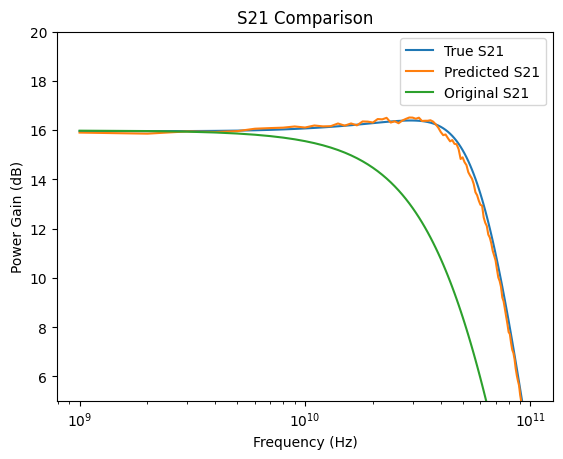

(np.float64(15.953234796507598), np.complex128(63000000000+0j), np.float64(0.4356291254228992))


In [ ]:
Create_Test_Circuit("tcoil_bias_in","tcoil_bias_out", raw_file='best_output.raw', cir_name='best_test.cir')
os.system(ngspice_prefix+'best_test.cir')
rawfile = RawRead('best_output.raw')
print(rawfile.get_trace_names())
print(rawfile.get_raw_property())
s21_true = rawfile.get_trace("s_2_1").get_wave()
s11_true = rawfile.get_trace("s_1_1").get_wave()
s22_true = rawfile.get_trace("s_2_2").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21_true)),label='True S21')
plt.plot(np.real(frq),20*np.log10(np.abs(s21)),label='Predicted S21')
plt.plot(np.real(frq),20*np.log10(np.abs(s21_org)),label='Original S21')
# plt.plot(np.real(frq),20*np.log10(np.abs(s11_true)))
# plt.plot(np.real(frq),20*np.log10(np.abs(s22_true)))
plt.ylabel('Power Gain (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('S21 Comparison')
plt.xscale('log')
plt.ylim(5,20)
plt.legend()
plt.show()
print(PerfCalcS21(frq, s21_true))

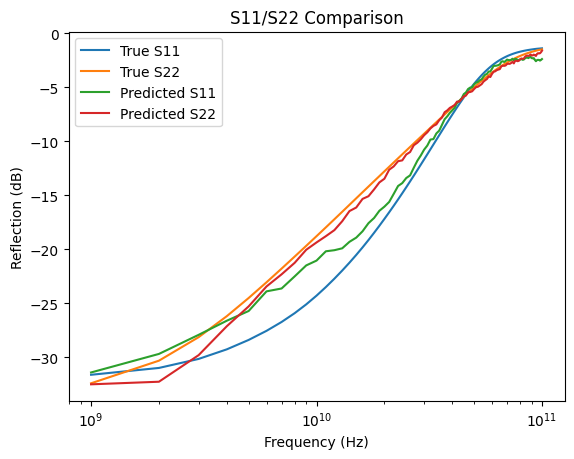

-2.6630707039437764
-3.322019020083713


In [ ]:
gain0, f3db, expansion = PerfCalcS21(frq, s21_true)
plt.plot(np.real(frq),20*np.log10(np.abs(s11_true)),label='True S11')
plt.plot(np.real(frq),20*np.log10(np.abs(s22_true)),label='True S22')
plt.plot(np.real(frq),20*np.log10(np.abs(s11)),label='Predicted S11')
plt.plot(np.real(frq),20*np.log10(np.abs(s22)),label='Predicted S22')
plt.ylabel('Reflection (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('S11/S22 Comparison')
plt.xscale('log')
plt.legend()
plt.show()
print(PerfCalcRef(frq, s11_true, np.abs(f3db)))
print(PerfCalcRef(frq, s22_true, np.abs(f3db)))

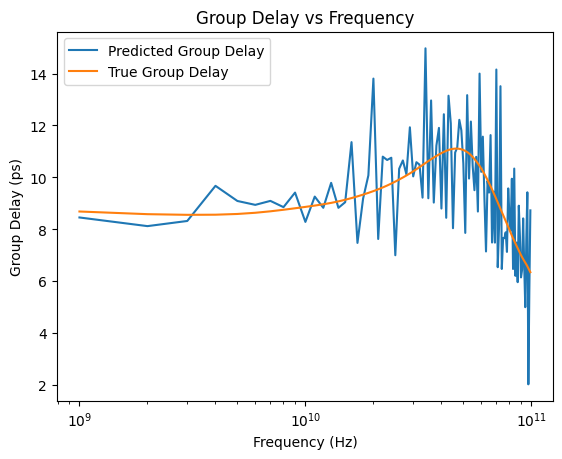

In [ ]:
group_delay = -np.diff(np.unwrap(np.angle(s21)))/np.diff(np.real(frq))/(2*np.pi)
group_delay_true = -np.diff(np.unwrap(np.angle(s21_true)))/np.diff(np.real(frq))/(2*np.pi)
plt.plot(np.real(frq[:-1]), group_delay*1e12,label='Predicted Group Delay')
plt.plot(np.real(frq[:-1]), group_delay_true*1e12,label='True Group Delay')
plt.ylabel('Group Delay (ps)')
plt.xlabel('Frequency (Hz)')
plt.title('Group Delay vs Frequency')
plt.xscale('log')
plt.legend()
plt.show()

As is shown above, without any passive peaking circuits, the driver could achieve 30GHz bandwidth with 15.98dB low-frequency gain. With the help of inverse design workflow, within 50 iterations (approx. 2min), a cost of -368 is achieved, with a 63GHz bandwidth, 15.95dB low-frequency gain, meaning a 2.1x bandwidth improvement, and peaking only less than 0.5dB. At the meantime, input and output reflection and group delay variation shows good results in both performance and surrogate model accuracy.

The cell below shows a complete layout combing both input T-coil and output T-coil. Since the structre of active circuits is symmetric, we propose same T-coil structure for diffrential inputs/outputs. The layout leaves enough space for active circuits, and by inserting the active layout, it could be easily incorporated into a chip level layout.

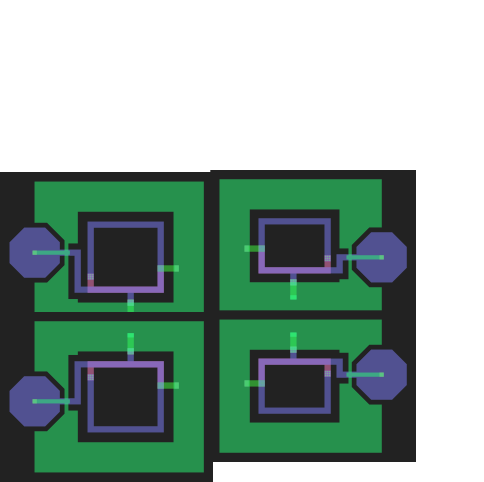

In [ ]:
import gdspy
import cairosvg
from IPython.display import SVG, display
from PIL import Image
from matplotlib import pyplot as plt
input_coil = gdspy.GdsLibrary(infile='tcoil_bias_in.gds')
cell = list(input_coil.cells.values())[0]
cell.write_svg('temp_final.svg')
svg_data = open('temp_final.svg','r').read()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to='tcoil_bias_in.png', scale = 0.1)
output_coil = gdspy.GdsLibrary(infile='tcoil_bias_out.gds')
cell = list(output_coil.cells.values())[0]
cell.write_svg('temp_final.svg')
svg_data = open('temp_final.svg','r').read()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to='tcoil_bias_out.png', scale = 0.1)
input_img = Image.open('tcoil_bias_in.png')
flipped_input_img = input_img.transpose(Image.FLIP_TOP_BOTTOM)
output_img = Image.open('tcoil_bias_out.png').transpose(Image.FLIP_LEFT_RIGHT)
flipped_output_img = output_img.transpose(Image.FLIP_TOP_BOTTOM)
fig = plt.figure(figsize=(6, 6))
plt.figimage(input_img, cmap='viridis', xo=0, yo=140)
plt.figimage(output_img, cmap='viridis', xo=210, yo=160)
plt.figimage(flipped_input_img, cmap='viridis', xo=0, yo=0)
plt.figimage(flipped_output_img, cmap='viridis', xo=210, yo=20)
plt.axis('off')
plt.show()

### Inverse Design Example 2

In the second example, we remove the cascode transistors and emitter followers and expose the main large transistors directly to I/O nodes, which could significantly jeopardise the total driver bandwidth. A pair of 30mA ideal current sources is used to bias main 12x sized transistors and peak the $f_T$. A $4\Omega$ differential resistor is used for linearity enhancement (degeneration). Output common-mode voltage is determined by $V_{CCH}-I_{tail}\times R_T=1.8\text{V}$. Theoretically, a maximum of approximately $4V_{ppd}$ differential voltage swing is achived with this structure. With this structure fixed, we could utilize out T-coil inverse design workflow to peak the performance of the total driver circuits.

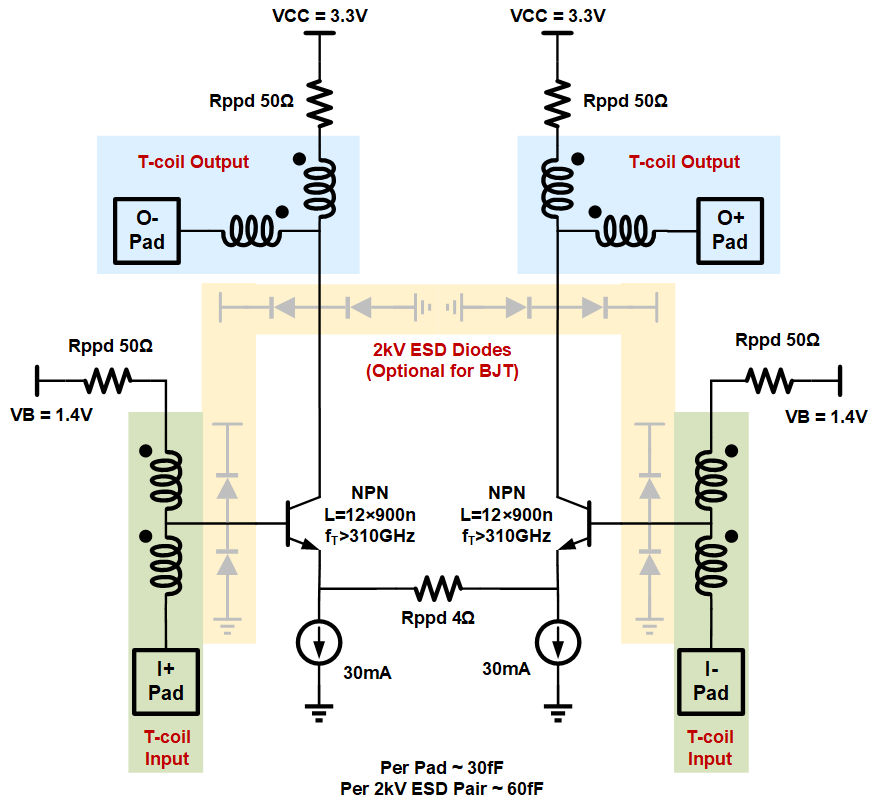

In [ ]:
def Create_Test_Circuit_Original(cir_name = 'test_org.cir'):
	fi = open(cir_name,'w')
	WriteLine(fi,'* Circuits CML DRV')
	Write_Libs(fi)

	Write_Port_Definitions(fi,1,"_VIP","_VIN",z0=100)
	Write_Port_Definitions(fi,2,"_VOP","_VON",z0=100)

	Write_Connections(fi,'XRImatchP',['_VIP','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XRImatchN',['_VIN','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XROmatchP',['_VOP','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'XROmatchN',['_VON','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'CESD1',['_VIP','0'],'60F')
	Write_Connections(fi,'CESD2',['_VIN','0'],'60F')
	Write_Connections(fi,'CPAD1',['_VIP','0'],'30F')
	Write_Connections(fi,'CPAD2',['_VIN','0'],'30F')
	Write_Connections(fi,'CESD3',['_VOP','0'],'60F')
	Write_Connections(fi,'CESD4',['_VON','0'],'60F')
	Write_Connections(fi,'CPAD3',['_VOP','0'],'30F')
	Write_Connections(fi,'CPAD4',['_VON','0'],'30F')

	# Power Section
	Write_DCVoltage(fi,'VCC','_VCC',dc=3.3)
	Write_DCVoltage(fi,'VCCH','_VCCH',dc=3.3)
	Write_DCVoltage(fi,'VICM','_VICM',dc=1.4)
	# End of Power Section

	# Main Circuits
	Write_Connections(fi,'XQML1',['_VOP','_VIN','_IResL','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQMR1',['_VON','_VIP','_IResR','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQML1P',['_VOP','_VIN','_IResL','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQMR1P',['_VON','_VIP','_IResR','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XRDege1',['_IResL','_IResR','0'],'rppd',{'W':6e-6,'L':0.5e-6,'m':10})
	# End of Main Circuits

	# Current Sources
	Write_mDCCurrent(fi,'ISourceResL','_IResL',dc=30)
	Write_mDCCurrent(fi,'ISourceResR','_IResR',dc=30)
	# End of Current Sources

	# Control Section
	WriteLine(fi)
	WriteLine(fi,'.control')
	WriteLine(fi,'SP LIN 100 1G 100G')
	Write_ExportSimSP(fi,'output_sp.raw',2)
	WriteLine(fi)
	WriteLine(fi,'op')
	WriteLine(fi,'destroy all')
	WriteLine(fi,'reset')
	WriteLine(fi,'exit')
	WriteLine(fi,'.endc')
	WriteLine(fi)
	WriteLine(fi,'.END')
	# End of Control Section

	fi.close()

In [ ]:
def Create_Test_Circuit(indi,indo,raw_file = 'output_sp.raw',cir_name = 'test.cir'):
	fi = open(cir_name,'w')
	WriteLine(fi,'* Circuits CML DRV')
	Write_Libs(fi)
	input_s3p = f"{indi}.s3p"
	output_s3p = f"{indo}.s3p"
	Write_SPfile_Subckt(fi,input_s3p,'input_tcoil')
	Write_SPfile_Subckt(fi,output_s3p,'output_tcoil')

	Write_Port_Definitions(fi,1,"_VIP","_VIN",z0=100)
	Write_Port_Definitions(fi,2,"_VOP","_VON",z0=100)

	Write_Connections(fi,'XTCOIL_INP',['_VIP','_VIPX','_VImatchP','0'],'input_tcoil')
	Write_Connections(fi,'XTCOIL_INN',['_VIN','_VINX','_VImatchN','0'],'input_tcoil')
	Write_Connections(fi,'XTCOIL_OUTP',['_VOP','_VOPX','_VOmatchP','0'],'output_tcoil')
	Write_Connections(fi,'XTCOIL_OUTN',['_VON','_VONX','_VOmatchN','0'],'output_tcoil')
	Write_Connections(fi,'CESD1',['_VIPX','0'],'60F')
	Write_Connections(fi,'CESD2',['_VINX','0'],'60F')
	Write_Connections(fi,'CESD3',['_VOPX','0'],'60F')
	Write_Connections(fi,'CESD4',['_VONX','0'],'60F')

	Write_Connections(fi,'XRImatchP',['_VImatchP','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XRImatchN',['_VImatchN','_VICM','0'],'rppd',{'W':4e-6,'L':0.5e-6,'m':1})
	Write_Connections(fi,'XROmatchP',['_VOmatchP','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	Write_Connections(fi,'XROmatchN',['_VOmatchN','_VCCH','0'],'rppd',{'W':37.8e-6,'L':7e-6,'m':1})
	# Write_Connections(fi,'RImatchP',['_VImatchP','_VICM'],50)
	# Write_Connections(fi,'RImatchN',['_VImatchN','_VICM'],50)
	# Write_Connections(fi,'ROmatchP',['_VOmatchP','_VCC'],50)
	# Write_Connections(fi,'ROmatchN',['_VOmatchN','_VCC'],50)

	# Power Section
	Write_DCVoltage(fi,'VCC','_VCC',dc=3.3)
	Write_DCVoltage(fi,'VCCH','_VCCH',dc=3.3)
	Write_DCVoltage(fi,'VICM','_VICM',dc=1.4)
	# End of Power Section

	# Main Circuits
	Write_Connections(fi,'XQML1',['_VOPX','_VINX','_IResL','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQMR1',['_VONX','_VIPX','_IResR','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQML1P',['_VOPX','_VINX','_IResL','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XQMR1P',['_VONX','_VIPX','_IResR','0'],'npn13G2',{'Nx':6})
	Write_Connections(fi,'XRDege1',['_IResL','_IResR','0'],'rppd',{'W':6e-6,'L':0.5e-6,'m':10})
	# Write_Connections(fi,'RDege1',['_IResL','_IResR'],10)
	# End of Main Circuits

	# Current Sources
	Write_mDCCurrent(fi,'ISourceResL','_IResL',dc=30)
	Write_mDCCurrent(fi,'ISourceResR','_IResR',dc=30)
	# End of Current Sources

	# Control Section
	WriteLine(fi)
	WriteLine(fi,'.control')
	WriteLine(fi,'SP LIN 100 1G 100G')
	Write_ExportSimSP(fi,raw_file,2)
	WriteLine(fi)
	WriteLine(fi,'op')
	WriteLine(fi,'destroy all')
	WriteLine(fi,'reset')
	WriteLine(fi,'exit')
	WriteLine(fi,'.endc')
	WriteLine(fi)
	WriteLine(fi,'.END')
	# End of Control Section

	fi.close()


#DZ INFO: oseda -2025.07


Note: No compatibility mode selected!


Circuit: * circuits cml drv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver

No. of Data Rows : 100
binary raw file "output_sp.raw"
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver

No. of Data Rows : 1
Reset re-loads circuit * circuits cml drv

Circuit: * circuits cml drv

ngspice-44.2 done
(np.float64(13.079809045484268), np.complex128(17000000000+0j), np.float64(0.0))


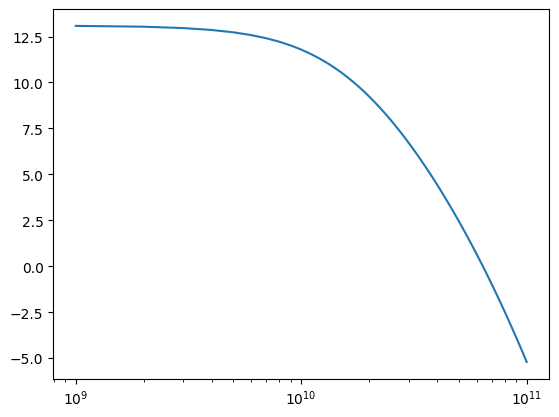

In [ ]:
Create_Test_Circuit_Original()
os.system(ngspice_prefix+'test_org.cir')
rawfile = RawRead('output_sp.raw')
s21_org = rawfile.get_trace("s_2_1").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21_org)))
plt.xscale('log')
print(PerfCalcS21(frq, s21_org))

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler())

for i in range(50):
	while True:
		wid1 = random.randint(3,12)
		gap1 = random.randint(3,12)
		nseg1 = random.randint(0,5)
		tapseg1 = random.randint(0,5)
		sizX1 = random.randint(0,100)
		sizY1 = random.randint(0,100)
		tapratio1 = random.uniform(0.3,0.8)
		endratio1 = random.uniform(0.2,0.8)
		firYratio1 = random.uniform(0.1,0.9)
		wid2 = random.randint(3,12)
		gap2 = random.randint(3,12)
		nseg2 = random.randint(0,5)
		tapseg2 = random.randint(0,5)
		sizX2 = random.randint(0,100)
		sizY2 = random.randint(0,100)
		tapratio2 = random.uniform(0.3,0.8)
		endratio2 = random.uniform(0.2,0.8)
		firYratio2 = random.uniform(0.1,0.9)
		if CheckValidity([wid1, gap1, sizX1, sizY1, tapseg1, nseg1, tapratio1, endratio1, firYratio1]) is not None and CheckValidity([wid2, gap2, sizX2, sizY2, tapseg2, nseg2, tapratio2, endratio2, firYratio2]) is not None:
			break
	study.enqueue_trial({'wid1': wid1, 'gap1': gap1, 'sizX1': sizX1, 'sizY1': sizY1, 'tapseg1': tapseg1, 'nseg1': nseg1, 'tapratio1': tapratio1, 'endratio1': endratio1, 'firYratio1': firYratio1,
						  'wid2': wid2, 'gap2': gap2, 'sizX2': sizX2, 'sizY2': sizY2, 'tapseg2': tapseg2, 'nseg2': nseg2, 'tapratio2': tapratio2, 'endratio2': endratio2, 'firYratio2': firYratio2})

[I 2025-10-27 23:06:02,231] A new study created in memory with name: no-name-65eb4971-9376-4439-90c2-11879e4805f8


In [ ]:
current_value = []
opt_batch_size = 16
for iter in range(50):
	trials_params = []
	trials_numbers = []
	for _ in range(opt_batch_size):
		trial = study.ask()
		trials_numbers.append(trial.number)
		params = [trial.suggest_int('wid1', 3, 12),
				  trial.suggest_int('gap1', 3, 12),
				  trial.suggest_int('sizX1', 0, 100),
				  trial.suggest_int('sizY1', 0, 100),
				  trial.suggest_int('tapseg1', 0, 5),
				  trial.suggest_int('nseg1', 0, 5),
				  trial.suggest_float('tapratio1', 0.3, 0.8),
				  trial.suggest_float('endratio1', 0.2, 0.8),
				  trial.suggest_float('firYratio1', 0.1, 0.9),
				  trial.suggest_int('wid2', 3, 12),
				  trial.suggest_int('gap2', 3, 12),
				  trial.suggest_int('sizX2', 0, 100),
				  trial.suggest_int('sizY2', 0, 100),
				  trial.suggest_int('tapseg2', 0, 5),
				  trial.suggest_int('nseg2', 0, 5),
				  trial.suggest_float('tapratio2', 0.3, 0.8),
				  trial.suggest_float('endratio2', 0.2, 0.8),
				  trial.suggest_float('firYratio2', 0.1, 0.9)]
		trials_params.append(params)
	results = batched_objective(trials_params)
	for i in range(opt_batch_size):
		study.tell(trials_numbers[i], results[i])
	print(f"Iteration {iter+1}/{50} completed, Batch Values: {study.best_value}, Best Parameters: {study.best_params}")
	current_value.append(study.best_value)

Iteration 1/50 completed, Batch Values: -78.96775278684144, Best Parameters: {'wid1': 7, 'gap1': 12, 'sizX1': 91, 'sizY1': 12, 'tapseg1': 1, 'nseg1': 1, 'tapratio1': 0.5058823432786301, 'endratio1': 0.7514990755024695, 'firYratio1': 0.5700103366362568, 'wid2': 6, 'gap2': 6, 'sizX2': 27, 'sizY2': 54, 'tapseg2': 0, 'nseg2': 0, 'tapratio2': 0.5643231787153262, 'endratio2': 0.34340581464134046, 'firYratio2': 0.67760738912143}


Iteration 2/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 3/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Dynamic gmin stepping completed


Iteration 4/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed


Iteration 5/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed


Iteration 6/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 7/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 8/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 9/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed


Iteration 10/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 11/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 12/50 completed, Batch Values: -110.83679876103739, Best Parameters: {'wid1': 3, 'gap1': 11, 'sizX1': 1, 'sizY1': 41, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.45830602699313977, 'endratio1': 0.6881877031713403, 'firYratio1': 0.5692000907288052, 'wid2': 4, 'gap2': 4, 'sizX2': 83, 'sizY2': 81, 'tapseg2': 1, 'nseg2': 3, 'tapratio2': 0.3294704090906463, 'endratio2': 0.7279508790948042, 'firYratio2': 0.23508851894155278}


Iteration 13/50 completed, Batch Values: -115.56114538534129, Best Parameters: {'wid1': 7, 'gap1': 6, 'sizX1': 74, 'sizY1': 47, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.4139235759732949, 'endratio1': 0.46852317587382997, 'firYratio1': 0.37819424707266736, 'wid2': 9, 'gap2': 9, 'sizX2': 45, 'sizY2': 31, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.6065707101842459, 'endratio2': 0.5998311011159002, 'firYratio2': 0.3195431405956508}


Iteration 14/50 completed, Batch Values: -115.56114538534129, Best Parameters: {'wid1': 7, 'gap1': 6, 'sizX1': 74, 'sizY1': 47, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.4139235759732949, 'endratio1': 0.46852317587382997, 'firYratio1': 0.37819424707266736, 'wid2': 9, 'gap2': 9, 'sizX2': 45, 'sizY2': 31, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.6065707101842459, 'endratio2': 0.5998311011159002, 'firYratio2': 0.3195431405956508}


Iteration 15/50 completed, Batch Values: -115.56114538534129, Best Parameters: {'wid1': 7, 'gap1': 6, 'sizX1': 74, 'sizY1': 47, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.4139235759732949, 'endratio1': 0.46852317587382997, 'firYratio1': 0.37819424707266736, 'wid2': 9, 'gap2': 9, 'sizX2': 45, 'sizY2': 31, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.6065707101842459, 'endratio2': 0.5998311011159002, 'firYratio2': 0.3195431405956508}


Iteration 16/50 completed, Batch Values: -115.56114538534129, Best Parameters: {'wid1': 7, 'gap1': 6, 'sizX1': 74, 'sizY1': 47, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.4139235759732949, 'endratio1': 0.46852317587382997, 'firYratio1': 0.37819424707266736, 'wid2': 9, 'gap2': 9, 'sizX2': 45, 'sizY2': 31, 'tapseg2': 1, 'nseg2': 2, 'tapratio2': 0.6065707101842459, 'endratio2': 0.5998311011159002, 'firYratio2': 0.3195431405956508}


Iteration 17/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 18/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 19/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 20/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 21/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 22/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 23/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 24/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 25/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 26/50 completed, Batch Values: -154.05398293601664, Best Parameters: {'wid1': 6, 'gap1': 5, 'sizX1': 64, 'sizY1': 43, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.32659424734463255, 'endratio1': 0.47908046192289405, 'firYratio1': 0.528045754464224, 'wid2': 9, 'gap2': 10, 'sizX2': 65, 'sizY2': 26, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.702512722519234, 'endratio2': 0.49142873226279543, 'firYratio2': 0.49047700752270296}


Iteration 27/50 completed, Batch Values: -157.5948869560387, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 75, 'sizY1': 13, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5009971543794561, 'endratio1': 0.46799165248634894, 'firYratio1': 0.6362908421984207, 'wid2': 11, 'gap2': 8, 'sizX2': 52, 'sizY2': 48, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6245568330216701, 'endratio2': 0.6022914128274335, 'firYratio2': 0.6372339770526795}


Iteration 28/50 completed, Batch Values: -157.5948869560387, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 75, 'sizY1': 13, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5009971543794561, 'endratio1': 0.46799165248634894, 'firYratio1': 0.6362908421984207, 'wid2': 11, 'gap2': 8, 'sizX2': 52, 'sizY2': 48, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6245568330216701, 'endratio2': 0.6022914128274335, 'firYratio2': 0.6372339770526795}


Iteration 29/50 completed, Batch Values: -157.5948869560387, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 75, 'sizY1': 13, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5009971543794561, 'endratio1': 0.46799165248634894, 'firYratio1': 0.6362908421984207, 'wid2': 11, 'gap2': 8, 'sizX2': 52, 'sizY2': 48, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6245568330216701, 'endratio2': 0.6022914128274335, 'firYratio2': 0.6372339770526795}


Iteration 30/50 completed, Batch Values: -157.5948869560387, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 75, 'sizY1': 13, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5009971543794561, 'endratio1': 0.46799165248634894, 'firYratio1': 0.6362908421984207, 'wid2': 11, 'gap2': 8, 'sizX2': 52, 'sizY2': 48, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6245568330216701, 'endratio2': 0.6022914128274335, 'firYratio2': 0.6372339770526795}


Iteration 31/50 completed, Batch Values: -157.90742888196797, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 89, 'sizY1': 19, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.515246264626095, 'endratio1': 0.4776805822842247, 'firYratio1': 0.6206615670842072, 'wid2': 11, 'gap2': 8, 'sizX2': 45, 'sizY2': 40, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6590209759641971, 'endratio2': 0.5391576271357617, 'firYratio2': 0.587969829462827}


Iteration 32/50 completed, Batch Values: -157.90742888196797, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 89, 'sizY1': 19, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.515246264626095, 'endratio1': 0.4776805822842247, 'firYratio1': 0.6206615670842072, 'wid2': 11, 'gap2': 8, 'sizX2': 45, 'sizY2': 40, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6590209759641971, 'endratio2': 0.5391576271357617, 'firYratio2': 0.587969829462827}


Iteration 33/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 34/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 35/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 36/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 37/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 38/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 39/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 40/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 41/50 completed, Batch Values: -159.16708216375253, Best Parameters: {'wid1': 11, 'gap1': 4, 'sizX1': 87, 'sizY1': 15, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5626871582972586, 'endratio1': 0.5312007058564175, 'firYratio1': 0.6069016812738287, 'wid2': 11, 'gap2': 8, 'sizX2': 62, 'sizY2': 36, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6694166723728632, 'endratio2': 0.43092758188359015, 'firYratio2': 0.6472325413938628}


Iteration 42/50 completed, Batch Values: -159.3058918170952, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 83, 'sizY1': 3, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5223217035882372, 'endratio1': 0.5563214669249112, 'firYratio1': 0.49353899937985346, 'wid2': 12, 'gap2': 8, 'sizX2': 55, 'sizY2': 18, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6909285601133589, 'endratio2': 0.5399398906749711, 'firYratio2': 0.6055398687998945}


Iteration 43/50 completed, Batch Values: -159.44829402370812, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 85, 'sizY1': 7, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5647002549017259, 'endratio1': 0.5228160877959942, 'firYratio1': 0.3784691227506052, 'wid2': 12, 'gap2': 8, 'sizX2': 59, 'sizY2': 16, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6921892175497983, 'endratio2': 0.5822857976281759, 'firYratio2': 0.5472028151768245}


Iteration 44/50 completed, Batch Values: -159.67349651533613, Best Parameters: {'wid1': 11, 'gap1': 5, 'sizX1': 73, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5855554116571002, 'endratio1': 0.5470338670806661, 'firYratio1': 0.4090779948917119, 'wid2': 12, 'gap2': 8, 'sizX2': 56, 'sizY2': 19, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6759375920760498, 'endratio2': 0.6000337381609442, 'firYratio2': 0.6241874122490223}


Iteration 45/50 completed, Batch Values: -159.67349651533613, Best Parameters: {'wid1': 11, 'gap1': 5, 'sizX1': 73, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5855554116571002, 'endratio1': 0.5470338670806661, 'firYratio1': 0.4090779948917119, 'wid2': 12, 'gap2': 8, 'sizX2': 56, 'sizY2': 19, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6759375920760498, 'endratio2': 0.6000337381609442, 'firYratio2': 0.6241874122490223}


Iteration 46/50 completed, Batch Values: -159.67349651533613, Best Parameters: {'wid1': 11, 'gap1': 5, 'sizX1': 73, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5855554116571002, 'endratio1': 0.5470338670806661, 'firYratio1': 0.4090779948917119, 'wid2': 12, 'gap2': 8, 'sizX2': 56, 'sizY2': 19, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6759375920760498, 'endratio2': 0.6000337381609442, 'firYratio2': 0.6241874122490223}


Iteration 47/50 completed, Batch Values: -159.67349651533613, Best Parameters: {'wid1': 11, 'gap1': 5, 'sizX1': 73, 'sizY1': 9, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5855554116571002, 'endratio1': 0.5470338670806661, 'firYratio1': 0.4090779948917119, 'wid2': 12, 'gap2': 8, 'sizX2': 56, 'sizY2': 19, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.6759375920760498, 'endratio2': 0.6000337381609442, 'firYratio2': 0.6241874122490223}


Iteration 48/50 completed, Batch Values: -159.88756655715164, Best Parameters: {'wid1': 10, 'gap1': 5, 'sizX1': 70, 'sizY1': 3, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.5219018026892752, 'endratio1': 0.5136924418079652, 'firYratio1': 0.3549688841639026, 'wid2': 12, 'gap2': 9, 'sizX2': 61, 'sizY2': 10, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.7202598489106471, 'endratio2': 0.6281434350155299, 'firYratio2': 0.535895117482065}


Iteration 49/50 completed, Batch Values: -160.03147205404457, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 70, 'sizY1': 7, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.49234497904224905, 'endratio1': 0.5161198471670174, 'firYratio1': 0.39334868331352024, 'wid2': 12, 'gap2': 8, 'sizX2': 69, 'sizY2': 8, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.7226471386500514, 'endratio2': 0.6077319224314408, 'firYratio2': 0.5065594125834655}


Iteration 50/50 completed, Batch Values: -160.03147205404457, Best Parameters: {'wid1': 9, 'gap1': 5, 'sizX1': 70, 'sizY1': 7, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.49234497904224905, 'endratio1': 0.5161198471670174, 'firYratio1': 0.39334868331352024, 'wid2': 12, 'gap2': 8, 'sizX2': 69, 'sizY2': 8, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.7226471386500514, 'endratio2': 0.6077319224314408, 'firYratio2': 0.5065594125834655}


{'wid1': 9, 'gap1': 5, 'sizX1': 70, 'sizY1': 7, 'tapseg1': 0, 'nseg1': 1, 'tapratio1': 0.49234497904224905, 'endratio1': 0.5161198471670174, 'firYratio1': 0.39334868331352024, 'wid2': 12, 'gap2': 8, 'sizX2': 69, 'sizY2': 8, 'tapseg2': 0, 'nseg2': 1, 'tapratio2': 0.7226471386500514, 'endratio2': 0.6077319224314408, 'firYratio2': 0.5065594125834655}


/tmp/ipykernel_2720298/1482794471.py:87: DeprecationWarning: 
                          Frequency unit not passed: uses 'Hz' per default.
                          
  ntwk = rf.Network(frequency=rf.Frequency(start=0, stop=frequency_upbound, npoints=n_freq), s=s_params_processed)
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed


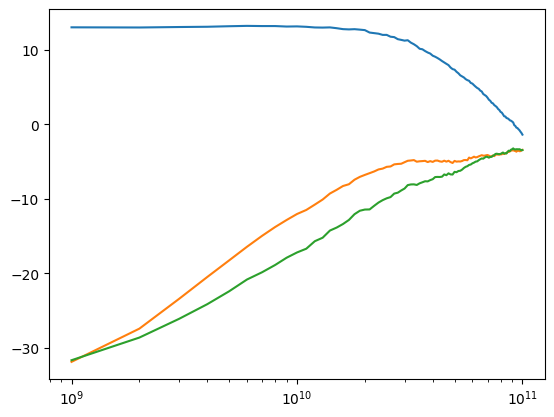

(np.float64(13.031129433771822), np.complex128(37000000000+0j), np.float64(0.19449474612146567))


In [ ]:
print(study.best_params)
rawfile, inparam, ouparam = GetOneCir([list(study.best_params.values())])
s21 = rawfile.get_trace("s_2_1").get_wave()
s11 = rawfile.get_trace("s_1_1").get_wave()
s22 = rawfile.get_trace("s_2_2").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21)))
plt.plot(np.real(frq),20*np.log10(np.abs(s11)))
plt.plot(np.real(frq),20*np.log10(np.abs(s22)))
plt.xscale('log')
plt.show()
print(PerfCalcS21(frq, s21))

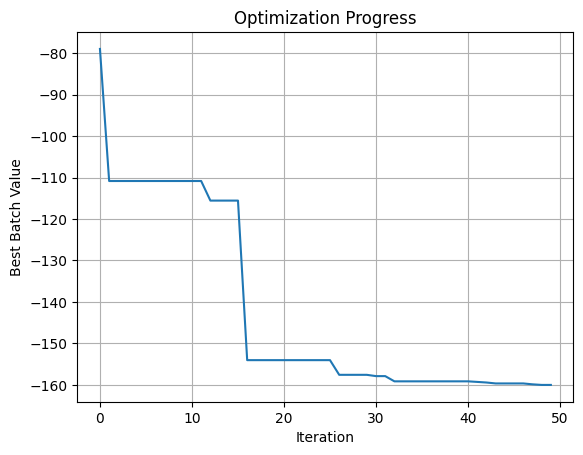

In [ ]:
# Plot optimization progress for the second example
from matplotlib import pyplot as plt
fi = open('optimization_data.txt', 'r')
lines = fi.readlines()
fi.close()
current_value = []
for line in lines:
	if line.startswith('Iteration'):
		parts = line.split(',')
		for part in parts:
			if 'Batch Values' in part:
				value_str = part.split(':')[1].strip()
				current_value.append(float(value_str))
plt.plot(current_value)
plt.xlabel('Iteration')
plt.ylabel('Best Batch Value')
plt.title('Optimization Progress')
plt.grid(True)
plt.show()

In [ ]:
print("Input Geometry:", inparam)
print("Output Geometry:", ouparam)

Input Geometry: [  7.          16.         185.         159.         109.
   4.          14.           0.36168155   0.5058774 ]
Output Geometry: [ 10.          13.         113.         134.         101.
   8.          10.           0.74090348   0.68510323]


In [ ]:
import tcoil_bias as tcoil
import gdspy
# This commmand is used to fix a bug (otherwise restart is mandatory, causing low efficiency)
# Refer to: https://github.com/heitzmann/gdspy/issues/222
gdspy.library.use_current_library = False

# The GDSII file is called a library, which contains multiple cells.
lib = gdspy.GdsLibrary(name = 'tcoil_bias')
lib.precision = 5e-9 # DRC alignment requirements: usually 5nm

In [ ]:
# Geometry must be placed in cells.
cell = lib.new_cell('test')
cell.add(tcoil.CreateTCoilTraceVanilla(int(inparam[0]), int(inparam[1]), int(inparam[2]), int(inparam[3]), int(inparam[4]), int(inparam[5]), int(inparam[6]), inparam[7], inparam[8], int(inparam[1]) + 5, includepad=True))
for layer in tcoil.all_layers:
	tcoil.CombineLayer(cell, layer)

# Display all cells using the internal viewer.
gdspy.LayoutViewer(lib, background = "#FFFFFF")

lib.write_gds('tcoil_bias_in2.gds')
lib.remove(cell)

0

In [ ]:
# Geometry must be placed in cells.
cell = lib.new_cell('test')
cell.add(tcoil.CreateTCoilTraceVanilla(int(ouparam[0]), int(ouparam[1]), int(ouparam[2]), int(ouparam[3]), int(ouparam[4]), int(ouparam[5]), int(ouparam[6]), ouparam[7], ouparam[8], int(ouparam[1]) + 5, includepad=True))
for layer in tcoil.all_layers:
	tcoil.CombineLayer(cell, layer)

# Display all cells using the internal viewer.
gdspy.LayoutViewer(lib, background = "#FFFFFF")

lib.write_gds('tcoil_bias_out2.gds')
lib.remove(cell)

0


#DZ INFO: oseda -2025.07



Note: Starting dynamic gmin stepping
Note: Dynamic gmin stepping completed
Note: Starting dynamic gmin stepping



Note: No compatibility mode selected!


Circuit: * circuits cml drv

Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver
 Reference value :  1.00000e+09
No. of Data Rows : 100
binary raw file "best_output2.raw"
Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver
 Reference value :  0.00000e+00
No. of Data Rows : 1
Reset re-loads circuit * circuits cml drv

Circuit: * circuits cml drv

ngspice-44.2 done


Note: Dynamic gmin stepping completed


['frequency', 's_1_1', 'z_1_1', 'y_1_1', 's_1_2', 'z_1_2', 'y_1_2', 's_2_1', 'z_2_1', 'y_2_1', 's_2_2', 'z_2_2', 'y_2_2']
OrderedDict({'Filename': 'best_output2.raw', 'Title': '* circuits cml drv', 'Date': 'Wed Oct 29 14:02:30  2025', 'Command': 'ngspice-44.2, Build Fri Jul 11 10:02:30 UTC 2025', 'Plotname': 'SP Analysis', 'Flags': 'complex', 'No. Variables': '13', 'No. Points': '100', 'Variables': ['frequency', 's_1_1', 'z_1_1', 'y_1_1', 's_1_2', 'z_1_2', 'y_1_2', 's_2_1', 'z_2_1', 'y_2_1', 's_2_2', 'z_2_2', 'y_2_2']})


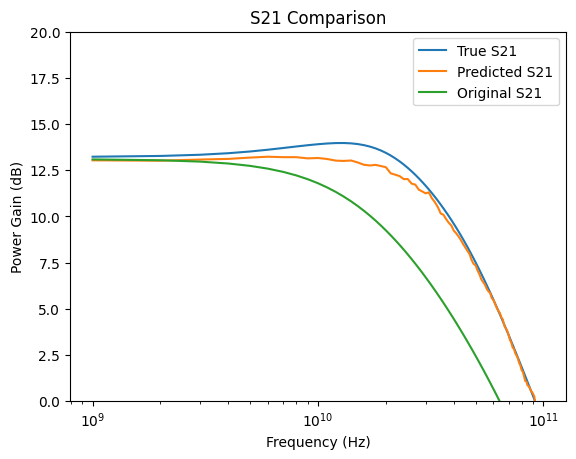

(np.float64(13.225601726985925), np.complex128(37000000000+0j), np.float64(0.7410916916759298))


In [ ]:
Create_Test_Circuit("tcoil_bias_in2","tcoil_bias_out2", raw_file='best_output2.raw', cir_name='best_test2.cir')
os.system(ngspice_prefix+'best_test2.cir')
rawfile = RawRead('best_output2.raw')
print(rawfile.get_trace_names())
print(rawfile.get_raw_property())
s21_true = rawfile.get_trace("s_2_1").get_wave()
s11_true = rawfile.get_trace("s_1_1").get_wave()
s22_true = rawfile.get_trace("s_2_2").get_wave()
frq = rawfile.get_trace("frequency").get_wave()
plt.plot(np.real(frq),20*np.log10(np.abs(s21_true)),label='True S21')
plt.plot(np.real(frq),20*np.log10(np.abs(s21)),label='Predicted S21')
plt.plot(np.real(frq),20*np.log10(np.abs(s21_org)),label='Original S21')
# plt.plot(np.real(frq),20*np.log10(np.abs(s11_true)))
# plt.plot(np.real(frq),20*np.log10(np.abs(s22_true)))
plt.ylabel('Power Gain (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('S21 Comparison')
plt.xscale('log')
plt.ylim(0,20)
plt.legend()
plt.show()
print(PerfCalcS21(frq, s21_true))

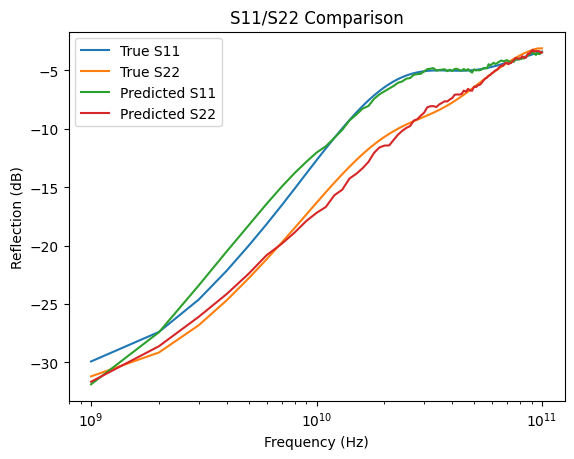

-4.991161945802983
-8.128071508156884


In [ ]:
gain0, f3db, expansion = PerfCalcS21(frq, s21_true)
plt.plot(np.real(frq),20*np.log10(np.abs(s11_true)),label='True S11')
plt.plot(np.real(frq),20*np.log10(np.abs(s22_true)),label='True S22')
plt.plot(np.real(frq),20*np.log10(np.abs(s11)),label='Predicted S11')
plt.plot(np.real(frq),20*np.log10(np.abs(s22)),label='Predicted S22')
plt.ylabel('Reflection (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('S11/S22 Comparison')
plt.xscale('log')
plt.legend()
plt.show()
print(PerfCalcRef(frq, s11_true, np.abs(f3db)))
print(PerfCalcRef(frq, s22_true, np.abs(f3db)))

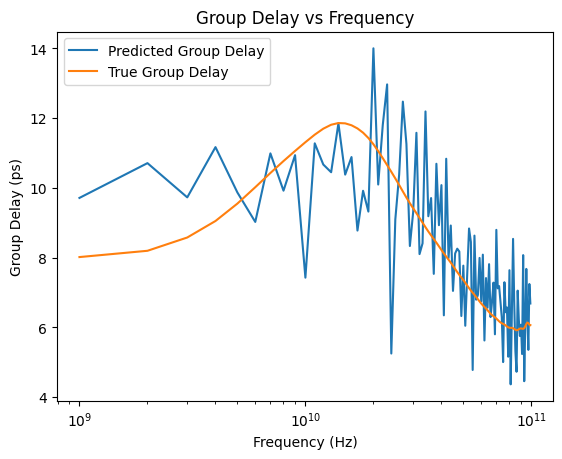

In [ ]:
group_delay = -np.diff(np.unwrap(np.angle(s21)))/np.diff(np.real(frq))/(2*np.pi)
group_delay_true = -np.diff(np.unwrap(np.angle(s21_true)))/np.diff(np.real(frq))/(2*np.pi)
plt.plot(np.real(frq[:-1]), group_delay*1e12,label='Predicted Group Delay')
plt.plot(np.real(frq[:-1]), group_delay_true*1e12,label='True Group Delay')
plt.ylabel('Group Delay (ps)')
plt.xlabel('Frequency (Hz)')
plt.title('Group Delay vs Frequency')
plt.xscale('log')
plt.legend()
plt.show()

As is shown above, without any passive peaking circuits, the driver could achieve 17GHz bandwidth with 13.07dB low-frequency gain. With the help of inverse design workflow, within 50 iterations (approx. 2min), a cost of -368 is achieved, with a 37GHz bandwidth, 13.22dB low-frequency gain, meaning a 2.2x bandwidth improvement, and peaking only less than 0.8dB. At the meantime, input and output reflection and group delay variation shows good results in both performance and surrogate model accuracy.

The cell below shows a complete layout combing both input T-coil and output T-coil. Since the structre of active circuits is symmetric, we propose same T-coil structure for diffrential inputs/outputs. The layout leaves enough space for active circuits, and by inserting the active layout, it could be easily incorporated into a chip level layout.

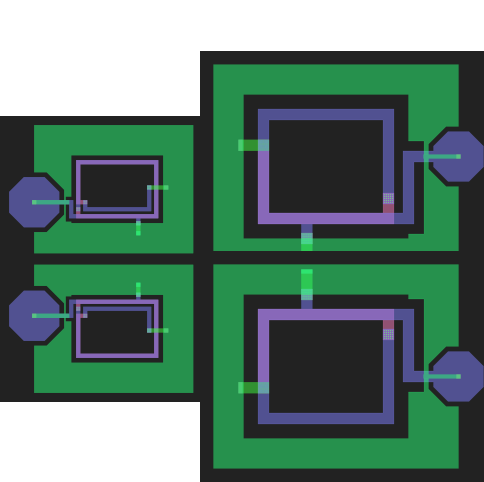

In [ ]:
import gdspy
import cairosvg
from IPython.display import SVG, display
from PIL import Image
from matplotlib import pyplot as plt
input_coil = gdspy.GdsLibrary(infile='tcoil_bias_in2.gds')
cell = list(input_coil.cells.values())[0]
cell.write_svg('temp_final.svg')
svg_data = open('temp_final.svg','r').read()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to='tcoil_bias_in2.png', scale = 0.1)
output_coil = gdspy.GdsLibrary(infile='tcoil_bias_out2.gds')
cell = list(output_coil.cells.values())[0]
cell.write_svg('temp_final.svg')
svg_data = open('temp_final.svg','r').read()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to='tcoil_bias_out2.png', scale = 0.1)
input_img = Image.open('tcoil_bias_in2.png')
flipped_input_img = input_img.transpose(Image.FLIP_TOP_BOTTOM)
output_img = Image.open('tcoil_bias_out2.png').transpose(Image.FLIP_LEFT_RIGHT)
flipped_output_img = output_img.transpose(Image.FLIP_TOP_BOTTOM)
fig = plt.figure(figsize=(6, 6))
plt.figimage(input_img, cmap='viridis', xo=0, yo=220)
plt.figimage(output_img, cmap='viridis', xo=200, yo=200)
plt.figimage(flipped_input_img, cmap='viridis', xo=0, yo=80)
plt.figimage(flipped_output_img, cmap='viridis', xo=200, yo=0)
plt.axis('off')
plt.show()

## Reference

[1] S. Galal and B. Razavi, "Broadband ESD protection circuits in CMOS technology," in IEEE Journal of Solid-State Circuits, vol. 38, no. 12, pp. 2334-2340, Dec. 2003.

[2] N. Hansen and A. Ostermeier, "Adapting arbitrary normal mutation distributions in evolution strategies: the covariance matrix adaptation," Proceedings of IEEE International Conference on Evolutionary Computation, Nagoya, Japan, 1996, pp. 312-317.

## Conclusion

In this jupyter notebook, we proposed a complete open-source open-source automatic AI-driven ultra-broadband passive-active co-design workflow and take a T-coil peaked wireline driver as an design example. Our workflow could automatically synthesize and optimize a passive structure for different types of active core circuits, showing great prospect to solve more passive-active circuit co-design tasks.

## To Do / Possible Future Improvements

- Find some way to run transient simulation (eye diagram) although ngspice does not support transient simulation when with s-parameter file 
- Active layout, plus whole-chip DRC & LVS check
- Parasitic extraction in active region
- Parasitic consideration of metal fills
- Neural network structure and inverse design algorithm comparison